In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Imports

In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

from psutil._common import bytes2human
import time
import sys
import numpy as np
import scipy as sp
import pandas as pd
import torch as tc
# import skdim
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from scipy.integrate import solve_ivp, odeint
# import pypsr as pyps
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from matplotlib import rc
%matplotlib inline

np.set_printoptions(linewidth=250)

font_dir = 'C:/Users/AdamG/Anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/'
# font_dir = '/Users/adamgiammarese/Library/Fonts/'

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Set directories

In [3]:
base_dir = os.getcwd().replace('\\','/') + '/'

fig_dir = base_dir + 'Figures/SOI/'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

data_dir = base_dir + 'SOI_Data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

os.chdir(base_dir)

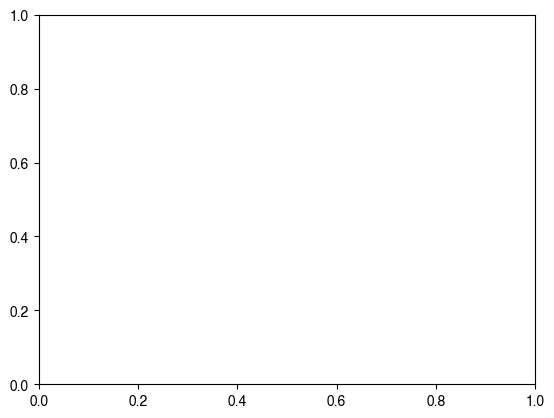

In [4]:
# !cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}\usepackage{xcolor}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper functions

In [5]:
tc.backends.cuda.is_built()

True

In [6]:
tc.backends.cudnn.is_available()

True

In [7]:
def lorenz(X,t,sigma=10,beta=8/3,rho=28):
    x, y, z = X
    dx = sigma*(y-x)
    dy = x*(rho-z) - y
    dz = x*y - beta*z
    return [dx, dy, dz]

def evolve(f,Tmax,dt,x0,sigma=10,beta=8/3,rho=28):
    t = np.arange(0,Tmax,dt)
    result = odeint(f, x0, t, args=(sigma,beta,rho))
    x,y,z = result.T
    return x,y,z,t

def lead_data(data,stride=1,lead=1):
    n_samples = len(data) - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j,:].flatten()
        labels[i,:] = data[j+lead,:].flatten()
    return features, labels

def AMI(x1, x2, bins=10):
    if len(np.shape(x1)) == 2 and np.shape(x1)[1] == 1:
        x1 = np.array(x1).reshape(-1,)
    if len(np.shape(x2)) == 2 and np.shape(x2)[1] == 1:
        x2 = np.array(x2).reshape(-1,)
    return mutual_info_score(None, None, contingency=np.histogram2d(x1, x2, bins=10)[0])

def lagged_AMI(x, max_lag=None, bins=10, normalize=True):
    if max_lag is None:
        max_lag = len(x)//2
    if len(np.shape(x)) == 1:
        return np.array([AMI(x[:len(x)-tau], x[tau:], bins=bins) for tau in range(max_lag)]).reshape(-1,1)
    else:
        return np.array([np.array([AMI(x[:len(x)-tau,i], x[tau:,i], bins=bins)
                          for tau in range(max_lag)])/AMI(x[:,i],x[:,i], bins=bins) for i in range(x.shape[1])]).T

def get_tau_crits(X_train, p_val=0.05, max_lag=600, bins=10, make_plot=False, 
                  dim_labels=['x','y','z'], save_fig=False, fname='',
                  title=None, debug_data=False, peak_order=1,
                  incorporate_peaks=True):
    amis = []
    N = X_train.shape[1]
    
    if dim_labels is None:
        dim_labels = np.arange(N).astype(str)
    
    max_lag = len(X_train)//2 if max_lag is None else min(max_lag,len(X_train)//2)
    lags = np.arange(max_lag)
    amis = lagged_AMI(X_train, max_lag, bins=bins, normalize=True)

#     for i in range(N):
#         lags, ami = pyps.lagged_ami(X_train[:,i], max_lag=max_lag)
#         amis.append(ami)
#     amis = np.array(amis).T
    
#     for i in range(N):
#         amis[:,i] /= amis[0,i]
        
    quantiles = np.quantile(amis, p_val, axis=0)
    
    drop_below_quantile = []
    peaks = []
    for i in range(N):
        peaks.append(sp.signal.argrelextrema(amis[:,i], np.greater, order=peak_order)[0])
        drop_below_quantile.append([])
        for j in range(1,max_lag):
            if amis[j,i] < quantiles[i] and amis[j-1,i] > quantiles[i]:
                drop_below_quantile[i].append(j)
        
    tau_crits = []
    for i in range(N):
        if incorporate_peaks:
            tau_crits.append(drop_below_quantile[i][0] if drop_below_quantile[i][0] > peaks[i][0] else (2*peaks[i][0] if peaks[i][0]<max_lag/2 else peaks[i][0]))
        else:
            tau_crits.append(drop_below_quantile[i][0])
#         tau_crits.append(2*drop_below_quantile[i][0] if drop_below_quantile[i][0] < max_lag/2 else drop_below_quantile[i][0])
#         tau_crits.append(drop_below_quantile[i][min(2,len(drop_below_quantile[i])-1)])
#         for j in range(max_lag):
#             if amis[j,i] <= quantiles[i]:#p_val:
#                 break
#         tau_crits += [j-1]
        
    if make_plot:
        fontsize = 32
        ms = 5
        lw = 2
        
        yticks = [0, 0.5, 1]


        ylim = [0,1]
        xy_annotate = (0.01,0.95)

        plt.rc('text', usetex=True)
        plt.rc('xtick',labelsize=fontsize)
        plt.rc('ytick',labelsize=fontsize)
        
        fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True)
        axs_lst = [axs] if N==1 else axs
        
        if title is not None:
            axs[0].set_title(title, fontsize=fontsize)
        
        for i, ax in enumerate(axs_lst):
            ax.plot(lags,amis[:,i],'k',lw=lw)
            
#             ax.axhline(p_val, ls='--', lw=lw, c='r')
            ax.axvline(tau_crits[i], ls='--', lw=lw, c='r')
            
            ax.axhline(quantiles[i], ls=':', lw=lw, c='b')
            ax.axvline(drop_below_quantile[i][0], ls=':', lw=lw, c='b')
            
            ax.set_xlim(0, max_lag-1)
            ax.set_ylim(ylim)
#             ax.text(0.99*max_lag, p_val+0.01, f'$pval={p_val}$', fontsize=fontsize, va='bottom', ha='right',
#                     color='r')
            if tau_crits[i] >= max_lag/2:
                ax.text(tau_crits[i]-0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='right', color='r')
            else:
                ax.text(tau_crits[i]+0.01*max_lag,0.9,
                     r'$\tau_{'+f'{i+1}'+r',crit}'+r'={:d}$'.format(tau_crits[i]),fontsize=fontsize,
                     va='top', ha='left', color='r')
            
            ax.xaxis.set_major_locator(plt.MaxNLocator(4))
            xticks = ax.get_xticks()
            if max_lag != xticks[-1]:
                ax.xaxis.set_major_locator(plt.MaxNLocator(5))
                xticks = ax.get_xticks()[:-1]
            ax.set_xticks(xticks)
            ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
            
            
            ax.plot(peaks[i],amis[peaks[i],i],'ro',ms=ms,label='Peaks')
            ax.set_ylabel(r'$AMI_{'+f'{dim_labels[i]}'+r'}(\tau)$', fontsize=fontsize)
            # ax1.legend(loc='upper right',prop={'size': 24})
            ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
#             ax.set_xticks(xticks)
            # ax1.set_xticklabels(xticks, fontsize=fontsize)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticks, fontsize=fontsize)
    
            if i == N - 1:
                ax.set_xlabel(r'$\tau$', fontsize=fontsize)
                
            plt.setp(ax.spines.values(), linewidth=2, zorder=100)
            ax.tick_params(length=10,width=2)
            
            ax.set_zorder(N-i)
    
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.2,wspace=0.15)
        fig.align_labels(axs)
        
        if save_fig:
            plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
            plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

        plt.show()
    
    if debug_data:
        return tau_crits, amis, peaks
    else:
        return tau_crits    

def make_features_and_labels(data,k,xi=1,stride=1,lead=1):
    n_samples = len(data) - (k-1)*xi - lead
    n_dims = data.shape[1]
    features = np.zeros((n_samples//stride,k*n_dims))
    labels = np.zeros((n_samples//stride,n_dims))
    for i in range(n_samples//stride):
        j = i*stride
        features[i,:] = data[j:j+k*xi:xi,:].T.flatten()
        labels[i,:] = data[j+(k-1)*xi+lead,:].flatten()
    return features, labels

def feature_selection(features, labels, n_estimators=100, max_depth=None,
                      random_state=None, n_jobs=-1, n_samples=None,
                      model_type='ETR', verbose=False, return_model=False):
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    start_time = time.time()
    stride = 1 if n_samples is None else len(features)//n_samples
    if model_type == 'RFR':
        model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                   labels[::stride])
    else:
        model = ExtraTreesRegressor(n_estimators=n_estimators, random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs, verbose=verbose).fit(features[::stride],
                                                                                                 labels[::stride])
    end_time = time.time()
    if verbose:
        print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
        print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
    if return_model:
        return model.feature_importances_, model, end_time-start_time
    else:
        return model.feature_importances_, end_time-start_time

def future_prediction(features=None, labels=None, FIs=None, future=None, p=None, xi=1,
                      n_estimators=200, disp_progress=False, desc='',
                      max_depth=None, random_state=None, n_jobs=-1,
                      min_samples_split=2, min_samples_leaf=1, ccp_alpha=0,
                      max_features=1.0, n_samples=None, model=None, s=None,
                      model_type='ETR', verbose=False, model_conversion=None,
                      device='cuda', debug_plot=False, save_fig=False, fname='',
                      dim_labels=None):
    if labels is None:
        N = np.shape(s)[0]
    else:
        N = np.shape(labels)[1]
    p_original = p
    k = np.shape(FIs)[-1]//N
    if features is not None and np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if labels is not None and np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if len(np.shape(p)) == 1:
        if verbose or disp_progress:
            print(f'Num features selected (given ind): {len(p)} of {len(FIs)}')
        ind = np.array(p)
    else:
        if len(np.shape(FIs)) == 2:
            all_FIs = FIs
            FIs = np.mean(FIs, axis=0)

            pvalue_thresh = 0.05
            pop_mean = 0
            pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
            ind = np.where(pvalues <= pvalue_thresh)[0]
            if len(ind) == 0:
                ind = np.arange(len(FIs))
            FI_0 = np.min(FIs[ind])
            if len(np.where(FIs >= FI_0)[0])/len(FIs) >= 0.5:
                pop_mean = np.median(FIs)
                pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
                ind = np.where(pvalues <= pvalue_thresh)[0]
                if len(ind) == 0:
                    # ind = np.arange(len(FIs))
                    FI_0 = np.median(FIs)
                else:
                    FI_0 = np.min(FIs[ind])
#             ind = np.where(FIs >= FI_0)[0]
#             p = len(np.where(FIs >= FI_0)[0])
        else:
            FI_0 = np.median(FIs)
        p = len(np.where(FIs >= FI_0)[0])#len(np.where(FIs >= np.mean(FIs))[0])
        if p_original is not None:
            if type(p_original) == str:
                p = round(float(p_original)*p)
            elif type(p_original) != int:
                p = round(p_original*len(FIs))
            else:
                if p_original < 0:
                    p = len(FIs)
        p = min(p, len(FIs))
        if verbose or disp_progress:
            print(f'Num features selected (given mean FIs): {p} of {len(FIs)}')
        ind = np.argsort(-FIs)[:p]

        if debug_plot:
            fontsize = 32
            ms = 10
            lw = 2

            if dim_labels is None:
                dim_labels = np.arange(1,N+1).astype(str)
            
            xy_annotate = (0.01,0.95)
            
            plt.rc('text', usetex=True)
            plt.rc('xtick',labelsize=fontsize)
            plt.rc('ytick',labelsize=fontsize)
            
            fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True,sharey=True)
            axs_lst = [axs] if N==1 else axs
            
            lags = np.arange(k)
            
            FI_0 = np.median(FIs)
            
            # ind = np.where(FIs >= FI_0)[0]
            
            for i, ax in enumerate(axs_lst):
                ax.plot(lags,FIs[i*k:(i+1)*k][::-1],'k',lw=lw)
            #     where = np.where(FIs[i*k-1:(i-1)*k:-1] >= np.median(FIs))[0]
            #     where = np.where(pvalues[i*k-1:(i-1)*k:-1] >= pvalue_thresh)[0]
            #     ax.plot(lags[where], FIs[i*k-1:(i-1)*k:-1][where], 'b.', ms=10, zorder=10)
            
            #     ind_tmp = np.where(FIs[i*k:(i+1)*k] >= FI_0)[0]
                
                
                ind_tmp = ind[np.where(np.logical_and(ind <= (i+1)*k-1, ind >= i*k))[0]]
                
            # #     pvalues_tmp = pvalues[i*k:(i+1)*k]
            # #     where = np.where(pvalues_tmp >= pvalue_thresh)[0]
            # #     if len(where) == 0:
            # #         ind_tmp = np.arange(k)[np.argmax(pvalues_tmp):]
            # #     else:
            # #         ind_tmp = np.arange(k)[where[-1]:]
            
                ax.plot((i+1)*k-1-ind_tmp,FIs[ind_tmp],'b.',ms=10)
                
                ax.axhline(FI_0, ls='--', c='r', lw=lw)
            
                ax.set_xlim(0, max(lags))# k-1)
                ax.set_ylim(0, None)
                
                xticks = ax.get_xticks()
                ax.set_xticks(xticks)
                ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
                
                ax.text(0.99*ax.get_xlim()[1], FI_0+0.05*np.diff(ax.get_ylim()), r'$\text{median}(\mathbf{FI})$', fontsize=fontsize, va='bottom', ha='right',
                        color='r')
            
                ax.set_ylabel(r'$FI_{'+'{:}'.format(dim_labels[i])+r'}(\tau)$', fontsize=fontsize)
                # ax1.legend(loc='upper right',prop={'size': 24})
                if N > 26:
                    ax.annotate(r'\textbf{(\roml{'+str(i+1)+'})}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
                else:
                    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
            #             ax.set_xticks(xticks)
                yticks = ax.get_yticks()
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=fontsize)
            
                if i == N - 1:
                    ax.set_xlabel(r'$\tau$', fontsize=fontsize)
            
                plt.setp(ax.spines.values(), linewidth=2, zorder=100)
                ax.tick_params(length=10,width=2)
            
                ax.set_zorder(N-i)
            
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.2,wspace=0.15)
            fig.align_labels(axs)
            
            if save_fig:
                plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
                plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
            
            plt.show()


    
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
            #         elif model_type == 'GBR':
            #             model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=random_state, max_depth=max_depth, verbose=True)
            #         elif model_type == 'HGBR':
            #             model = HistGradientBoostingRegressor(max_iter=n_estimators, random_state=random_state, verbose=True)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
    if model_conversion == 'hummingbird':
        start_convert = time.time()
        model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
        model.to(device)
        end_convert = time.time()
        if verbose or disp_progress:
            print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
            
            
    prediction = np.zeros((future,N))
    if s is None:
        s = np.hstack((features[-1].reshape((N,k*xi))[:,1:],labels[-1].reshape(-1,1)))#features[-1].reshape((N,k*xi)) # shape (N, k*xi)
    else:
        s = s.reshape((N,k*xi)) # shape (N, k*xi)
    s_delayed = s[:,-(k-1)*xi-1::xi] # shape (N, k)

    if disp_progress:
        lst = trange(future,desc=desc)
    else:
        lst = range(future)
    for i in lst:
        y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
        prediction[i,:] = y_pred.reshape(-1,)
        s = np.hstack((s.reshape((N,k*xi))[:,1:],y_pred))
        s_delayed = s[:,-(k-1)*xi-1::xi]
    prediction = np.array(prediction)
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def future_prediction_lead(features, labels, FIs, future, lead=1, p=None, xi=1, n_estimators=200,
                           disp_progress=False, desc='', leave=False, max_depth=None, random_state=None,
                           n_jobs=-1, min_samples_split=2, min_samples_leaf=1, ccp_alpha=0, max_features=1.0,
                           n_samples=None, model=None, y_train=None, y_test=None, model_type='RFR', verbose=False,
                           open_loop=True, model_conversion=None, device='cuda', debug_plot=False, save_fig=False, fname='',
                           dim_labels=None):
    N = np.shape(labels)[1]
    p_original = p
    k = np.shape(FIs)[-1]//N
    if np.shape(features)[1] == 1:
        features = features.reshape(-1,)
    if np.shape(labels)[1] == 1:
        labels = labels.reshape(-1,)
    if len(np.shape(p)) == 1:
        if verbose or disp_progress:
            print(f'Num features selected (given ind): {len(p)} of {len(FIs)}')
        ind = np.array(p)
    else:
        if len(np.shape(FIs)) == 2:
            all_FIs = FIs
            FIs = np.mean(FIs, axis=0)

            pvalue_thresh = 0.05
            pop_mean = 0
            pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
            ind = np.where(pvalues <= pvalue_thresh)[0]
            if len(ind) == 0:
                ind = np.arange(len(FIs))
            FI_0 = np.min(FIs[ind])
            if len(np.where(FIs >= FI_0)[0])/len(FIs) >= 0.5:
                pop_mean = np.median(FIs)
                pvalues = sp.stats.ttest_1samp(all_FIs, pop_mean, axis=0, alternative='greater').pvalue
                ind = np.where(pvalues <= pvalue_thresh)[0]
                if len(ind) == 0:
                    # ind = np.arange(len(FIs))
                    FI_0 = np.median(FIs)
                else:
                    FI_0 = np.min(FIs[ind])
#             ind = np.where(FIs >= FI_0)[0]
#             p = len(np.where(FIs >= FI_0)[0])
        else:
            FI_0 = np.median(FIs)
        p = len(np.where(FIs >= FI_0)[0])#len(np.where(FIs >= np.mean(FIs))[0])
        if p_original is not None:
            if type(p_original) == str:
                p = round(float(p_original)*p)
            elif type(p_original) != int:
                p = round(p_original*len(FIs))
            else:
                if p_original <= 0:
                    p = len(FIs)
        p = min(p, len(FIs))
        if verbose or disp_progress:
            print(f'Num features selected (given mean FIs): {p} of {len(FIs)}')
        ind = np.argsort(-FIs)[:p]

        if debug_plot:
            fontsize = 32
            ms = 10
            lw = 2

            if dim_labels is None:
                dim_labels = np.arange(1,N+1).astype(str)
            
            xy_annotate = (0.01,0.95)
            
            plt.rc('text', usetex=True)
            plt.rc('xtick',labelsize=fontsize)
            plt.rc('ytick',labelsize=fontsize)
            
            fig, axs = plt.subplots(N,1,figsize=(12,3*N),sharex=True,sharey=True)
            axs_lst = [axs] if N==1 else axs
            
            lags = np.arange(k)
            
            FI_0 = np.median(FIs)
            
            # ind = np.where(FIs >= FI_0)[0]
            
            for i, ax in enumerate(axs_lst):
                ax.plot(lags,FIs[i*k:(i+1)*k][::-1],'k',lw=lw)
            #     where = np.where(FIs[i*k-1:(i-1)*k:-1] >= np.median(FIs))[0]
            #     where = np.where(pvalues[i*k-1:(i-1)*k:-1] >= pvalue_thresh)[0]
            #     ax.plot(lags[where], FIs[i*k-1:(i-1)*k:-1][where], 'b.', ms=10, zorder=10)
            
            #     ind_tmp = np.where(FIs[i*k:(i+1)*k] >= FI_0)[0]
                
                
                ind_tmp = ind[np.where(np.logical_and(ind <= (i+1)*k-1, ind >= i*k))[0]]
                
            # #     pvalues_tmp = pvalues[i*k:(i+1)*k]
            # #     where = np.where(pvalues_tmp >= pvalue_thresh)[0]
            # #     if len(where) == 0:
            # #         ind_tmp = np.arange(k)[np.argmax(pvalues_tmp):]
            # #     else:
            # #         ind_tmp = np.arange(k)[where[-1]:]
            
                ax.plot((i+1)*k-1-ind_tmp,FIs[ind_tmp],'b.',ms=10)
                
                ax.axhline(FI_0, ls='--', c='r', lw=lw)
            
                ax.set_xlim(0, max(lags))# k-1)
                ax.set_ylim(0, None)
                
                xticks = ax.get_xticks()
                ax.set_xticks(xticks)
                ax.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], fontsize=fontsize)
                
                ax.text(0.99*ax.get_xlim()[1], FI_0+0.05*np.diff(ax.get_ylim()), r'$\text{median}(\mathbf{FI})$', fontsize=fontsize, va='bottom', ha='right',
                        color='r')
            
                ax.set_ylabel(r'$FI_{'+'{:}'.format(dim_labels[i])+r'}(\tau)$', fontsize=fontsize)
                # ax1.legend(loc='upper right',prop={'size': 24})
                if N > 26:
                    ax.annotate(r'\textbf{(\roml{'+str(i+1)+'})}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
                else:
                    ax.annotate(r'\textbf{('+chr(97+i)+')}', xy=xy_annotate, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize)
            #             ax.set_xticks(xticks)
                yticks = ax.get_yticks()
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=fontsize)
            
                if i == N - 1:
                    ax.set_xlabel(r'$\tau$', fontsize=fontsize)
            
                plt.setp(ax.spines.values(), linewidth=2, zorder=100)
                ax.tick_params(length=10,width=2)
            
                ax.set_zorder(N-i)
            
            plt.tight_layout()
            plt.subplots_adjust(hspace=0.2,wspace=0.15)
            fig.align_labels(axs)
            
            if save_fig:
                plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
                plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
            
            plt.show()
    
    start_time = time.time()
    if model is None:
        stride = 1 if n_samples is None else len(features)//n_samples if type(n_samples) == int else round(len(features)*n_samples)
        if model_type == 'RFR':
            model = RandomForestRegressor(n_estimators=n_estimators,
                                          random_state=random_state,
                                          max_depth=max_depth, n_jobs=n_jobs,
                                          min_samples_split=min_samples_split,
                                          min_samples_leaf=min_samples_leaf,
                                          ccp_alpha=ccp_alpha, verbose=verbose)
        else:
            model = ExtraTreesRegressor(n_estimators=n_estimators,
                                        random_state=random_state,
                                        max_depth=max_depth, n_jobs=n_jobs,
                                        max_features=max_features,
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf,
                                        ccp_alpha=ccp_alpha, verbose=verbose)
        model = model.fit(features[::stride,ind],labels[::stride])
        end_time = time.time()
        
        end_time = time.time()
        if verbose or disp_progress:
            print('Training time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
            print('RAM Used:', bytes2human(sys.getsizeof(pkl.dumps(model))))
            
        if model_conversion == 'hummingbird':
            start_convert = time.time()
            model = convert(model, 'torch', extra_config={"tree_implementation":"tree_trav"})
            model.to(device)
            end_convert = time.time()
            if verbose or disp_progress:
                print(f'Conversion time ({model_conversion}):', datetime.utcfromtimestamp(end_convert-start_convert).strftime('%H hours, %M minutes, %S.%f seconds'))
    
    
    if open_loop:
        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed_open_loop = np.zeros((future,p))
        for i in range(future):
            s_delayed_open_loop[i,:] = s[:,::xi].flatten()[ind]
            if i >= lead - 1:
                s = np.hstack((s[:,1:].flatten(),y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s[:,1:].flatten(),y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            
        prediction = model.predict(s_delayed_open_loop)
    else:
        prediction = np.zeros((future,N))

        s = y_train[-(k-1)*xi-lead:len(y_train)-(lead-1)].T.flatten().reshape((N,(k-1)*xi+1))
        s_delayed = s[:,::xi]
        
        if disp_progress:
            lst = trange(future,desc=desc,leave=leave)
        else:
            lst = range(future)
        for i in lst:
            y_pred = model.predict(s_delayed.flatten()[ind].reshape(1, -1))[0].reshape((N,1))
            prediction[i,:] = y_pred
            if i >= lead - 1:
                s = np.hstack((s[:,1:].flatten(),y_test[i+1-lead])).reshape((N,(k-1)*xi+1))
            else:
                s = np.hstack((s[:,1:].flatten(),y_train[len(y_train)-(lead-1)+i])).reshape((N,(k-1)*xi+1))
            s_delayed = s[:,::xi]
            
    prediction = np.array(prediction).reshape(-1,N)
        
    end_time = time.time()
    if verbose or disp_progress:
        print('Total time:', datetime.utcfromtimestamp(end_time-start_time).strftime('%H hours, %M minutes, %S.%f seconds'))
    return prediction, model, end_time-start_time

def rmse(x,y,z,x_result,y_result,z_result,cutoff=0,rm_transient=0):
    x_diff_sq = np.power(x[cutoff+rm_transient:] - x_result[cutoff:],2)
    y_diff_sq = np.power(y[cutoff+rm_transient:] - y_result[cutoff:],2)
    z_diff_sq = np.power(z[cutoff+rm_transient:] - z_result[cutoff:],2)
    return np.sqrt((x_diff_sq + y_diff_sq + z_diff_sq)/3)

def rmse_vec(y_true,y_pred):
    return np.sqrt(np.mean(np.vstack([(y_true[:,i]-y_pred[:,i])**2 for i in range(y_true.shape[1])]), axis=0))

def envelope_length(y_true,y_pred,threshold=5):
    error_signal = rmse_vec(y_true,y_pred)
    return np.argmax(error_signal > threshold)

def lyapunov_time(t,LE_max,cutoff=0,rm_transient=0):
    return (t[cutoff+rm_transient:]-t[cutoff+rm_transient])/LE_max

def delay_embedding_multidimensional(input,emb_dim,n=None,tau=1):
    # input is shape (n_dims,n_samples)
    input = np.array(input)
    if n is None:
        n = input.shape[1] - (emb_dim-1)*tau
    embedding = np.zeros((n,emb_dim*len(input)))
    for i in range(n):
        j = i
        embedding[i,:] = input[:,j:j+emb_dim*tau:tau].flatten()
    return embedding

def RMSE_summary(y_pred, y_test):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        res = []
        for i in range(np.shape(y_test)[1]):
            res.append(np.sqrt(np.mean((y_pred[:,i]-y_test[:,i])**2)))
        return np.mean(res)
    return np.sqrt(np.mean((y_pred-y_test)**2))

def PCC_summary(y_pred, y_test):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        res = []
        for i in range(np.shape(y_test)[1]):
            o_dev = y_test[:,i] - np.mean(y_test[:,i])
            p_dev = y_pred[:,i] - np.mean(y_pred[:,i])
            res.append(np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2))))
        return np.mean(res)
    o_dev = y_test - np.mean(y_test)
    p_dev = y_pred - np.mean(y_pred)
    return np.sum(o_dev*p_dev)/(np.sqrt(np.sum(o_dev**2))*np.sqrt(np.sum(p_dev**2)))

def AMI_summary(y_pred, y_test, bins=10, normalize=True):
    if len(np.shape(y_test)) == 2 and np.shape(y_test)[1] > 1:
        return np.mean([AMI(y_pred[:,i], y_test[:,i], bins=bins)/(AMI(y_test[:,i], y_test[:,i], bins=bins)
                                                                  if normalize else 1) for i in range(np.shape(y_test)[1])])
    return AMI(y_pred, y_test, bins=bins)/(AMI(y_test, y_test, bins=bins) if normalize else 1)

In [8]:
class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def plot_test_results(y_test, pred_data_lst, label_lst, color_lst, lw_lst, ls_lst, dates,
                      xlabel='X', ylabels=None, save_fig=False, fname='', mag_format=False):
    fontsize = 24
    lw = 2
    ls_test = '-'

    plt.rc('text', usetex=True)
    plt.rc('xtick',labelsize=fontsize)
    plt.rc('ytick',labelsize=fontsize)

    annotate_xy = (0.005,0.965)

    errors = [rmse_vec(y_test,y_pred) for y_pred in pred_data_lst]
    max_error = max([max(error) for error in errors])

    N = np.shape(y_test)[1]
    if ylabels is None:
        yalbels = [f'Y{i}' for i in range(N)]

    fig = plt.figure(constrained_layout=False,figsize=(12,5*(N+2)))



    gs1 = fig.add_gridspec(nrows=4, ncols=1, left=0.05, right=0.95,
                            wspace=0.05, hspace=0.15)
    axs = []
    for i in range(N+1):
        if i == 0:
            axs.append(fig.add_subplot(gs1[0, 0]))
        else:
            axs.append(fig.add_subplot(gs1[i, 0], sharex=axs[0]))




    lines = []
    for i in range(N):
        lines.append([axs[i].plot(X_test[:,i],'k',lw=3,label=r'Test',ls=ls_test)[0]] + [axs[i].plot(pred_data_lst[j][:,i],color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
        axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
        axs[i].set_xlim(0, len(y_test)-1)

        axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

        yticks = axs[i].get_yticks()[1:-1]

        if mag_format:
            multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
            fmt = MagnitudeFormatter(multiplier)
            axs[i].yaxis.set_major_formatter(fmt)
            # plt.ticklabel_format(style='sci', axis='y')
            # print(ax.yaxis.get_major_formatter().__dict__)
            axs[i].yaxis.offsetText.set_visible(False)

            # print(yticks)
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:.1f}'.format(ytick/10**multiplier) for ytick in yticks])

            if multiplier != 0:
                axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
        else:
            axs[i].set_yticks(yticks)
            axs[i].set_yticklabels(['{:}'.format(ytick) for ytick in yticks])

        plt.setp(axs[i].get_xticklabels(), visible=False)
        axs[i].tick_params(bottom=True, top=False, left=True, right=False)
        axs[i].set_zorder(N+1-i)

    i = -1
    lines.append([axs[i].plot(errors[j],color_lst[j],lw=lw_lst[j],label=label_lst[j],ls=ls_lst[j])[0] for j in range(len(pred_data_lst))])
    axs[i].set_ylabel(ylabels[i], fontsize=fontsize)
    axs[i].set_xlim(0, len(y_test)-1)
    axs[i].set_ylim(0, None)

    axs[i].yaxis.set_major_locator(plt.MaxNLocator(4))

    yticks = axs[i].get_yticks()[:-1]

    if mag_format:
        multiplier = int('{:e}'.format(yticks[-1]).split('e')[1])
        fmt = MagnitudeFormatter(multiplier)
        axs[i].yaxis.set_major_formatter(fmt)
        # plt.ticklabel_format(style='sci', axis='y')
        # print(ax.yaxis.get_major_formatter().__dict__)
        axs[i].yaxis.offsetText.set_visible(False)

        # print(yticks)
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:.1f}'.format(ytick/10**multiplier) for ytick in yticks])

        if multiplier != 0:
            axs[i].annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(-0.175,1.02), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)
    else:
        axs[i].set_yticks(yticks)
        axs[i].set_yticklabels(['{:.1f}'.format(ytick) for ytick in yticks])

    plt.setp(ax1.get_xticklabels(), visible=True)
    ax1.tick_params(bottom=True, top=False, left=True, right=False)
    ax1.set_zorder(1)

    locator = plt.MaxNLocator(5)
    axs[i].xaxis.set_major_locator(locator)

    xticks = axs[i].get_xticks().astype(int)[:-1]
    xticklabels = [dates[xtick] if type(dates[xtick])==str else dates[xtick].strftime('%m/%d/%Y') for xtick in xticks]

    # xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xticklabels, fontsize=fontsize, rotation=30, ha='center')


    axs[0].legend(handles=lines[0],loc='lower center', bbox_to_anchor=(0.5,1.025),prop={'size': fontsize},ncol=len(pred_data_lst)+1,columnspacing=1,handletextpad=0.5)
    # # fig.legend(handles=[line1,line2,line3],loc='lower center', bbox_to_anchor=(0.5,.85),prop={'size': fontsize},ncol=3)



    # plt.subplots_adjust(hspace=0, wspace=0.25)
    # plt.tight_layout()

    fig.align_labels(axs)
    # fig.align_labels([ax5,ax6])

    for i in range(N+1):
        plt.setp(axs[i].spines.values(), linewidth=3, zorder=100)
        axs[i].tick_params(length=15,width=3)

    if save_fig:
        plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
        plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

    plt.show()

In [9]:
def index_to_date_num(index,start_year,start_month):
    elapsed_years = (index+start_month-1)//12
    elapsed_months = index - elapsed_years*12
    current_year = start_year + elapsed_years
    current_month = (start_month + elapsed_months-1)%12 + 1
    return current_year*100 + current_month

months = ['Jan', 'Feb', 'Mar', 'Apr',
          'May', 'Jun', 'Jul', 'Aug',
          'Sep', 'Oct', 'Nov', 'Dec']

# SOI

## Data

In [11]:
from urllib.request import urlretrieve

In [12]:
urlretrieve('https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat', data_dir+'soi.dat')

('E:/College/Graduate/Semester 1/Time Series Project/SOI_Data/soi.dat',
 <http.client.HTTPMessage at 0x1a4a1d0d110>)

In [13]:
soi_df = pd.read_csv(data_dir + 'soi.dat', sep=' ', skipinitialspace=True, names=months+['Annual'])
soi_df

Jan    Feb     Mar     Apr     May     Jun     Jul     Aug     Sep  \
1866 -0.616 -0.117  -0.615  -0.646   0.038  -0.815  -0.345   0.360  -0.176   
1867  0.095 -0.012  -0.091   0.830   0.503  -0.483   0.440   0.340   0.120   
1868 -0.163 -0.337  -1.563   0.303  -1.336  -2.199  -0.402  -1.415  -1.226   
1869 -1.896 -0.264  -0.586   2.117   1.405   1.534   1.422   0.936   0.117   
1870  1.062  0.181  -0.746   0.472  -0.113  -1.103   0.172   0.979  -0.002   
...     ...    ...     ...     ...     ...     ...     ...     ...     ...   
2020  0.010 -0.314  -0.750   0.155   0.707  -1.359   0.437   0.847   0.980   
2021  1.640  1.017  -0.197   0.303   0.487   0.224   1.614   0.273   0.858   
2022  0.338  0.757   1.353   2.686   1.904   2.449   0.910   0.805   1.734   
2023  1.136  0.931  -0.381  -0.034  -1.602  -0.123  -0.382  -1.598  -1.360   
2024  0.307 -1.471 -99.990 -99.990 -99.990 -99.990 -99.990 -99.990 -99.990   

         Oct     Nov     Dec  Annual  
1866   0.072   1.097  -0.159  -0.160  
1867  -0.558  -0.649  -0.889  -0.030  
1868  -1.241  -1.493   0.515  -0.880  
1869   0.852   0.563   0.422   0.552  
1870  -0.578  -0.856  -1.294  -0.152  
...      ...     ...     ...     ...  
2020   0.271   0.853   1.763   0.300  
2021   0.512   1.118   1.427   0.773  
2022   1.725   0.311   2.111   1.424  
2023  -0.599  -0.897  -0.386  -0.441  
2024 -99.990 -99.990 -99.990 -99.990  

[159 rows x 13 columns]

In [14]:
soi, dates = soi_df[months].stack().to_numpy(), soi_df[months].stack().index.to_numpy()
dates = np.array([f'{month}, {year}' for (year, month) in dates])
soi, dates = np.delete(soi, np.where(soi == -99.99)).reshape(-1,1), np.delete(dates, np.where(soi == -99.99))
soi.shape

(1898, 1)

In [15]:
len_train = dates.tolist().index('Jan, 1984')
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


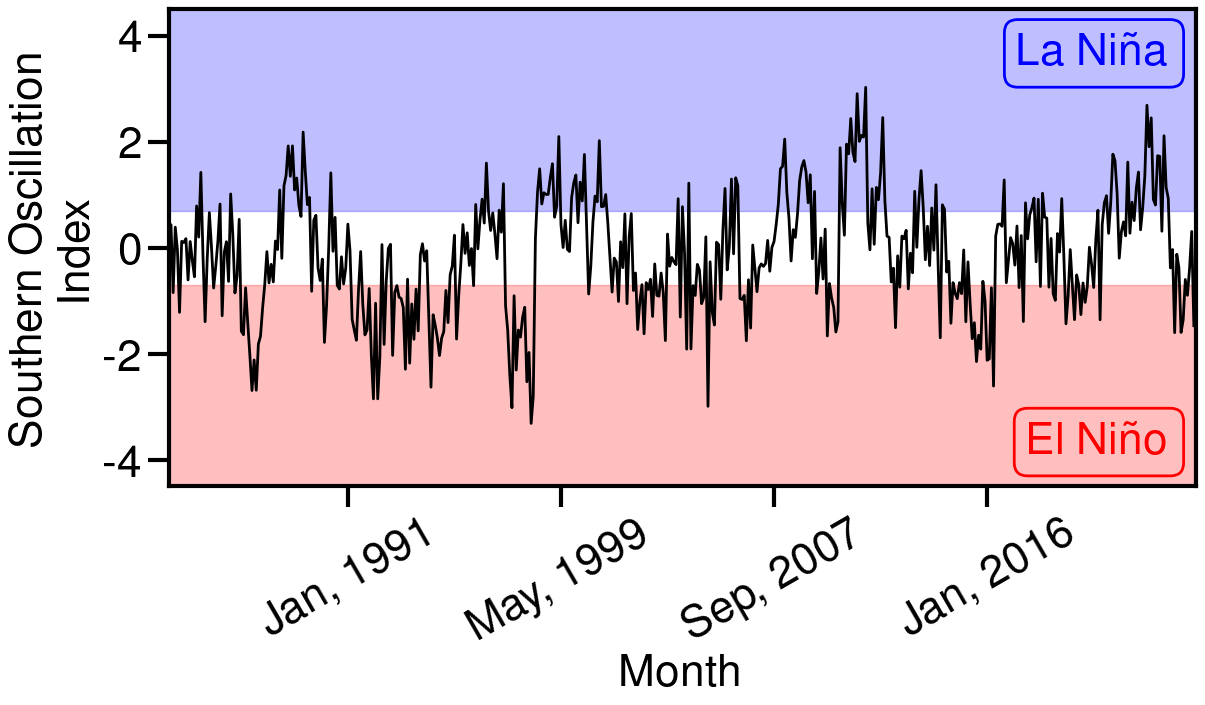

In [16]:
fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(12, 7))
ax1 = ax


# ax1.plot(soi,'k-',ms=10,lw=2)
ax1.plot(soi,'-',color='k',ms=10,lw=2,zorder=2)

# ylim = ax1.get_ylim()
ylim = [-4.5,4.5]
ax1.set_ylim(ylim)

ax1.fill_between([0, len(soi)-1],[.7]*2,[ylim[1]]*2,color='b',alpha=0.25,zorder=1)
ax1.fill_between([0, len(soi)-1],[-.7]*2,[ylim[0]]*2,color='r',alpha=0.25,zorder=1)

ax1.annotate(r'La Ni\~na', (.975,.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=fontsize, c='b',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='b',lw=2))
ax1.annotate(r'El Ni\~no', (.975,.05), xycoords='axes fraction', ha='right', va='bottom',
             fontsize=fontsize, c='r',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='r',lw=2))

# ax1.text(0.2,corr_dim+0.05,r'True $D_C = '+'{:5.4f}'.format(corr_dim)+'$',fontsize=fontsize)

# ax1.set_xlim(0,len(predicted))
# ax1.set_ylim(0.8,2.6)

# first_year = int(date_strings[0].split(' ')[1])
# last_year = int(date_strings[-1].split(' ')[1])
# num_ticks = 5
# xticklabels = np.arange(first_year,last_year,int((last_year-first_year)/num_ticks))
ax1.set_xlim(len_train,len(soi))

locator = plt.MaxNLocator(5)
ax1.xaxis.set_major_locator(locator)

xticks = ax1.get_xticks().astype(int)[1:-1]
xticklabels = [dates[xtick] for xtick in xticks]

# xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticklabels, fontsize=fontsize, rotation=30, ha='center')

ax1.set_yticks([-4,-2,0,2,4])
ax1.set_yticklabels([-4,-2,0,2,4])

# ax1.set_xlabel(r'Year',fontsize=fontsize)
ax1.set_ylabel('Southern Oscillation\nIndex',fontsize=fontsize)

left_date = 'Jan, 2012'


# ax1.set_xlim(date_strings.index(left_date), len(soi))

# num_ticks = 9
# xticks = np.linspace(date_strings.index(left_date),len(soi),num_ticks)
# ax1.set_xticks(xticks)

# xticks = ax1.get_xticks()
# xticklabels = [format_date(index_to_date_num(int(xtick)-date_strings.index(left_date),
#                int(left_date.split(',')[1]),months.index(left_date.split(',')[0]))) for xtick in xticks]
# ax1.set_xticklabels(xticklabels, rotation=30, ha='center', fontsize=fontsize)

ax1.set_xlabel('Month',fontsize=fontsize)


plt.tight_layout()
plt.subplots_adjust(hspace=0)
ax1.tick_params(length=15,width=3)
plt.setp(ax1.spines.values(), linewidth=3, zorder=10)

title = 'Test SOI Data'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

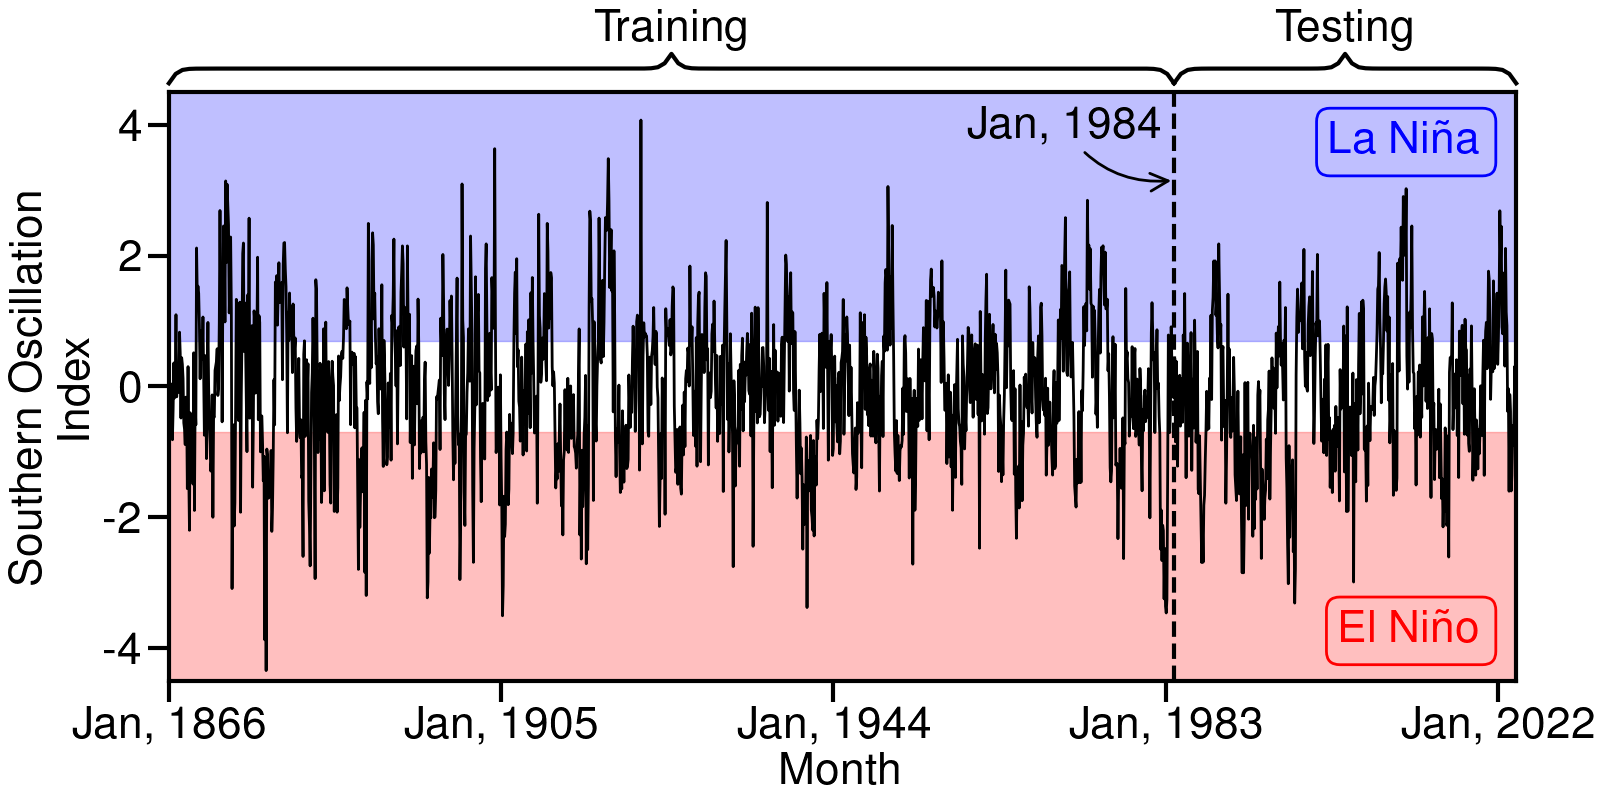

In [17]:
fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(16, 8))


def draw_brace(ax, xspan, yy, text, lw=3):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=lw, clip_on=False)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom', fontsize=fontsize)


# ax.plot(soi,'k-',ms=10,lw=2)
ax.plot(soi,'-',color='k',ms=10,lw=2,zorder=2)

# ylim = ax.get_ylim()
ylim = [-4.5,4.5]
ax.set_ylim(ylim)

ax.fill_between([0, len(soi)-1],[.7]*2,[ylim[1]]*2,color='b',alpha=0.25,zorder=1)
ax.fill_between([0, len(soi)-1],[-.7]*2,[ylim[0]]*2,color='r',alpha=0.25,zorder=1)

ax.annotate(r'La Ni\~na', (.975,.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=fontsize, c='b',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='b',lw=2))
ax.annotate(r'El Ni\~no', (.975,.05), xycoords='axes fraction', ha='right', va='bottom',
             fontsize=fontsize, c='r',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='r',lw=2))

# ax.text(0.2,corr_dim+0.05,r'True $D_C = '+'{:5.4f}'.format(corr_dim)+'$',fontsize=fontsize)

# ax.set_xlim(0,len(predicted))
# ax.set_ylim(0.8,2.6)

# first_year = int(date_strings[0].split(' ')[1])
# last_year = int(date_strings[-1].split(' ')[1])
# num_ticks = 5
# xticklabels = np.arange(first_year,last_year,int((last_year-first_year)/num_ticks))
# ax.set_xlim(len_train,len(soi))
ax.set_xlim(0,len(soi))

# locator = plt.MaxNLocator(5)
# ax.xaxis.set_major_locator(locator)

# xticks = ax.get_xticks().astype(int)[:-1]

xticks = np.arange(0,len(dates),len(dates)//4//12*12)
xticklabels = [dates[xtick] for xtick in xticks]

# xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=0, ha='center')

ax.set_yticks([-4,-2,0,2,4])
ax.set_yticklabels([-4,-2,0,2,4])

# ax.set_xlabel(r'Year',fontsize=fontsize)
ax.set_ylabel('Southern Oscillation\nIndex',fontsize=fontsize)

# left_date = 'Jan, 2012'


# ax.set_xlim(date_strings.index(left_date), len(soi))

# num_ticks = 9
# xticks = np.linspace(date_strings.index(left_date),len(soi),num_ticks)
# ax.set_xticks(xticks)

# xticks = ax.get_xticks()
# xticklabels = [format_date(index_to_date_num(int(xtick)-date_strings.index(left_date),
#                int(left_date.split(',')[1]),months.index(left_date.split(',')[0]))) for xtick in xticks]
# ax.set_xticklabels(xticklabels, rotation=30, ha='center', fontsize=fontsize)

ax.set_xlabel('Month',fontsize=fontsize)


draw_brace(ax, (0,len_train), ax.get_ylim()[-1], 'Training', lw=3)
draw_brace(ax, (len_train,len(soi)), ax.get_ylim()[-1], 'Testing', lw=3)
ax.axvline(len_train, c='k', ls='--', lw=3)
ax.annotate('Jan, 1984', xytext=(len_train-0.01*len(soi),ax.get_ylim()[-1]-0.025*np.diff(ax.get_ylim())[0]),
            textcoords='data', fontsize=fontsize, ha='right', va='top',
            xy=(len_train,ax.get_ylim()[-1]-0.15*np.diff(ax.get_ylim())[0]),
            xycoords='data', arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.3", lw=2))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
ax.tick_params(length=15,width=3)
plt.setp(ax.spines.values(), linewidth=3, zorder=10)

title = 'Raw SOI Data'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

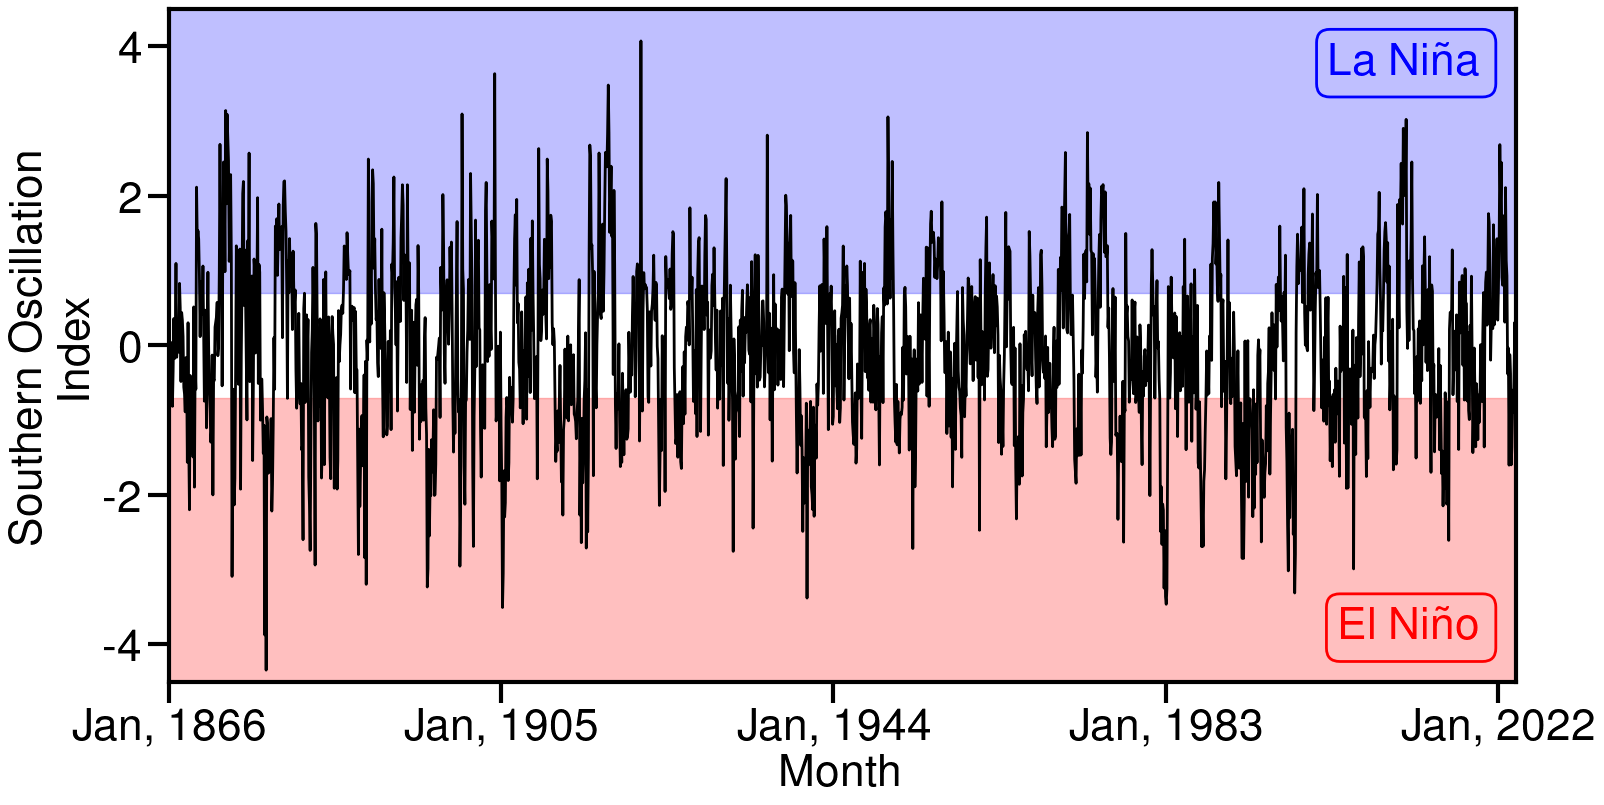

In [18]:
fontsize = 32

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig, ax = plt.subplots(1,1,figsize=(16, 8))


def draw_brace(ax, xspan, yy, text, lw=3):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=lw, clip_on=False)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom', fontsize=fontsize)


# ax.plot(soi,'k-',ms=10,lw=2)
ax.plot(soi,'-',color='k',ms=10,lw=2,zorder=2)

# ylim = ax.get_ylim()
ylim = [-4.5,4.5]
ax.set_ylim(ylim)

ax.fill_between([0, len(soi)-1],[.7]*2,[ylim[1]]*2,color='b',alpha=0.25,zorder=1)
ax.fill_between([0, len(soi)-1],[-.7]*2,[ylim[0]]*2,color='r',alpha=0.25,zorder=1)

ax.annotate(r'La Ni\~na', (.975,.95), xycoords='axes fraction', ha='right', va='top',
             fontsize=fontsize, c='b',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='b',lw=2))
ax.annotate(r'El Ni\~no', (.975,.05), xycoords='axes fraction', ha='right', va='bottom',
             fontsize=fontsize, c='r',
             bbox=dict(boxstyle='round,pad=0.3',fc='none',ec='r',lw=2))

# ax.text(0.2,corr_dim+0.05,r'True $D_C = '+'{:5.4f}'.format(corr_dim)+'$',fontsize=fontsize)

# ax.set_xlim(0,len(predicted))
# ax.set_ylim(0.8,2.6)

# first_year = int(date_strings[0].split(' ')[1])
# last_year = int(date_strings[-1].split(' ')[1])
# num_ticks = 5
# xticklabels = np.arange(first_year,last_year,int((last_year-first_year)/num_ticks))
# ax.set_xlim(len_train,len(soi))
ax.set_xlim(0,len(soi))

# locator = plt.MaxNLocator(5)
# ax.xaxis.set_major_locator(locator)

# xticks = ax.get_xticks().astype(int)[:-1]

xticks = np.arange(0,len(dates),len(dates)//4//12*12)
xticklabels = [dates[xtick] for xtick in xticks]

# xticks = [(xticklabel - first_year)*12 for xticklabel in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, fontsize=fontsize, rotation=0, ha='center')

ax.set_yticks([-4,-2,0,2,4])
ax.set_yticklabels([-4,-2,0,2,4])

# ax.set_xlabel(r'Year',fontsize=fontsize)
ax.set_ylabel('Southern Oscillation\nIndex',fontsize=fontsize)

# left_date = 'Jan, 2012'


# ax.set_xlim(date_strings.index(left_date), len(soi))

# num_ticks = 9
# xticks = np.linspace(date_strings.index(left_date),len(soi),num_ticks)
# ax.set_xticks(xticks)

# xticks = ax.get_xticks()
# xticklabels = [format_date(index_to_date_num(int(xtick)-date_strings.index(left_date),
#                int(left_date.split(',')[1]),months.index(left_date.split(',')[0]))) for xtick in xticks]
# ax.set_xticklabels(xticklabels, rotation=30, ha='center', fontsize=fontsize)

ax.set_xlabel('Month',fontsize=fontsize)


# draw_brace(ax, (0,len_train), ax.get_ylim()[-1], 'Training', lw=3)
# draw_brace(ax, (len_train,len(soi)), ax.get_ylim()[-1], 'Testing', lw=3)
# ax.axvline(len_train, c='k', ls='--', lw=3)
# ax.annotate('Jan, 1984', xytext=(len_train-0.01*len(soi),ax.get_ylim()[-1]-0.025*np.diff(ax.get_ylim())[0]),
#             textcoords='data', fontsize=fontsize, ha='right', va='top',
#             xy=(len_train,ax.get_ylim()[-1]-0.15*np.diff(ax.get_ylim())[0]),
#             xycoords='data', arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.3", lw=2))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
ax.tick_params(length=15,width=3)
plt.setp(ax.spines.values(), linewidth=3, zorder=10)

title = 'Raw SOI Data (No Braces)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.svg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

## RC

In [21]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

In [22]:
rpy.verbosity(0)

0

In [97]:
num_runs = 20
leads = [1,3,6,12]
y_preds_RC = []
runtimes_RC = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_RC.append([None]*num_runs)
    runtimes_RC.append([None]*num_runs)

    X, y = lead_data(soi, lead=lead)
    X_train = X[:len_train-lead+1]
    X_test = X[len_train-lead+1:]
    y_train = y[:len_train-lead+1]
    y_test = y[len_train-lead+1:]

    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        units = 100
        leak_rate = 0.3
        spectral_radius = 1.1
        input_scaling = 1.0
        connectivity = 0.5
        input_connectivity = 1.0
        regularization = 1e-6
    #     seed = 1234

        reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                  lr=leak_rate, rc_connectivity=connectivity,
                                  input_connectivity=input_connectivity)
        readout = Ridge(X_train.shape[1], ridge=regularization)

        model = reservoir >> readout

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        y_train_scaled = scaler.transform(y_train)
        X_test_scaled = scaler.transform(X_test)
        y_test_scaled = scaler.transform(y_test)

        rc = model.fit(X_train_scaled, y_train_scaled)





        seed_timesteps = 100

        warming_inputs = X_train_scaled[-seed_timesteps:]

        warming_out = rc.run(warming_inputs, reset=True)  # warmup

        nb_generations = len(X_test_scaled)

        y_pred = np.zeros((nb_generations, X_test_scaled.shape[1]))
        y_warm = X_test_scaled[0]#warming_out[-1]
        for i in range(nb_generations):  # generation
            y_warm = rc(y_warm)
            y_pred[i, :] = y_warm
            y_warm = y_test_scaled[i]

        y_pred = scaler.inverse_transform(y_pred)
        end_time = time.time()


        y_preds_RC[i_lead][i_run] = y_pred
        runtimes_RC[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_RC[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_RC[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.9190302138213544 0.2624745258105707


  0%|          | 0/20 [00:00<?, ?it/s]

3 1.0375999217095515 0.17953054940799934


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.1281549613201274 0.12161016595727088


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.3570560521091193 0.09814535949004316


## NG-RC

In [29]:
num_runs = 20
leads = [1,3,6,12]
y_preds_NGRC = []
runtimes_NGRC = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_NGRC.append([None]*num_runs)
    runtimes_NGRC.append([None]*num_runs)

    X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)


    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        # discrete-time versions of the times defined above
        warmup_pts=100
        traintime_pts=len(X_train)-warmup_pts
        warmtrain_pts=warmup_pts+traintime_pts
        testtime_pts=len(X_test)
        maxtime_pts=len(X_train)+len(X_test)#+warmup_pts
        # plottime_pts=round(plottime/dt)
        # lyaptime_pts=round(lyaptime/dt)

        # input dimension
        d = 1
        # number of time delay taps
        k = 1*12
        # size of linear part of feature vector
        dlin = k*d
        # size of nonlinear part of feature vector
        dnonlin = int(dlin*(dlin+1)/2)
        # total size of feature vector: constant + linear + nonlinear
        dtot = 1 + dlin + dnonlin

        # ridge parameter for regression
        ridge_param = 1e-4

        # t values for whole evaluation time
        # (need maxtime_pts + 1 to ensure a step of dt)
        # t_eval=np.linspace(0,maxtime,maxtime_pts+1)


        ##
        ## NVAR
        ##

        # create an array to hold the linear part of the feature vector
        x = np.zeros((dlin,maxtime_pts))

        # fill in the linear part of the feature vector for all times
        for delay in range(k):
            for j in range(delay,maxtime_pts):
                x[d*delay:d*(delay+1),j]=soi[j-delay,:]

        # create an array to hold the full feature vector for training time
        # (use ones so the constant term is already 1)
        out_train = np.ones((dtot,traintime_pts))

        # copy over the linear part (shift over by one to account for constant)
        out_train[1:dlin+1,:]=x[:,warmup_pts-lead:warmtrain_pts-lead]

        # fill in the non-linear part
        cnt=0
        for row in range(dlin):
            for column in range(row,dlin):
                # shift by one for constant
                out_train[dlin+1+cnt]=x[row,warmup_pts-lead:warmtrain_pts-lead]*x[column,warmup_pts-lead:warmtrain_pts-lead]
                cnt += 1

        # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
        W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-lead:warmtrain_pts-lead]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))




        X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
        # print(X_train.shape, X_test.shape)



        y_pred = np.zeros(y_test.shape)


        for i in range(len(y_pred)):
            x_test = soi[len(X_train)-dlin-lead+2+i:len(X_train)-lead+2+i].T.flatten()[::-1]


            # create a place to store feature vectors for prediction
            out_test = np.zeros(dtot)   # full feature vector
            # x_test = np.zeros((dlin))   # linear part


            # copy linear part into whole feature vector
            out_test[1:dlin+1]=x_test # shift by one for constant
            # fill in the non-linear part
            cnt=0
            for row in range(dlin):
                for column in range(row,dlin):
                    # shift by one for constant
                    out_test[dlin+1+cnt]=x_test[row]*x_test[column]
                    cnt += 1

            # fill in the delay taps of the next state
            x_test[d:dlin]=x_test[0:(dlin-d)]
            # do a prediction
            x_test[0:d] = x_test[0:d]+W_out @ out_test[:]


            y_pred[i] = x_test[0]

        # test_RMSE = RMSE_summary(y_pred, y_test)
        # test_PCC = PCC_summary(y_pred, y_test)
        # print(lead, test_RMSE, test_PCC)
        end_time = time.time()


        y_preds_NGRC[i_lead][i_run] = y_pred
        runtimes_NGRC[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_NGRC[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_NGRC[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8769650040393049 0.28030880691484883


  0%|          | 0/20 [00:00<?, ?it/s]

3 0.9973115380904064 0.1751065990473943


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.108978378604348 0.13821067767405001


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.194851665208867 0.0950714552468855


## LSTM

In [30]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, (h_n, c_n) = self.lstm(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, (h_n, c_n) = self.lstm(out.reshape(1,-1), (h_n, c_n))
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [32]:
tc.backends.cuda.matmul.allow_tf32 = True
tc.backends.cudnn.allow_tf32 = True

In [33]:
tc.set_default_dtype(tc.float)

In [51]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_LSTM = []
runtimes_LSTM = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_LSTM.append([None]*num_runs)
    runtimes_LSTM.append([None]*num_runs)

    X, y = lead_data(soi, lead=lead)
    X_train = X[:len_train-lead+1]
    X_test = X[len_train-lead+1:]
    y_train = y[:len_train-lead+1]
    y_test = y[len_train-lead+1:]

    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        k_LSTM = 1*12
        n = len(X_train)-k_LSTM-1

        features, _ = make_features_and_labels(X_train[:-1],k_LSTM,lead=lead)
        labels, _ = make_features_and_labels(X_train[1:],k_LSTM,lead=lead)


        N = X_train.shape[1]



        num_epochs = 100
        batch_size = 10
        warmup = 100
        dropout = 0.2
        num_layers = 2
        hidden_size = 20

        scaler = StandardScaler()
        scaler = scaler.fit(features)

        X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
        y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

        X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_LSTM, lead=lead)[0]), device=device, dtype=tc.float)


        model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device)

        loss_fn = nn.MSELoss() #nn.MSELoss()
        # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
        optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

        start = 1e9
        scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

        model.to(device)

        model.train()

        train_losses = np.zeros((num_epochs,))
        test_RMSEs = np.zeros((num_epochs,))
        test_PCCs = np.zeros((num_epochs,))

        test_RMSE = 1e9
        for epoch in range(num_epochs):#, leave=False):
            model.train()
            for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
            if epoch > start:
                scheduler.step()
            model.eval()
            with tc.no_grad():
                y_out = model(X_test_tensor_w_warmup)
                y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_LSTM)), (0,2,1))[warmup-k_LSTM-lead+1:, -1, :]

        model.eval()
        end_time = time.time()


        y_preds_LSTM[i_lead][i_run] = y_pred
        runtimes_LSTM[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_LSTM[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_LSTM[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8913993747810615 0.2912085415106299


  0%|          | 0/20 [00:00<?, ?it/s]

3 1.0865776840430632 0.1356449952394942


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.284936171666069 0.09647009325651673


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.348677054401035 0.10938703031693912


## RNN

In [35]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [36]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        # self.rnn = nn.RNNCell(input_dim, hidden_dim, nonlinearity='tanh')
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, h_n = self.rnn(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, h_n = self.rnn(out.reshape(1,-1), h_n)
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [37]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_RNN = []
runtimes_RNN = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_RNN.append([None]*num_runs)
    runtimes_RNN.append([None]*num_runs)

    X, y = lead_data(soi, lead=lead)
    X_train = X[:len_train-lead+1]
    X_test = X[len_train-lead+1:]
    y_train = y[:len_train-lead+1]
    y_test = y[len_train-lead+1:]

    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        k_RNN = 1*12
        n = len(X_train)-k_RNN-1

        features, _ = make_features_and_labels(X_train[:-1],k_RNN,lead=lead)
        labels, _ = make_features_and_labels(X_train[1:],k_RNN,lead=lead)


        N = X_train.shape[1]



        num_epochs = 100
        batch_size = 10
        warmup = 100
        dropout = 0.2
        num_layers = 2
        hidden_size = 20

        scaler = StandardScaler()
        scaler = scaler.fit(features)

        X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
        y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

        X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_RNN, lead=lead)[0]), device=device, dtype=tc.float)


        model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device)

        loss_fn = nn.MSELoss() #nn.MSELoss()
        # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
        optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

        start = 1e9
        scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

        model.to(device)

        model.train()

        train_losses = np.zeros((num_epochs,))
        test_RMSEs = np.zeros((num_epochs,))
        test_PCCs = np.zeros((num_epochs,))

        test_RMSE = 1e9
        for epoch in range(num_epochs):#, leave=False):
            model.train()
            for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                optimizer.zero_grad()
                loss.backward()
                # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
            if epoch > start:
                scheduler.step()
            model.eval()
            with tc.no_grad():
                y_out = model(X_test_tensor_w_warmup)
                y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_RNN)), (0,2,1))[warmup-k_RNN-lead+1:, -1, :]

        model.eval()
        end_time = time.time()


        y_preds_RNN[i_lead][i_run] = y_pred
        runtimes_RNN[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_RNN[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_RNN[i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8840364740651315 0.2940991602944941


  0%|          | 0/20 [00:00<?, ?it/s]

3 1.0913277570432864 0.12896430817139964


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.2840937047094505 0.09527501835322152


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.3413951245966533 0.10213845057354017


## TreeDOX

In [19]:
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


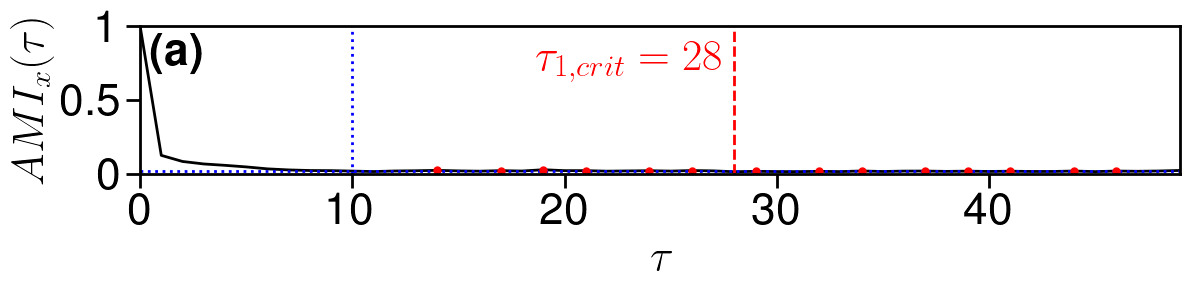

In [20]:
tau_crits = get_tau_crits(X_train, p_val=0.5, max_lag=50, make_plot=True, incorporate_peaks=True)

In [21]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

num_runs = 20
leads = [1,3,6,12]
y_preds_TreeDOX = []
runtimes_TreeDOX = []
for i_lead in trange(len(leads)):
    lead = leads[i_lead]
    y_preds_TreeDOX.append([None]*num_runs)
    runtimes_TreeDOX.append([None]*num_runs)
    
    X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
    
#     X, y = lead_data(soi, lead=lead)
#     X_train = X[:len_train-lead+1]
#     X_test = X[len_train-lead+1:]
#     y_train = y[:len_train-lead+1]
#     y_test = y[len_train-lead+1:]

    features, labels = make_features_and_labels(X_train, k+lead-1, xi=xi, stride=1, lead=lead)
    # print(features.shape, labels.shape)
    
    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=50,
                                                    max_depth=None, random_state=None,
                                                    n_jobs=-1, n_samples=None,
                                                    model_type='ETR', return_model=True)
        all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])
        
#         if i_run == 0:
#             print(len(np.where(FIs >= np.median(FIs))[0]))

        y_pred, model, time_elapsed = future_prediction_lead(features, labels, all_FIs,
                                                             len(y_test), lead=lead,
                                                             p=None, xi=xi,
                                                             n_estimators=200,
                                                             disp_progress=False,
                                                             desc=str(lead),
                                                             leave=False,
                                                             max_depth=None,
                                                             random_state=None,
                                                             n_jobs=-1,
                                                             min_samples_split=2,
                                                             min_samples_leaf=1,
                                                             ccp_alpha=0,
                                                             max_features=1.0,
                                                             n_samples=None,
                                                             model=None,
                                                             y_train=y_train,
                                                             y_test=y_test,
                                                             model_type='ETR',
                                                             verbose=False,
                                                             open_loop=True,
                                                             model_conversion=None,
                                                             device='cuda')
        end_time = time.time()
        y_preds_TreeDOX[i_lead][i_run] = y_pred
        runtimes_TreeDOX[i_lead][i_run] = end_time - start_time
    print(lead, np.mean([RMSE_summary(y_preds_TreeDOX[i_lead][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_TreeDOX[i_lead][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 29


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

1 0.8960349514178623 0.1385309865648216


  0%|          | 0/20 [00:00<?, ?it/s]

3 0.9983360915018483 0.0868077908544794


  0%|          | 0/20 [00:00<?, ?it/s]

6 1.1279390956202104 0.060947131620344895


  0%|          | 0/20 [00:00<?, ?it/s]

12 1.1933102694394702 0.04751750586870036


## Plots

In [79]:
with gzip.open(data_dir + 'SOI_results.data', 'wb') as file:
    for var in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX,
                runtimes_RNN, runtimes_LSTM, runtimes_RC, runtimes_NGRC, runtimes_TreeDOX]:
        pkl.dump(var, file)

In [10]:
leads = [1,3,6,12]
with gzip.open(data_dir + 'SOI_results.data', 'rb') as file:
    for name in ['y_preds_RNN', 'y_preds_LSTM', 'y_preds_RC', 'y_preds_NGRC', 'y_preds_TreeDOX',
               'runtimes_RNN', 'runtimes_LSTM', 'runtimes_RC', 'runtimes_NGRC', 'runtimes_TreeDOX']:
        globals()[name] = pkl.load(file)

In [22]:
soi_rmse = [[[RMSE_summary(y_preds[i_lead][i_run], y_test) for i_run in range(len(y_preds[i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX]]
soi_pcc = [[[PCC_summary(y_preds[i_lead][i_run], y_test) for i_run in range(len(y_preds[i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX]]
soi_ami = [[[AMI_summary(y_preds[i_lead][i_run], y_test) for i_run in range(len(y_preds[i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN, y_preds_LSTM, y_preds_RC, y_preds_NGRC, y_preds_TreeDOX]]
soi_runtimes = [[[runtimes[i_lead][i_run] for i_run in range(len(runtimes[i_lead]))] for i_lead in range(len(leads))] for runtimes in [runtimes_RNN, runtimes_LSTM, runtimes_RC, runtimes_NGRC, runtimes_TreeDOX]]

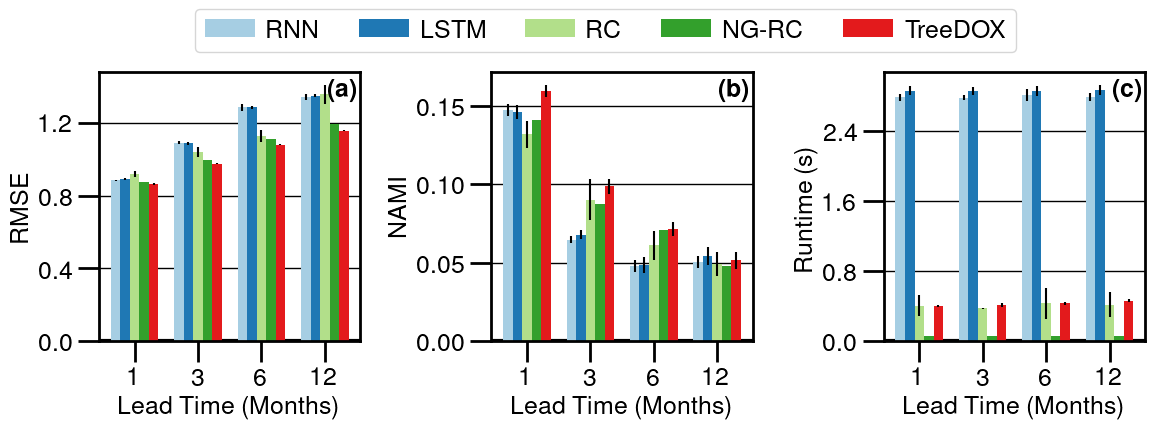

In [57]:
fname = 'SOI-TreeDOX_vs_RNN_LSTM_RC_NG-RC_horizontal2'

fontsize = 18
legendfontsize = 18

annotate_xy = (1-0.01,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['soi_rmse', 'soi_ami', 'soi_runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.1f', '.2f', '.1f']

fig, axs = plt.subplots(1,len(var_names),figsize=(4.5*len(var_names),3.5), sharex=True)
plt.subplots_adjust(wspace=0.5, hspace=0.15)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

x = np.arange(len(soi_rmse[0]))
width = 1.0/(len(labels)+1)*.9

xlim_stretch = 0.0

for i_var in range(len(var_names)):
    ax = axs[i_var]

    var = globals()[var_names[i_var]]

    for i_label, label in enumerate(labels):
        offset = width*i_label
        rects = ax.bar(x+offset, np.mean(var[i_label], axis=1), width, label=label, color=color_lst[i_label], zorder=10)
        ax.errorbar(x+offset, np.mean(var[i_label], axis=1), yerr=np.std(var[i_label], axis=1), fmt='none', color='k', zorder=20)
        # ax.bar_label(rects, padding=3)

    ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    # if i_var == len(var_names)-1:
    ax.set_xlabel('Lead Time (Months)', fontsize=fontsize)
    ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
    ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})

#     if i_var == len(var_names)-1:
    ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    xlim = ax.get_ylim()
    ax.set_ylim(xlim[0], xlim[1] + xlim_stretch*np.diff(xlim))
#     if i_var == 0:
    xticks = ax.get_yticks()[:-1]
#     else:
#         yticks = ax.get_xticks()[1:-1]
    ax.set_yticks(xticks)
    ax.set_yticklabels(f'{xtick:{fmts[i_var]}}' for xtick in xticks)
    
    plt.setp(ax.spines.values(), linewidth=2, zorder=100)
    ax.tick_params(length=15,width=2)
    
    ax.yaxis.grid(True, c='k', lw=1, zorder=0)
    
    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='right', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=100)

    if i_var == 0:
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles, leg_labels, loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                      columnspacing=1.5,handletextpad=0.5)

def LegendVertical(Ax, Rotation=90, XPad=0, YPad=0, Handles=None, Labels=None, **LegendArgs):
    if Rotation not in (90,270):
        raise NotImplementedError('Rotation must be 90 or 270.')

    # Extra spacing between labels is needed to fit the rotated labels;
    # and since the frame will not adjust to the rotated labels, it is
    # disabled by default
    DefaultLoc = 'center left' if Rotation==90 else 'center right'
    ArgsDefaults = dict(loc=DefaultLoc, labelspacing=4, frameon=False)
    Args = {**ArgsDefaults, **LegendArgs}

    if Handles is None or Labels is None:
        Handles, Labels = Ax.get_legend_handles_labels()
    if Rotation==90:
        # Reverse entries
        Handles, Labels = (reversed(_) for _ in (Handles, Labels))
    AxLeg = Ax.legend(Handles, Labels, **Args)

    LegTexts = AxLeg.get_texts()
    LegHandles = AxLeg.legend_handles

    for L,Leg in enumerate(LegHandles):
        if type(Leg) == mpl.patches.Rectangle:
            BBounds = np.ravel(Leg.get_bbox())
            BBounds[2:] = BBounds[2:][::-1]
            Leg.set_bounds(BBounds)

            LegPos = (
                # Ideally,
                #    `(BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad`
                # should be at the horizontal center of the legend patch,
                # but for some reason it is not. Therefore the user will
                # need to specify some padding.
                (BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad + XPad,

                # Similarly, `(BBounds[1]+BBounds[3])` should be at the vertical
                # top of the legend patch, but it is not.
                (BBounds[1]+BBounds[3])+YPad
            )

        elif type(Leg) == mpl.lines.Line2D:
            LegXY = Leg.get_xydata()[:,::-1]
            Leg.set_data(*(LegXY[:,_] for _ in (0,1)))

            LegPos = (
                LegXY[0,0] - AxLeg.handletextpad + XPad,
                max(LegXY[:,1]) + YPad
            )

        elif type(Leg) == mpl.collections.PathCollection:
            LegPos = (
                Leg.get_offsets()[0][0] + XPad,
                Leg.get_offsets()[0][1] + YPad,
            )
        else:
            raise NotImplementedError('Legends should contain Rectangle, Line2D or PathCollection.')

        PText = LegTexts[L]
        PText.set_verticalalignment('bottom')
        PText.set_rotation(Rotation)
        PText.set_x(LegPos[0])
        PText.set_y(LegPos[1])

def legendAsLatex(axes, rotation=90) :
    '''Generate a latex code to be used instead of the legend. 
       Uses the label, color, marker and linestyle provided to the pyplot.plot.
       The marker and the linestyle must be defined using the one or two character
           abreviations shown in the help of pyplot.plot.
       Rotation of the markers must be multiple of 90.
    '''
    latexLine = {'-':'\\textbf{\Large ---}',
        '-.':'\\textbf{\Large --\:\!$\\boldsymbol{\cdot}$\:\!--}',
        '--':'\\textbf{\Large --\,--}',':':'\\textbf{\Large -\:\!-}'}
    latexSymbol = {'o':'medbullet', 'd':'diamond', 's':'filledmedsquare',
        'D':'Diamondblack', '*':'bigstar', '+':'boldsymbol{\plus}',
        'x':'boldsymbol{\\times}', 'p':'pentagon', 'h':'hexagon',
        ',':'boldsymbol{\cdot}', '_':'boldsymbol{\minus}','<':'LHD',
        '>':'RHD','v':'blacktriangledown', '^':'blacktriangle'} 
    rot90=['^','<','v','>']
    di = [0,-1,2,1][rotation%360//90]
    latexSymbol.update({rot90[i]:latexSymbol[rot90[(i+di)%4]] for i in range(4)})
#     return ', '.join(['\\textcolor[rgb]{'\
#             + ','.join([str(x) for x in mpl.colors.to_rgb(handle.get_color())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
#                 for handle,label in zip(*axes.get_legend_handles_labels())])
    return ', '.join(['\\textcolor[rgb]{'\
            + ','.join([str(x) for x in mpl.colors.to_rgb(list(handle)[0].get_facecolor())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
            + label + '} '# + label
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
                for handle,label in zip(*axes.get_legend_handles_labels())])
        
# #     if i_var == 0:
# leg_handles, leg_labels = axs[0].get_legend_handles_labels()
# # ax_tmp = axs[1].twinx()
# # ax_tmp.set_ylabel(legendAsLatex(axs[1]), fontsize=fontsize, labelpad=10)
# # plt.setp(ax_tmp.get_yticklabels(), visible=False)
# # ax_tmp.tick_params(bottom=False, top=False, left=False, right=False)
# LegendVertical(axs[2], Rotation=270, XPad=-50.5, YPad=5, Handles=leg_handles, Labels=[f'{l:<10}' for l in leg_labels], prop={'size': legendfontsize},
#                loc='lower center', bbox_to_anchor=(1.2,-.085), columnspacing=-2, handletextpad=0.25, ncol=1,
#                labelspacing=4, reverse=False)
# axs[2].add_patch(mpl.patches.FancyBboxPatch((1.05, 0.0), .101, 3.295, transform=axs[2].transAxes, linewidth=1,
#                                             edgecolor='lightgray', facecolor='none', clip_on=False,
#                                             boxstyle=mpl.patches.BoxStyle("Round, pad=0.01, rounding_size=0.01")))

# LegendVertical(axs[2], Rotation=270, XPad=-40, YPad=-40, Handles=leg_handles, Labels=[f'{l:<10}' for l in leg_labels], prop={'size': legendfontsize},
#                loc='lower center', bbox_to_anchor=(1.2,-.055), columnspacing=-2, handletextpad=0.25, ncol=1,
#                labelspacing=3.5, reverse=False)
# fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=2,#len(labels),
#               columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

fig.align_labels(axs)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

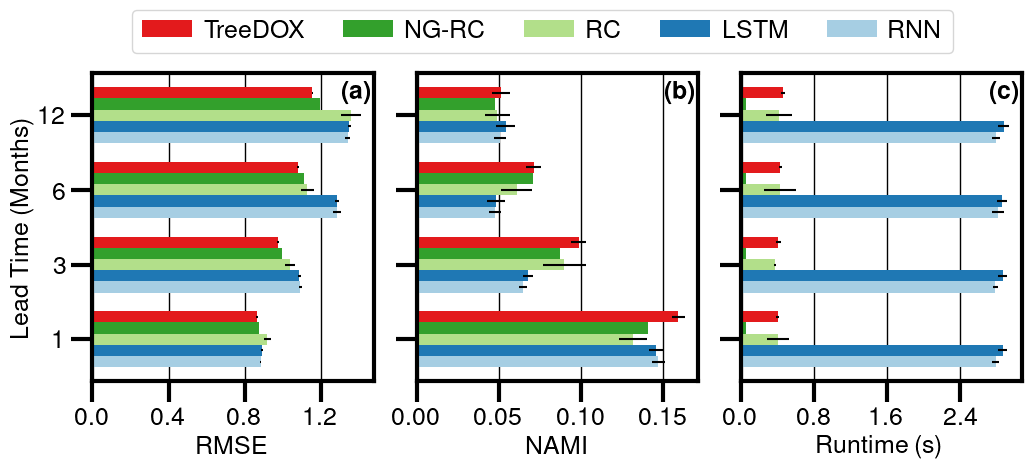

In [59]:
fname = 'SOI-TreeDOX_vs_RNN_LSTM_RC_NG-RC_horizontal'

fontsize = 18
legendfontsize = 18

annotate_xy = (1-0.01,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['soi_rmse', 'soi_ami', 'soi_runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.1f', '.2f', '.1f']

fig, axs = plt.subplots(1,len(var_names),figsize=(4*len(var_names),4), sharey=True)
plt.subplots_adjust(wspace=0.15, hspace=0.25)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

x = np.arange(len(soi_rmse[0]))
width = 1.0/(len(labels)+1)*.9

xlim_stretch = 0.0

for i_var in range(len(var_names)):
    ax = axs[i_var]

    var = globals()[var_names[i_var]]

    for i_label, label in enumerate(labels):
        offset = width*i_label
        rects = ax.barh(x+offset, np.mean(var[i_label], axis=1), width, label=label, color=color_lst[i_label], zorder=10)
        ax.errorbar(np.mean(var[i_label], axis=1), x+offset, xerr=np.std(var[i_label], axis=1), fmt='none', color='k', zorder=20)
        # ax.bar_label(rects, padding=3)

    ax.axvline(0,ls='-',c='k',lw=3,zorder=0)

    if i_var == 0:
        ax.set_ylabel('Lead Time (Months)', fontsize=fontsize)
    ax.set_xlabel(var_labels[i_var], fontsize=fontsize)
    ax.set_yticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    ax.set_yticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='right')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})

#     if i_var == 0:
    ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1] + xlim_stretch*np.diff(xlim))
#     if i_var == 0:
    xticks = ax.get_xticks()[:-1]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_xticks(xticks)
    ax.set_xticklabels(f'{xtick:{fmts[i_var]}}' for xtick in xticks)
    
    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)
    
    ax.xaxis.grid(True, c='k', lw=1, zorder=0)
    
    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='right', va='top', xycoords="axes fraction",fontsize=fontsize)

    if i_var == 0:
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::-1], leg_labels[::-1], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                      columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)
/
plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

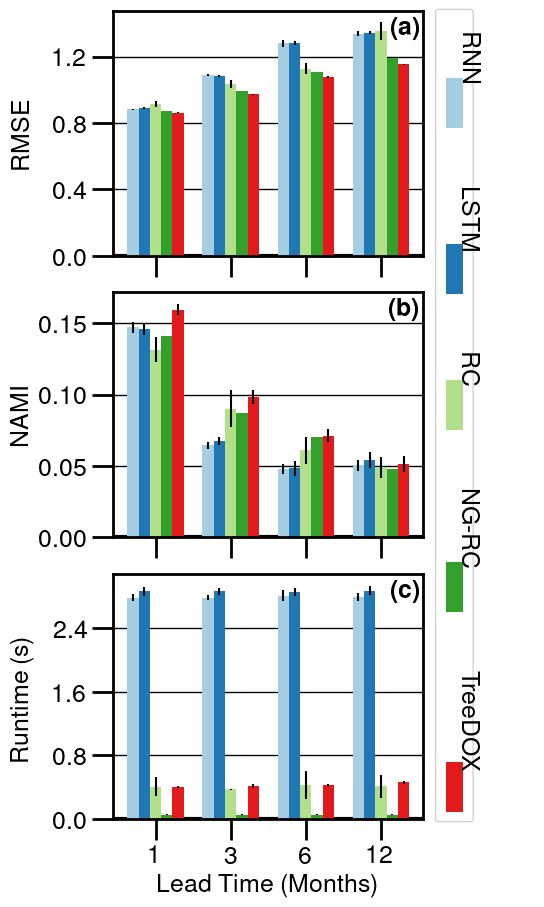

In [83]:
fname = 'SOI-TreeDOX_vs_RNN_LSTM_RC_NG-RC_vertical'

fontsize = 18
legendfontsize = 18

annotate_xy = (1-0.01,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['soi_rmse', 'soi_ami', 'soi_runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.1f', '.2f', '.1f']

fig, axs = plt.subplots(len(var_names),1,figsize=(4,3.5*len(var_names)), sharex=True)
plt.subplots_adjust(wspace=0.15, hspace=0.15)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

x = np.arange(len(soi_rmse[0]))
width = 1.0/(len(labels)+1)*.9

xlim_stretch = 0.0

for i_var in range(len(var_names)):
    ax = axs[i_var]

    var = globals()[var_names[i_var]]

    for i_label, label in enumerate(labels):
        offset = width*i_label
        rects = ax.bar(x+offset, np.mean(var[i_label], axis=1), width, label=label, color=color_lst[i_label], zorder=10)
        ax.errorbar(x+offset, np.mean(var[i_label], axis=1), yerr=np.std(var[i_label], axis=1), fmt='none', color='k', zorder=20)
        # ax.bar_label(rects, padding=3)

    ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    if i_var == len(var_names)-1:
        ax.set_xlabel('Lead Time (Months)', fontsize=fontsize)
    ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
    ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})

#     if i_var == len(var_names)-1:
    ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    xlim = ax.get_ylim()
    ax.set_ylim(xlim[0], xlim[1] + xlim_stretch*np.diff(xlim))
#     if i_var == 0:
    xticks = ax.get_yticks()[:-1]
#     else:
#         yticks = ax.get_xticks()[1:-1]
    ax.set_yticks(xticks)
    ax.set_yticklabels(f'{xtick:{fmts[i_var]}}' for xtick in xticks)
    
    plt.setp(ax.spines.values(), linewidth=2, zorder=100)
    ax.tick_params(length=15,width=2)
    
    ax.yaxis.grid(True, c='k', lw=1, zorder=0)
    
    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='right', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=100)

def LegendVertical(Ax, Rotation=90, XPad=0, YPad=0, Handles=None, Labels=None, **LegendArgs):
    if Rotation not in (90,270):
        raise NotImplementedError('Rotation must be 90 or 270.')

    # Extra spacing between labels is needed to fit the rotated labels;
    # and since the frame will not adjust to the rotated labels, it is
    # disabled by default
    DefaultLoc = 'center left' if Rotation==90 else 'center right'
    ArgsDefaults = dict(loc=DefaultLoc, labelspacing=4, frameon=False)
    Args = {**ArgsDefaults, **LegendArgs}

    if Handles is None or Labels is None:
        Handles, Labels = Ax.get_legend_handles_labels()
    if Rotation==90:
        # Reverse entries
        Handles, Labels = (reversed(_) for _ in (Handles, Labels))
    AxLeg = Ax.legend(Handles, Labels, **Args)

    LegTexts = AxLeg.get_texts()
    LegHandles = AxLeg.legend_handles

    for L,Leg in enumerate(LegHandles):
        if type(Leg) == mpl.patches.Rectangle:
            BBounds = np.ravel(Leg.get_bbox())
            BBounds[2:] = BBounds[2:][::-1]
            Leg.set_bounds(BBounds)

            LegPos = (
                # Ideally,
                #    `(BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad`
                # should be at the horizontal center of the legend patch,
                # but for some reason it is not. Therefore the user will
                # need to specify some padding.
                (BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad + XPad,

                # Similarly, `(BBounds[1]+BBounds[3])` should be at the vertical
                # top of the legend patch, but it is not.
                (BBounds[1]+BBounds[3])+YPad
            )

        elif type(Leg) == mpl.lines.Line2D:
            LegXY = Leg.get_xydata()[:,::-1]
            Leg.set_data(*(LegXY[:,_] for _ in (0,1)))

            LegPos = (
                LegXY[0,0] - AxLeg.handletextpad + XPad,
                max(LegXY[:,1]) + YPad
            )

        elif type(Leg) == mpl.collections.PathCollection:
            LegPos = (
                Leg.get_offsets()[0][0] + XPad,
                Leg.get_offsets()[0][1] + YPad,
            )
        else:
            raise NotImplementedError('Legends should contain Rectangle, Line2D or PathCollection.')

        PText = LegTexts[L]
        PText.set_verticalalignment('bottom')
        PText.set_rotation(Rotation)
        PText.set_x(LegPos[0])
        PText.set_y(LegPos[1])

def legendAsLatex(axes, rotation=90) :
    '''Generate a latex code to be used instead of the legend. 
       Uses the label, color, marker and linestyle provided to the pyplot.plot.
       The marker and the linestyle must be defined using the one or two character
           abreviations shown in the help of pyplot.plot.
       Rotation of the markers must be multiple of 90.
    '''
    latexLine = {'-':'\\textbf{\Large ---}',
        '-.':'\\textbf{\Large --\:\!$\\boldsymbol{\cdot}$\:\!--}',
        '--':'\\textbf{\Large --\,--}',':':'\\textbf{\Large -\:\!-}'}
    latexSymbol = {'o':'medbullet', 'd':'diamond', 's':'filledmedsquare',
        'D':'Diamondblack', '*':'bigstar', '+':'boldsymbol{\plus}',
        'x':'boldsymbol{\\times}', 'p':'pentagon', 'h':'hexagon',
        ',':'boldsymbol{\cdot}', '_':'boldsymbol{\minus}','<':'LHD',
        '>':'RHD','v':'blacktriangledown', '^':'blacktriangle'} 
    rot90=['^','<','v','>']
    di = [0,-1,2,1][rotation%360//90]
    latexSymbol.update({rot90[i]:latexSymbol[rot90[(i+di)%4]] for i in range(4)})
#     return ', '.join(['\\textcolor[rgb]{'\
#             + ','.join([str(x) for x in mpl.colors.to_rgb(handle.get_color())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
#                 for handle,label in zip(*axes.get_legend_handles_labels())])
    return ', '.join(['\\textcolor[rgb]{'\
            + ','.join([str(x) for x in mpl.colors.to_rgb(list(handle)[0].get_facecolor())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
            + label + '} '# + label
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
                for handle,label in zip(*axes.get_legend_handles_labels())])
        
#     if i_var == 0:
leg_handles, leg_labels = axs[0].get_legend_handles_labels()
# ax_tmp = axs[1].twinx()
# ax_tmp.set_ylabel(legendAsLatex(axs[1]), fontsize=fontsize, labelpad=10)
# plt.setp(ax_tmp.get_yticklabels(), visible=False)
# ax_tmp.tick_params(bottom=False, top=False, left=False, right=False)
LegendVertical(axs[2], Rotation=270, XPad=-50.5, YPad=5, Handles=leg_handles, Labels=[f'{l:<10}' for l in leg_labels], prop={'size': legendfontsize},
               loc='lower center', bbox_to_anchor=(1.2,-.085), columnspacing=-2, handletextpad=0.25, ncol=1,
               labelspacing=4, reverse=False)
axs[2].add_patch(mpl.patches.FancyBboxPatch((1.05, 0.0), .101, 3.295, transform=axs[2].transAxes, linewidth=1,
                                            edgecolor='lightgray', facecolor='none', clip_on=False,
                                            boxstyle=mpl.patches.BoxStyle("Round, pad=0.01, rounding_size=0.01")))

# LegendVertical(axs[2], Rotation=270, XPad=-40, YPad=-40, Handles=leg_handles, Labels=[f'{l:<10}' for l in leg_labels], prop={'size': legendfontsize},
#                loc='lower center', bbox_to_anchor=(1.2,-.055), columnspacing=-2, handletextpad=0.25, ncol=1,
#                labelspacing=3.5, reverse=False)
# fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=2,#len(labels),
#               columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

fig.align_labels(axs)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

In [99]:
list(leg_handles[0])[0].get_facecolor()

(0.6509803921568629, 0.807843137254902, 0.8901960784313725, 1.0)

# Vary Training Length

## Data

In [30]:
from urllib.request import urlretrieve

In [31]:
urlretrieve('https://crudata.uea.ac.uk/cru/data/soi/soi_3dp.dat', data_dir+'soi_3dp.dat')

('E:/College/Graduate/Semester 1/Time Series Project/SOI_Data/soi_3dp.dat',
 <http.client.HTTPMessage at 0x15310098550>)

In [32]:
soi_df = pd.read_csv(data_dir + 'soi.dat', sep=' ', skipinitialspace=True, names=months+['Annual'])
soi_df

Jan    Feb     Mar     Apr     May     Jun     Jul     Aug     Sep  \
1866 -0.616 -0.117  -0.615  -0.646   0.038  -0.815  -0.345   0.360  -0.176   
1867  0.095 -0.012  -0.091   0.830   0.503  -0.483   0.440   0.340   0.120   
1868 -0.163 -0.337  -1.563   0.303  -1.336  -2.199  -0.402  -1.415  -1.226   
1869 -1.896 -0.264  -0.586   2.117   1.405   1.534   1.422   0.936   0.117   
1870  1.062  0.181  -0.746   0.472  -0.113  -1.103   0.172   0.979  -0.002   
...     ...    ...     ...     ...     ...     ...     ...     ...     ...   
2020  0.010 -0.314  -0.750   0.155   0.707  -1.359   0.437   0.847   0.980   
2021  1.640  1.017  -0.197   0.303   0.487   0.224   1.614   0.273   0.858   
2022  0.338  0.757   1.353   2.686   1.904   2.449   0.910   0.805   1.734   
2023  1.136  0.931  -0.381  -0.034  -1.602  -0.123  -0.382  -1.598  -1.360   
2024  0.307 -1.471 -99.990 -99.990 -99.990 -99.990 -99.990 -99.990 -99.990   

         Oct     Nov     Dec  Annual  
1866   0.072   1.097  -0.159  -0.160  
1867  -0.558  -0.649  -0.889  -0.030  
1868  -1.241  -1.493   0.515  -0.880  
1869   0.852   0.563   0.422   0.552  
1870  -0.578  -0.856  -1.294  -0.152  
...      ...     ...     ...     ...  
2020   0.271   0.853   1.763   0.300  
2021   0.512   1.118   1.427   0.773  
2022   1.725   0.311   2.111   1.424  
2023  -0.599  -0.897  -0.386  -0.441  
2024 -99.990 -99.990 -99.990 -99.990  

[159 rows x 13 columns]

In [33]:
soi, dates = soi_df[months].stack().to_numpy(), soi_df[months].stack().index.to_numpy()
dates = np.array([f'{month}, {year}' for (year, month) in dates])
soi, dates = np.delete(soi, np.where(soi == -99.99)).reshape(-1,1), np.delete(dates, np.where(soi == -99.99))
soi.shape

(1898, 1)

In [34]:
len_train = dates.tolist().index('Jan, 1984')
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


In [35]:
train_sizes = (len_train*np.arange(0.1,1.1,0.1)[:]).astype(int)
print(train_sizes/len_train, np.array(dates)[train_sizes], sep='\n')

[0.09957627 0.19985876 0.29943503 0.39971751 0.5        0.59957627 0.69985876 0.79943503 0.89971751 1.        ]
['Oct, 1877' 'Aug, 1889' 'May, 1901' 'Mar, 1913' 'Jan, 1925' 'Oct, 1936' 'Aug, 1948' 'May, 1960' 'Mar, 1972' 'Jan, 1984']


## RC

In [43]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

In [44]:
rpy.verbosity(0)

0

In [45]:
num_runs = 20
leads = [1,3,6,12]
y_preds_RC_dict = {}
runtimes_RC_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_RC_dict[train_size] = []
    runtimes_RC_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False, desc=str(train_size)):
        lead = leads[i_lead]
        y_preds_RC_dict[train_size].append([None]*num_runs)
        runtimes_RC_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        for i_run in range(num_runs):
            start_time = time.time()
            units = 100
            leak_rate = 0.3
            spectral_radius = 1.1
            input_scaling = 1.0
            connectivity = 0.5
            input_connectivity = 1.0
            regularization = 1e-6
        #     seed = 1234

            reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                                      lr=leak_rate, rc_connectivity=connectivity,
                                      input_connectivity=input_connectivity)
            readout = Ridge(X_train.shape[1], ridge=regularization)

            model = reservoir >> readout

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            y_train_scaled = scaler.transform(y_train)
            X_test_scaled = scaler.transform(X_test)
            y_test_scaled = scaler.transform(y_test)

            rc = model.fit(X_train_scaled, y_train_scaled)





            seed_timesteps = 100

            warming_inputs = X_train_scaled[-seed_timesteps:]

            warming_out = rc.run(warming_inputs, reset=True)  # warmup

            nb_generations = len(X_test_scaled)

            y_pred = np.zeros((nb_generations, X_test_scaled.shape[1]))
            y_warm = X_test_scaled[0]#warming_out[-1]
            for i in range(nb_generations):  # generation
                y_warm = rc(y_warm)
                y_pred[i, :] = y_warm
                y_warm = y_test_scaled[i]

            y_pred = scaler.inverse_transform(y_pred)
            end_time = time.time()


            y_preds_RC_dict[train_size][i_lead][i_run] = y_pred
            runtimes_RC_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_RC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_RC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/10 [00:00<?, ?it/s]

141:   0%|          | 0/4 [00:00<?, ?it/s]

283:   0%|          | 0/4 [00:00<?, ?it/s]

424:   0%|          | 0/4 [00:00<?, ?it/s]

566:   0%|          | 0/4 [00:00<?, ?it/s]

708:   0%|          | 0/4 [00:00<?, ?it/s]

849:   0%|          | 0/4 [00:00<?, ?it/s]

991:   0%|          | 0/4 [00:00<?, ?it/s]

1132:   0%|          | 0/4 [00:00<?, ?it/s]

1274:   0%|          | 0/4 [00:00<?, ?it/s]

1416:   0%|          | 0/4 [00:00<?, ?it/s]

In [47]:
for train_size in train_sizes:
    for i_lead in range(1):
        print(train_size, i_lead, np.mean([AMI_summary(y_preds_RC_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_RC_dict[train_size][i_lead]))]))

141 0 0.11846369083347937
283 0 0.10390446747395446
424 0 0.12837655006965146
566 0 0.1534396875527814
708 0 0.15525725009961427
849 0 0.20745328288343878
991 0 0.22992241732374868
1132 0 0.24678335099543083
1274 0 0.25947682523936805
1416 0 0.26519809485467527


## NG-RC

In [48]:
num_runs = 20
leads = [1,3,6,12]
y_preds_NGRC_dict = {}
runtimes_NGRC_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_NGRC_dict[train_size] = []
    runtimes_NGRC_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False):
        lead = leads[i_lead]
        y_preds_NGRC_dict[train_size].append([None]*num_runs)
        runtimes_NGRC_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]


        for i_run in range(num_runs):
            start_time = time.time()
            # discrete-time versions of the times defined above
            warmup_pts=100
            traintime_pts=len(X_train)-warmup_pts
            warmtrain_pts=warmup_pts+traintime_pts
            testtime_pts=len(X_test)
            maxtime_pts=len(X_train)+len(X_test)#+warmup_pts
            # plottime_pts=round(plottime/dt)
            # lyaptime_pts=round(lyaptime/dt)

            # input dimension
            d = 1
            # number of time delay taps
            k = 1*12
            # size of linear part of feature vector
            dlin = k*d
            # size of nonlinear part of feature vector
            dnonlin = int(dlin*(dlin+1)/2)
            # total size of feature vector: constant + linear + nonlinear
            dtot = 1 + dlin + dnonlin

            # ridge parameter for regression
            ridge_param = 1e-4

            # t values for whole evaluation time
            # (need maxtime_pts + 1 to ensure a step of dt)
            # t_eval=np.linspace(0,maxtime,maxtime_pts+1)


            ##
            ## NVAR
            ##

            # create an array to hold the linear part of the feature vector
            x = np.zeros((dlin,maxtime_pts))

            # fill in the linear part of the feature vector for all times
            for delay in range(k):
                for j in range(delay,maxtime_pts):
                    x[d*delay:d*(delay+1),j]=soi[j-delay,:]

            # create an array to hold the full feature vector for training time
            # (use ones so the constant term is already 1)
            out_train = np.ones((dtot,traintime_pts))

            # copy over the linear part (shift over by one to account for constant)
            out_train[1:dlin+1,:]=x[:,warmup_pts-lead:warmtrain_pts-lead]

            # fill in the non-linear part
            cnt=0
            for row in range(dlin):
                for column in range(row,dlin):
                    # shift by one for constant
                    out_train[dlin+1+cnt]=x[row,warmup_pts-lead:warmtrain_pts-lead]*x[column,warmup_pts-lead:warmtrain_pts-lead]
                    cnt += 1

            # ridge regression: train W_out to map out_train to Lorenz[t] - Lorenz[t - 1]
            W_out = (x[0:d,warmup_pts:warmtrain_pts]-x[0:d,warmup_pts-lead:warmtrain_pts-lead]) @ out_train[:,:].T @ np.linalg.pinv(out_train[:,:] @ out_train[:,:].T + ridge_param*np.identity(dtot))




#             X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
            # print(X_train.shape, X_test.shape)



            y_pred = np.zeros(y_test.shape)


            for i in range(len(y_pred)):
                x_test = soi[len(X_train)-dlin-lead+2+i:len(X_train)-lead+2+i].T.flatten()[::-1]


                # create a place to store feature vectors for prediction
                out_test = np.zeros(dtot)   # full feature vector
                # x_test = np.zeros((dlin))   # linear part


                # copy linear part into whole feature vector
                out_test[1:dlin+1]=x_test # shift by one for constant
                # fill in the non-linear part
                cnt=0
                for row in range(dlin):
                    for column in range(row,dlin):
                        # shift by one for constant
                        out_test[dlin+1+cnt]=x_test[row]*x_test[column]
                        cnt += 1

                # fill in the delay taps of the next state
                x_test[d:dlin]=x_test[0:(dlin-d)]
                # do a prediction
                x_test[0:d] = x_test[0:d]+W_out @ out_test[:]


                y_pred[i] = x_test[0]

            # test_RMSE = RMSE_summary(y_pred, y_test)
            # test_PCC = PCC_summary(y_pred, y_test)
            # print(lead, test_RMSE, test_PCC)
            end_time = time.time()


            y_preds_NGRC_dict[train_size][i_lead][i_run] = y_pred
            runtimes_NGRC_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_NGRC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_NGRC_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [49]:
for train_size in train_sizes:
    for i_lead in range(1):
        print(train_size, i_lead, np.mean([AMI_summary(y_preds_NGRC_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_NGRC_dict[train_size][i_lead]))]))

141 0 0.07897142153930733
283 0 0.07482569626986876
424 0 0.07752766559975871
566 0 0.071622320497865
708 0 0.09766568322332565
849 0 0.09654422387808057
991 0 0.08136195915156427
1132 0 0.08684000178192064
1274 0 0.11552469923745626
1416 0 0.28845891102454263


## LSTM

In [50]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [51]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        # h_n = tc.zeros(1, self.hidden_dim)
        # output = tc.zeros(len(x), self.output_dim)
        # for i in range(len(x)):
        #   out, h_n = self.lstm(x[i:i+1], h_n)
        #   out = self.linear(out)
        #   output[i,:] = out
        # return output
        # h_n = tc.zeros(1, self.hidden_dim)
        # output = tc.zeros(len(x), self.output_dim)
        # for i in range(min(warmup,len(x))):
        #   out, h_n = self.lstm(x[i:i+1], h_n)
        #   out = self.linear(out)
        #   output[i,:] = out

        # # out = x[warmup-1]
        # for i in range(warmup,len(x)):
        #   out, h_n = self.lstm(out.reshape(1,-1), h_n)
        #   out = self.linear(out)
        #   output[i,:] = out
        # return output

        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, (h_n, c_n) = self.lstm(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, (h_n, c_n) = self.lstm(out.reshape(1,-1), (h_n, c_n))
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [52]:
tc.backends.cuda.matmul.allow_tf32 = True
tc.backends.cudnn.allow_tf32 = True

In [53]:
tc.set_default_dtype(tc.float)

In [55]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_LSTM_dict = {}
runtimes_LSTM_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_LSTM_dict[train_size] = []
    runtimes_LSTM_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False, desc=str(train_size)):
        lead = leads[i_lead]
        y_preds_LSTM_dict[train_size].append([None]*num_runs)
        runtimes_LSTM_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        for i_run in range(num_runs):
            start_time = time.time()
            k_LSTM = 1*12
            n = len(X_train)-k_LSTM-1

            features, _ = make_features_and_labels(X_train[:-1],k_LSTM,lead=lead)
            labels, _ = make_features_and_labels(X_train[1:],k_LSTM,lead=lead)

            N = X_train.shape[1]



            num_epochs = 100
            batch_size = 10
            warmup = 100
            dropout = 0.2
            num_layers = 2
            hidden_size = 20

            scaler = StandardScaler()
            scaler = scaler.fit(features)

            X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
            y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

            X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_LSTM, lead=lead)[0]), device=device, dtype=tc.float)


            model = LSTMModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_LSTM, device)
            swa_model = tc.optim.swa_utils.AveragedModel(model)

            loss_fn = nn.MSELoss() #nn.MSELoss()
            # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
            optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)
            optimizer_closed = tc.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=1e-3)

            start = 1e9
            scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)


            model.to(device)

            model.train()

            train_losses = np.zeros((num_epochs,))
            test_RMSEs = np.zeros((num_epochs,))
            test_PCCs = np.zeros((num_epochs,))

            test_RMSE = 1e9
            for epoch in range(num_epochs):#, leave=False):
                model.train()
                for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                    y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                    loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                    optimizer.zero_grad()
                    loss.backward()
                    # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                    optimizer.step()
                if epoch > start:
                    scheduler.step()
                model.eval()
                with tc.no_grad():
                    y_out = model(X_test_tensor_w_warmup)
                    y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_LSTM)), (0,2,1))[warmup-k_LSTM-lead+1:, -1, :]


            model.eval()
            end_time = time.time()


            y_preds_LSTM_dict[train_size][i_lead][i_run] = y_pred
            runtimes_LSTM_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_LSTM_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_LSTM_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/10 [00:00<?, ?it/s]

141:   0%|          | 0/4 [00:00<?, ?it/s]

283:   0%|          | 0/4 [00:00<?, ?it/s]

424:   0%|          | 0/4 [00:00<?, ?it/s]

566:   0%|          | 0/4 [00:00<?, ?it/s]

708:   0%|          | 0/4 [00:00<?, ?it/s]

849:   0%|          | 0/4 [00:00<?, ?it/s]

991:   0%|          | 0/4 [00:00<?, ?it/s]

1132:   0%|          | 0/4 [00:00<?, ?it/s]

1274:   0%|          | 0/4 [00:00<?, ?it/s]

1416:   0%|          | 0/4 [00:00<?, ?it/s]

In [56]:
for train_size in train_sizes:
    for i_lead in range(1):
        print(train_size, i_lead, np.mean([AMI_summary(y_preds_LSTM_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_LSTM_dict[train_size][i_lead]))]))

141 0 0.23722313597864128
283 0 0.2509385988324131
424 0 0.2445278696114682
566 0 0.27599673482334636
708 0 0.2910027569359953
849 0 0.29143378028993294
991 0 0.28882787133699317
1132 0 0.2874972560792525
1274 0 0.2913698772762916
1416 0 0.29352936029053317


## RNN

In [57]:
import torch as tc
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [58]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, warmup, dropout, N, k, device):
        super(RNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.warmup = warmup
        self.dropout = dropout
        self.N = N
        self.k = k

        # self.rnn = nn.RNNCell(input_dim, hidden_dim, nonlinearity='tanh')
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

        self.device = device
    def forward(self, x, future=0):
        output = tc.zeros(len(x)+future,self.output_dim, device=self.device)

        x, h_n = self.rnn(x)
        x = self.linear(x)
        output[:len(x),:] = x

        out = x[-1]
        for i in range(future):
            out1, h_n = self.rnn(out.reshape(1,-1), h_n)
            out1 = self.linear(out1)
            out = tc.hstack((out.reshape((self.N,self.k))[:,1:],out1.reshape((self.N,self.k))[:,-1].reshape(-1,1))).flatten()
            output[len(x)+i,:] = out


        return output

In [59]:
device = tc.device('cuda')

num_runs = 20
leads = [1,3,6,12]
y_preds_RNN_dict = {}
runtimes_RNN_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_RNN_dict[train_size] = []
    runtimes_RNN_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False, desc=str(train_size)):
        lead = leads[i_lead]
        y_preds_RNN_dict[train_size].append([None]*num_runs)
        runtimes_RNN_dict[train_size].append([None]*num_runs)

        X, y = lead_data(soi, lead=lead)
        X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
        X_test = X[len_train-lead+1:]
        y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
        y_test = y[len_train-lead+1:]

        for i_run in range(num_runs):
            start_time = time.time()
            k_RNN = 1*12
            n = len(X_train)-k_RNN-1

            features, _ = make_features_and_labels(X_train[:-1],k_RNN,lead=lead)
            labels, _ = make_features_and_labels(X_train[1:],k_RNN,lead=lead)

            N = X_train.shape[1]



            num_epochs = 100
            batch_size = 10
            warmup = 100
            dropout = 0.2
            num_layers = 2
            hidden_size = 20

            scaler = StandardScaler()
            scaler = scaler.fit(features)

            X_train_tensor = tc.tensor(scaler.transform(features), device=device, dtype=tc.float)
            y_train_tensor = tc.tensor(scaler.transform(labels), device=device, dtype=tc.float)

            X_test_tensor_w_warmup = tc.tensor(scaler.transform(make_features_and_labels(np.vstack((X_train[-warmup:],X_test)), k_RNN, lead=lead)[0]), device=device, dtype=tc.float)


            model = RNNModel(features.shape[1], hidden_size, num_layers, labels.shape[1], warmup, dropout, N, k_RNN, device)
            swa_model = tc.optim.swa_utils.AveragedModel(model)

            loss_fn = nn.MSELoss() #nn.MSELoss()
            # optimizer = tc.optim.Adam(model.parameters(), lr=.000005, weight_decay=1e-3)#, momentum=0.09)
            optimizer = tc.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)
            optimizer_closed = tc.optim.SGD(model.parameters(), lr=0.5, momentum=0.9, weight_decay=1e-3)

            start = 1e9
            scheduler = tc.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)


            model.to(device)

            model.train()

            train_losses = np.zeros((num_epochs,))
            test_RMSEs = np.zeros((num_epochs,))
            test_PCCs = np.zeros((num_epochs,))

            test_RMSE = 1e9
            for epoch in range(num_epochs):#, leave=False):
                model.train()
                for i in range(0, len(X_train_tensor)-batch_size-warmup, batch_size+warmup):
                    y_pred = model(X_train_tensor[i:i+batch_size+warmup])
                    loss = loss_fn(y_pred, y_train_tensor[i:i+batch_size+warmup])
                    optimizer.zero_grad()
                    loss.backward()
                    # nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                    optimizer.step()
                if epoch > start:
                    scheduler.step()
                model.eval()
                with tc.no_grad():
                    y_out = model(X_test_tensor_w_warmup)
                    y_pred = np.transpose(scaler.inverse_transform(y_out.cpu().detach().numpy()).reshape((len(y_out),N,k_RNN)), (0,2,1))[warmup-k_RNN-lead+1:, -1, :]


            model.eval()
            end_time = time.time()


            y_preds_RNN_dict[train_size][i_lead][i_run] = y_pred
            runtimes_RNN_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_RNN_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_RNN_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/10 [00:00<?, ?it/s]

141:   0%|          | 0/4 [00:00<?, ?it/s]

283:   0%|          | 0/4 [00:00<?, ?it/s]

424:   0%|          | 0/4 [00:00<?, ?it/s]

566:   0%|          | 0/4 [00:00<?, ?it/s]

708:   0%|          | 0/4 [00:00<?, ?it/s]

849:   0%|          | 0/4 [00:00<?, ?it/s]

991:   0%|          | 0/4 [00:00<?, ?it/s]

1132:   0%|          | 0/4 [00:00<?, ?it/s]

1274:   0%|          | 0/4 [00:00<?, ?it/s]

1416:   0%|          | 0/4 [00:00<?, ?it/s]

In [60]:
for train_size in train_sizes:
    for i_lead in range(1):
        print(train_size, i_lead, np.mean([AMI_summary(y_preds_RNN_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_RNN_dict[train_size][i_lead]))]))

141 0 0.2829631965911557
283 0 0.27227042668214135
424 0 0.26317961251397404
566 0 0.26374744044218396
708 0 0.27905119314063936
849 0 0.27310199327862494
991 0 0.2776231282960948
1132 0 0.2864321221943203
1274 0 0.288000965425764
1416 0 0.2912416853513186


## TreeDOX

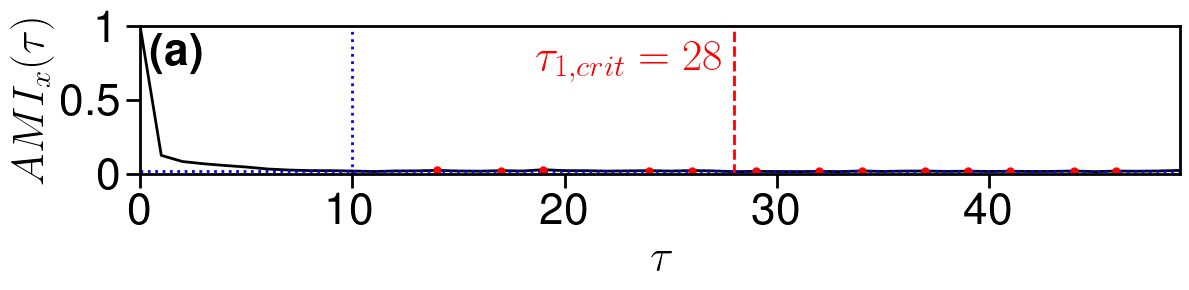

In [61]:
tau_crits = get_tau_crits(X_train, p_val=0.5, max_lag=50, make_plot=True)

In [62]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

num_runs = 20
leads = [1,3,6,12]
y_preds_TreeDOX_dict = {}
runtimes_TreeDOX_dict = {}
for train_size in tqdm(train_sizes):
    y_preds_TreeDOX_dict[train_size] = []
    runtimes_TreeDOX_dict[train_size] = []
    for i_lead in trange(len(leads), leave=False):
        lead = leads[i_lead]
        y_preds_TreeDOX_dict[train_size].append([None]*num_runs)
        runtimes_TreeDOX_dict[train_size].append([None]*num_runs)
        
#         X, y = lead_data(soi, lead=lead)
#         X_train = X[max(0,len_train-lead+1-train_size):len_train-lead+1]
#         X_test = X[len_train-lead+1:]
#         y_train = y[max(0,len_train-lead+1-train_size):len_train-lead+1]
#         y_test = y[len_train-lead+1:]

        X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
        X_train = X_train[-train_size:]
        y_train = y_train[-train_size:]
        

        features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
        # print(features.shape, labels.shape)

        for i_run in range(num_runs):
            start_time = time.time()
            FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=50,
                                                        max_depth=None, random_state=None,
                                                        n_jobs=-1, n_samples=None,
                                                        model_type='ETR', return_model=True)
            all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])

            y_pred, model, time_elapsed = future_prediction_lead(features, labels, all_FIs,
                                                                 len(y_test), lead=lead,
                                                                 p=None, xi=xi,
                                                                 n_estimators=200,
                                                                 disp_progress=False,
                                                                 desc=str(lead),
                                                                 leave=False,
                                                                 max_depth=None,
                                                                 random_state=None,
                                                                 n_jobs=-1,
                                                                 min_samples_split=2,
                                                                 min_samples_leaf=1,
                                                                 ccp_alpha=0,
                                                                 max_features=1.0,
                                                                 n_samples=None,
                                                                 model=None,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 model_type='ETR',
                                                                 verbose=False,
                                                                 open_loop=True)
            end_time = time.time()
            y_preds_TreeDOX_dict[train_size][i_lead][i_run] = y_pred
            runtimes_TreeDOX_dict[train_size][i_lead][i_run] = end_time - start_time
#         print(lead, np.mean([RMSE_summary(y_preds_TreeDOX_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]),
#               np.mean([PCC_summary(y_preds_TreeDOX_dict[train_size][i_lead][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 29


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [63]:
for train_size in train_sizes:
    for i_lead in range(1):
        print(train_size, i_lead, np.mean([AMI_summary(y_preds_TreeDOX_dict[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds_TreeDOX_dict[train_size][i_lead]))]))

141 0 0.2649180385030883
283 0 0.2970738822113296
424 0 0.29686167190565865
566 0 0.31838629867638557
708 0 0.30504620905869656
849 0 0.3111223900897837
991 0 0.32397692602167344
1132 0 0.3254061656679901
1274 0 0.3188500157855659
1416 0 0.3177691750565983


## Plots

In [64]:
with gzip.open(data_dir + 'SOI_vary_training_results.data', 'wb') as file:
    for var in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict,
                runtimes_RNN_dict, runtimes_LSTM_dict, runtimes_RC_dict, runtimes_NGRC_dict, runtimes_TreeDOX_dict]:
        pkl.dump(var, file)

In [36]:
with gzip.open(data_dir + 'SOI_vary_training_results.data', 'rb') as file:
    for var in ['y_preds_RNN_dict', 'y_preds_LSTM_dict', 'y_preds_RC_dict', 'y_preds_NGRC_dict', 'y_preds_TreeDOX_dict',
                'runtimes_RNN_dict', 'runtimes_LSTM_dict', 'runtimes_RC_dict', 'runtimes_NGRC_dict', 'runtimes_TreeDOX_dict']:
        globals()[var] = pkl.load(file)
    
train_sizes = sorted(list(y_preds_TreeDOX_dict.keys()))

In [39]:
leads = [1,3,6,12]

In [40]:
soi_rmse_dict = {train_size:[[[RMSE_summary(y_preds[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds[train_size][i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict]] for train_size in train_sizes}
soi_pcc_dict = {train_size:[[[PCC_summary(y_preds[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds[train_size][i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict]] for train_size in train_sizes}
soi_ami_dict = {train_size:[[[AMI_summary(y_preds[train_size][i_lead][i_run], y_test) for i_run in range(len(y_preds[train_size][i_lead]))] for i_lead in range(len(leads))] for y_preds in [y_preds_RNN_dict, y_preds_LSTM_dict, y_preds_RC_dict, y_preds_NGRC_dict, y_preds_TreeDOX_dict]] for train_size in train_sizes}
soi_runtimes_dict = {train_size:[[[runtimes[train_size][i_lead][i_run] for i_run in range(len(runtimes[train_size][i_lead]))] for i_lead in range(len(leads))] for runtimes in [runtimes_RNN_dict, runtimes_LSTM_dict, runtimes_RC_dict, runtimes_NGRC_dict, runtimes_TreeDOX_dict]] for train_size in train_sizes}

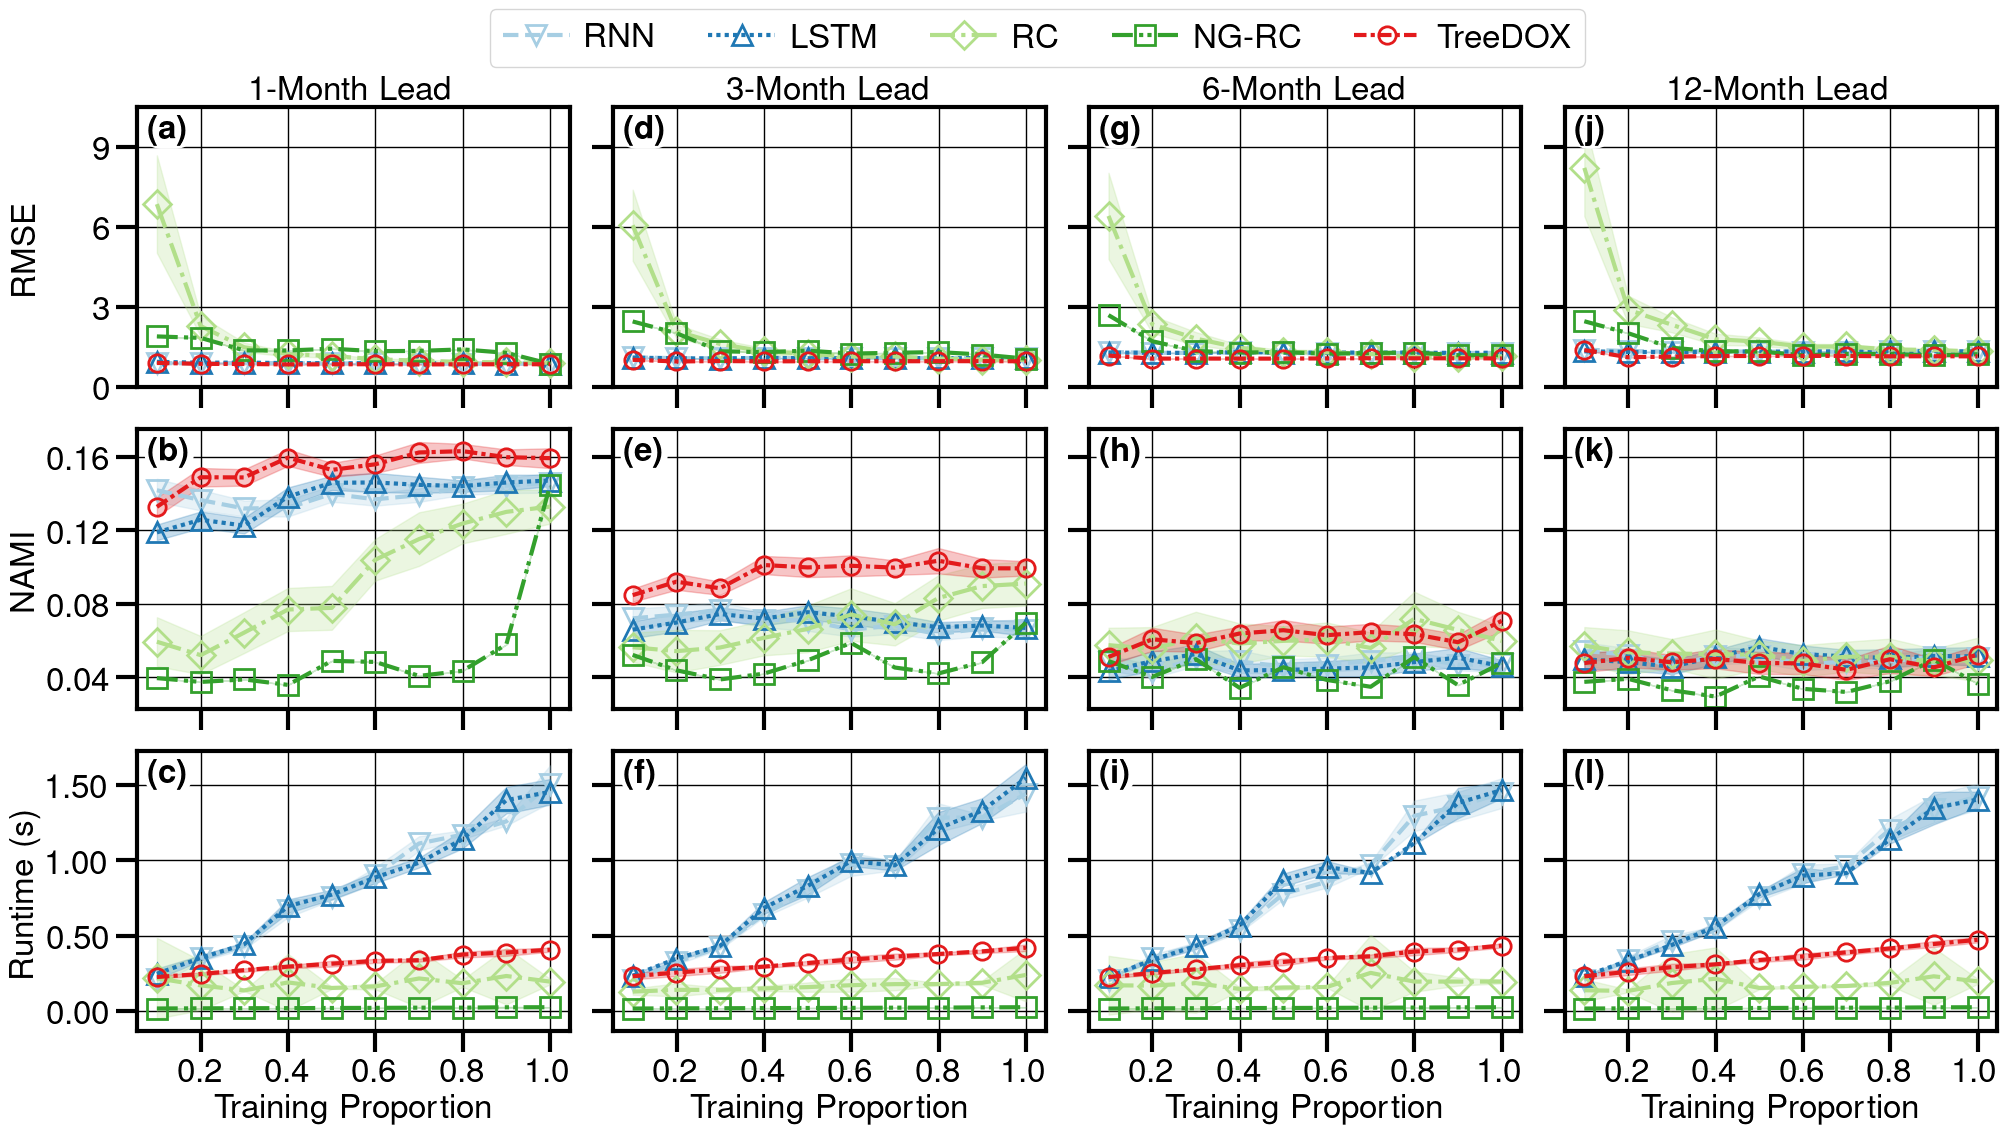

In [45]:
fname = 'SOI_Vary_Training_Samples-TreeDOX_vs_RNN_LSTM_RC_NG-RC'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['soi_rmse_dict', 'soi_ami_dict', 'soi_runtimes_dict']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.0f', '.2f', '.2f']

fig, axs = plt.subplots(len(var_names),len(leads),figsize=(6*len(leads),4*len(var_names)), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15, 15, 20, 20, 25]
# marker_lst = ['v','^','1','2','.']
marker_lst = ['v','^',(4,0,0),(4,0,45),'.']

ylim_stretch = 0.0

for i_lead in range(len(leads)):
    for i_var in range(len(var_names)):
        ax = axs[i_var,i_lead]
        
        if i_var == 0:
            ax.set_title(f'{leads[i_lead]}-Month Lead', fontsize=fontsize)

        var = globals()[var_names[i_var]]

        for i_label, label in enumerate(labels):
            ax.plot(np.array(train_sizes)/len_train, [np.mean(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                    lw=lw_lst[i_label], ls=ls_lst[i_label], label=label, color=color_lst[i_label], zorder=10,
                    marker=marker_lst[i_label], ms=ms_lst[i_label], mew=2, mfc='none')
#             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_lead]) for train_size in train_sizes],
#                         yerr=[np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes], fmt='none',
#                         color=color_lst[i_label], zorder=20)
            ax.fill_between(np.array(train_sizes)/len_train, 
                            [np.mean(var[train_size][i_label][i_lead]) - np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                            [np.mean(var[train_size][i_label][i_lead]) + np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                            color=color_lst[i_label], alpha=0.25, zorder=9)

    #     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

        if i_var == len(var_names)-1:
            ax.set_xlabel('Training Proportion', fontsize=fontsize)
        if i_lead == 0:
            ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
    #     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    #     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
    #     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


    #     if i_var == 0:
    #     ax.set_xlim(0, None)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    #     if i_var == 0:
        xticks = ax.get_xticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
        ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

        if i_lead == len(leads)-1:
        #     if i_var == 0:
    #         ax.set_ylim(0, None)
            ax.yaxis.set_major_locator(plt.MaxNLocator(4))
            ylim = ax.get_ylim()
    #         ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
            ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
        #     if i_var == 0:
            if i_var == 0:
                yticks = ax.get_yticks()[:-1]
            else:
                yticks = ax.get_yticks()[1:-1]
        #     else:
        #         yticks = ax.get_yticks()[1:-1]
            ax.set_yticks(yticks)
            ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

        plt.setp(ax.spines.values(), linewidth=3, zorder=100)
        ax.tick_params(length=15,width=3)

        ax.grid(True, c='k', lw=1, zorder=0)

        ax.annotate(r'\textbf{('+chr(97+i_var+len(var_names)*i_lead)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30,
                    bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))

        if i_var == 0 and i_lead == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
            leg_handles, leg_labels = ax.get_legend_handles_labels()
            fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                       columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

fig.align_labels(axs)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

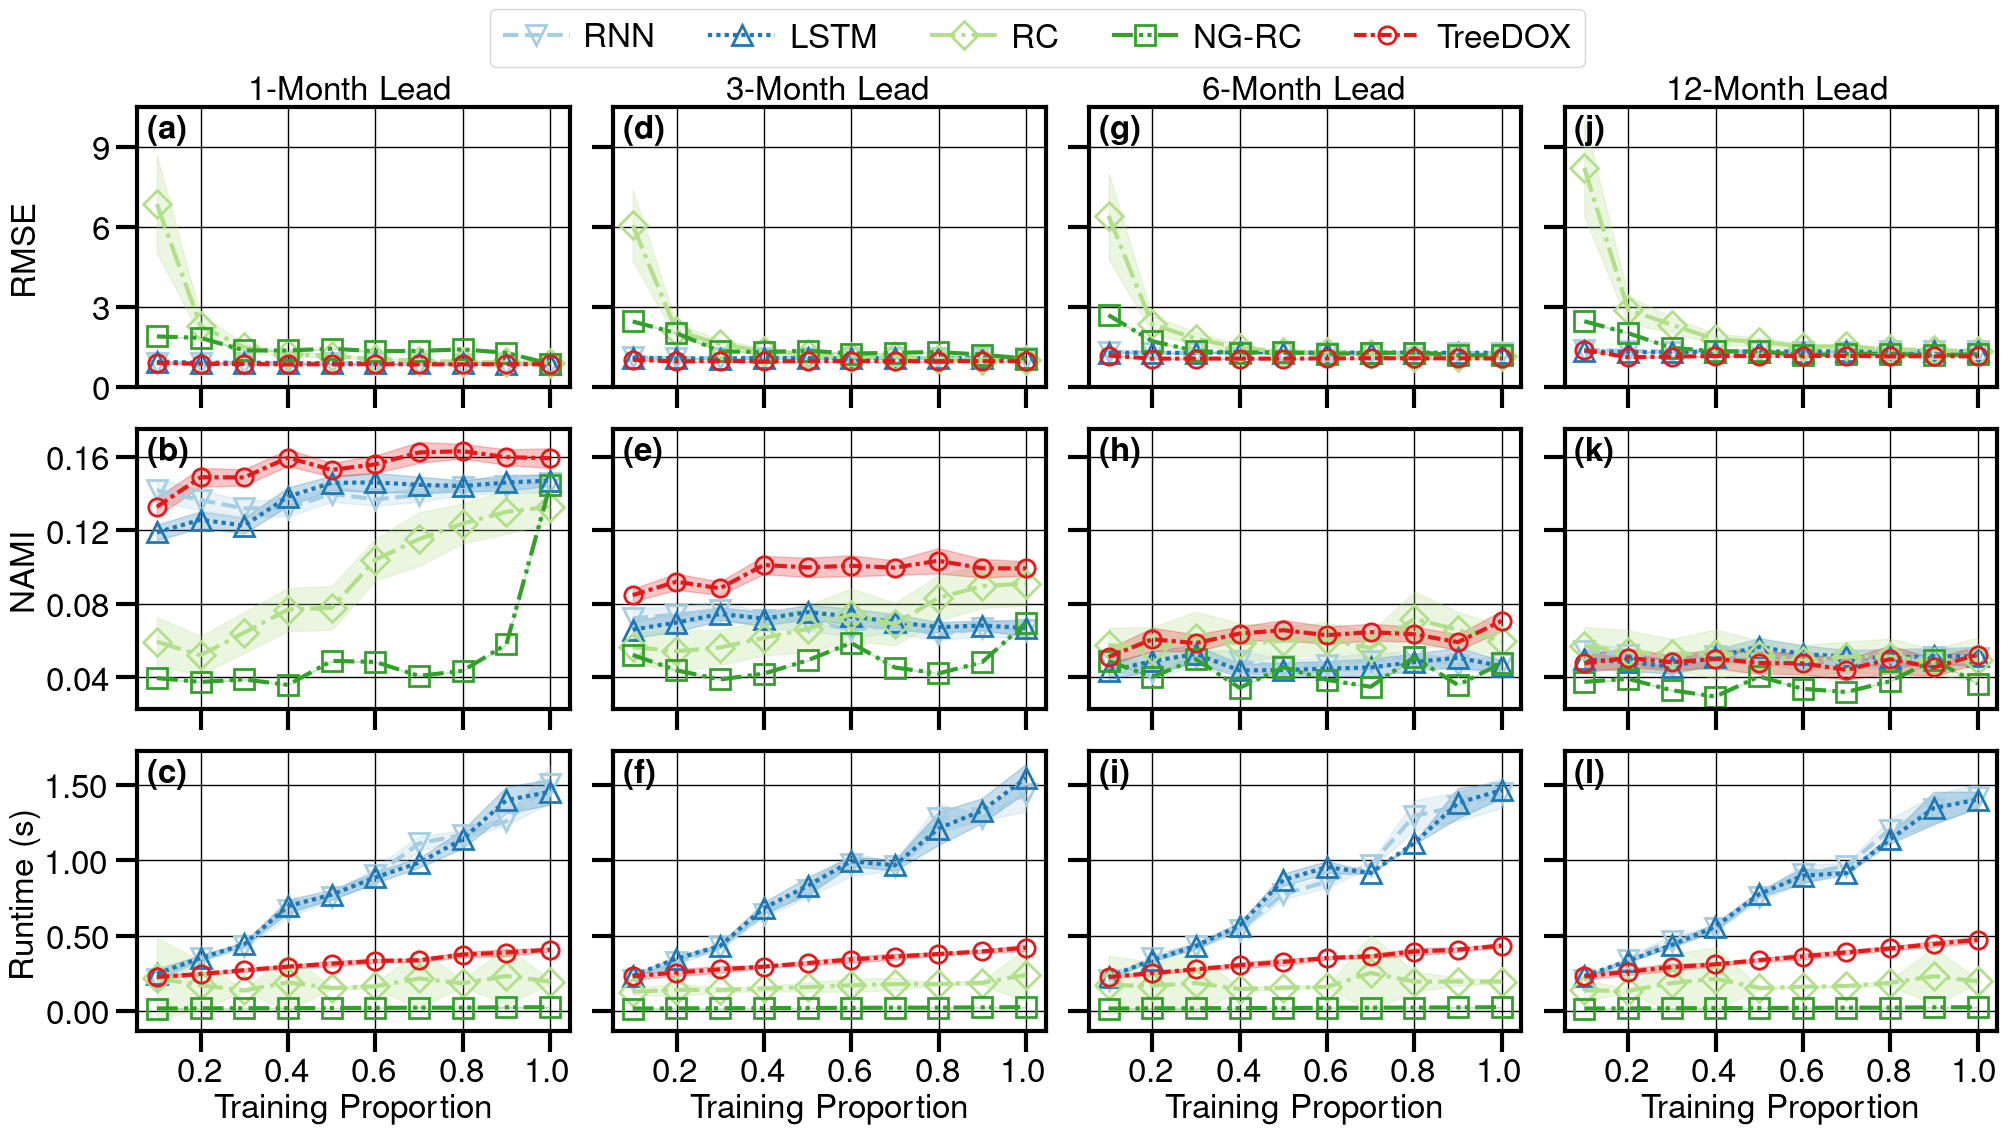

In [85]:
fname = 'SOI_Vary_Training_Samples-TreeDOX_vs_RNN_LSTM_RC_NG-RC'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['soi_rmse_dict', 'soi_ami_dict', 'soi_runtimes_dict']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.0f', '.2f', '.2f']

fig, axs = plt.subplots(len(var_names),len(leads),figsize=(6*len(leads),4*len(var_names)), sharex=True, sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15)

labels = ['RNN', 'LSTM', 'RC', 'NG-RC', 'TreeDOX']
leads = [1, 3, 6, 12]

cmap = mpl.cm.Paired
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
color_lst[-1] = cmap(len(labels))[:-1]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15, 15, 20, 20, 25]
# marker_lst = ['v','^','1','2','.']
marker_lst = ['v','^',(4,0,0),(4,0,45),'.']

ylim_stretch = 0.0

for i_lead in range(len(leads)):
    for i_var in range(len(var_names)):
        ax = axs[i_var,i_lead]
        
        if i_var == 0:
            ax.set_title(f'{leads[i_lead]}-Month Lead', fontsize=fontsize)

        var = globals()[var_names[i_var]]

        for i_label, label in enumerate(labels):
            ax.plot(np.array(train_sizes)/len_train, [np.mean(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                    lw=lw_lst[i_label], ls=ls_lst[i_label], label=label, color=color_lst[i_label], zorder=10,
                    marker=marker_lst[i_label], ms=ms_lst[i_label], mew=2, mfc='none')
#             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_lead]) for train_size in train_sizes],
#                         yerr=[np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes], fmt='none',
#                         color=color_lst[i_label], zorder=20)
            ax.fill_between(np.array(train_sizes)/len_train, 
                            [np.mean(var[train_size][i_label][i_lead]) - np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                            [np.mean(var[train_size][i_label][i_lead]) + np.std(var[train_size][i_label][i_lead]) for train_size in train_sizes],
                            color=color_lst[i_label], alpha=0.25, zorder=9)

    #     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

        if i_var == len(var_names)-1:
            ax.set_xlabel('Training Proportion', fontsize=fontsize)
        if i_lead == 0:
            ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
    #     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    #     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
    #     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


    #     if i_var == 0:
    #     ax.set_xlim(0, None)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    #     if i_var == 0:
        xticks = ax.get_xticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
        ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

        if i_lead == len(leads)-1:
        #     if i_var == 0:
    #         ax.set_ylim(0, None)
            ax.yaxis.set_major_locator(plt.MaxNLocator(4))
            ylim = ax.get_ylim()
    #         ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
            ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
        #     if i_var == 0:
            if i_var == 0:
                yticks = ax.get_yticks()[:-1]
            else:
                yticks = ax.get_yticks()[1:-1]
        #     else:
        #         yticks = ax.get_yticks()[1:-1]
            ax.set_yticks(yticks)
            ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

        plt.setp(ax.spines.values(), linewidth=3, zorder=100)
        ax.tick_params(length=15,width=3)

        ax.grid(True, c='k', lw=1, zorder=0)

        ax.annotate(r'\textbf{('+chr(97+i_var+len(var_names)*i_lead)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)

        if i_var == 0 and i_lead == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
            leg_handles, leg_labels = ax.get_legend_handles_labels()
            fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                       columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

fig.align_labels(axs)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

plt.show()

# Sensitivity Experiment

In [20]:
experiment_dict = {}

## Num Trees

In [21]:
experiment_name = 'Num Trees'
experiment_label = 'Num Trees'
factors = np.arange(0.1,2.1,0.1)#[10, 20, 30, 40, 50, 75, 100, 150, 200]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(soi[:-1], soi[1:], train_size=len_train, shuffle=False)
print(X_train.shape, X_test.shape)

(1416, 1) (481, 1)


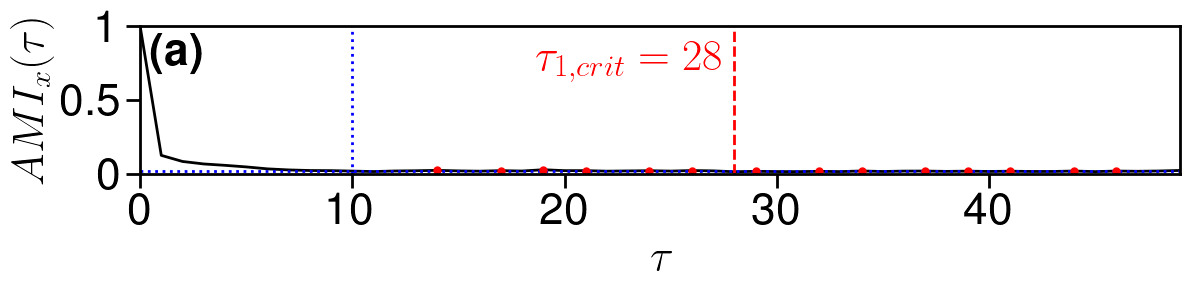

In [23]:
tau_crits = get_tau_crits(X_train, p_val=0.5, max_lag=50, make_plot=True, incorporate_peaks=True)

In [24]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

lead = 1

features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
print(features.shape, labels.shape)

num_runs = 100
y_preds_TreeDOX = []
runtimes_TreeDOX = []
values = []
for i_factor in trange(len(factors)):
    y_preds_TreeDOX.append([None]*num_runs)
    runtimes_TreeDOX.append([None]*num_runs)
    
    value = round(factors[i_factor]*200)
    values.append(value)
    
    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                                    max_depth=None, random_state=None,
                                                    n_jobs=-1, n_samples=None,
                                                    model_type='ETR', return_model=True)
        all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])

        y_pred, model, time_elapsed = future_prediction_lead(features, labels, all_FIs,
                                                             len(y_test), lead=lead,
                                                             p=None, xi=xi,
                                                             n_estimators=value,
                                                             disp_progress=False,
                                                             desc=str(lead),
                                                             leave=False,
                                                             max_depth=None,
                                                             random_state=None,
                                                             n_jobs=-1,
                                                             min_samples_split=2,
                                                             min_samples_leaf=1,
                                                             ccp_alpha=0,
                                                             max_features=1.0,
                                                             n_samples=None,
                                                             model=None,
                                                             y_train=y_train,
                                                             y_test=y_test,
                                                             model_type='ETR',
                                                             verbose=False,
                                                             open_loop=True,
                                                             model_conversion=None,
                                                             device='cuda')
        end_time = time.time()
        y_preds_TreeDOX[i_factor][i_run] = y_pred
        runtimes_TreeDOX[i_factor][i_run] = end_time - start_time
    print(f'{factors[i_factor]:.2f}: {values[i_factor]}',
          np.mean([RMSE_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 29
(1386, 30) (1386, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.10: 20 0.8863624502480552 0.28837958204203035


  0%|          | 0/100 [00:00<?, ?it/s]

0.20: 40 0.8733471282689105 0.3032512105903597


  0%|          | 0/100 [00:00<?, ?it/s]

0.30: 60 0.8692273762680758 0.30680735308191387


  0%|          | 0/100 [00:00<?, ?it/s]

0.40: 80 0.8676551589128267 0.3096079564344685


  0%|          | 0/100 [00:00<?, ?it/s]

0.50: 100 0.8666168419661543 0.31213061619726107


  0%|          | 0/100 [00:00<?, ?it/s]

0.60: 120 0.8644533755893657 0.31523478841454733


  0%|          | 0/100 [00:00<?, ?it/s]

0.70: 140 0.8643793995922726 0.3160151569384906


  0%|          | 0/100 [00:00<?, ?it/s]

0.80: 160 0.8637530081764119 0.31608804258101975


  0%|          | 0/100 [00:00<?, ?it/s]

0.90: 180 0.863954887353332 0.3162183575176381


  0%|          | 0/100 [00:00<?, ?it/s]

1.00: 200 0.8635843248552092 0.31676141231427263


  0%|          | 0/100 [00:00<?, ?it/s]

1.10: 220 0.8631001801608125 0.31806435774372827


  0%|          | 0/100 [00:00<?, ?it/s]

1.20: 240 0.8631534830650622 0.3177069109846359


  0%|          | 0/100 [00:00<?, ?it/s]

1.30: 260 0.8631212950586324 0.319334515609028


  0%|          | 0/100 [00:00<?, ?it/s]

1.40: 280 0.8628310110886364 0.3187108922283565


  0%|          | 0/100 [00:00<?, ?it/s]

1.50: 300 0.8626174345191484 0.31949570091317553


  0%|          | 0/100 [00:00<?, ?it/s]

1.60: 320 0.8626925386657984 0.3199741040191956


  0%|          | 0/100 [00:00<?, ?it/s]

1.70: 340 0.8624433893111175 0.3200082774737892


  0%|          | 0/100 [00:00<?, ?it/s]

1.80: 360 0.861967013409005 0.32061296184698285


  0%|          | 0/100 [00:00<?, ?it/s]

1.90: 380 0.8619880954883797 0.3210452980335514


  0%|          | 0/100 [00:00<?, ?it/s]

2.00: 400 0.8623431383293165 0.31925901557148473


In [25]:
experiment_dict[experiment_name] = {'factors':factors, 'values':values, 'label':experiment_label,
                                    'y_preds':y_preds_TreeDOX, 'runtimes':runtimes_TreeDOX}

## k

In [26]:
experiment_name = 'k'
experiment_label = r'$k$'
factors = np.arange(0.1,2.1,0.1)#[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]

In [27]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

lead = 1

# features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
# print(features.shape, labels.shape)

num_runs = 100
y_preds_TreeDOX = []
runtimes_TreeDOX = []
values = []
for i_factor in trange(len(factors)):
    y_preds_TreeDOX.append([None]*num_runs)
    runtimes_TreeDOX.append([None]*num_runs)
    
    value = round(factors[i_factor]*k)
    values.append(value)
    features, labels = make_features_and_labels(X_train, value+lead, xi=xi, stride=1, lead=lead)
    
    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                                    max_depth=None, random_state=None,
                                                    n_jobs=-1, n_samples=None,
                                                    model_type='ETR', return_model=True)
        all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])

        y_pred, model, time_elapsed = future_prediction_lead(features, labels, all_FIs,
                                                             len(y_test), lead=lead,
                                                             p=None, xi=xi,
                                                             n_estimators=200,
                                                             disp_progress=False,
                                                             desc=str(lead),
                                                             leave=False,
                                                             max_depth=None,
                                                             random_state=None,
                                                             n_jobs=-1,
                                                             min_samples_split=2,
                                                             min_samples_leaf=1,
                                                             ccp_alpha=0,
                                                             max_features=1.0,
                                                             n_samples=None,
                                                             model=None,
                                                             y_train=y_train,
                                                             y_test=y_test,
                                                             model_type='ETR',
                                                             verbose=False,
                                                             open_loop=True,
                                                             model_conversion=None,
                                                             device='cuda')
        end_time = time.time()
        y_preds_TreeDOX[i_factor][i_run] = y_pred
        runtimes_TreeDOX[i_factor][i_run] = end_time - start_time
    print(f'{factors[i_factor]:.2f}: {values[i_factor]}',
          np.mean([RMSE_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 29


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.10: 3 0.9082227710729772 0.26507779491644895


  0%|          | 0/100 [00:00<?, ?it/s]

0.20: 6 0.8813361601123354 0.28319331356387906


  0%|          | 0/100 [00:00<?, ?it/s]

0.30: 9 0.8755671379988642 0.28936399558404297


  0%|          | 0/100 [00:00<?, ?it/s]

0.40: 12 0.8667052916441732 0.29863916167552623


  0%|          | 0/100 [00:00<?, ?it/s]

0.50: 14 0.8612728350256097 0.3034185417567728


  0%|          | 0/100 [00:00<?, ?it/s]

0.60: 17 0.8631410588565107 0.305568457991889


  0%|          | 0/100 [00:00<?, ?it/s]

0.70: 20 0.8677874282445504 0.30162319886582223


  0%|          | 0/100 [00:00<?, ?it/s]

0.80: 23 0.8621184504581327 0.30956158762534086


  0%|          | 0/100 [00:00<?, ?it/s]

0.90: 26 0.8653022064535021 0.31329893178342444


  0%|          | 0/100 [00:00<?, ?it/s]

1.00: 29 0.8632986502359057 0.31712110495440793


  0%|          | 0/100 [00:00<?, ?it/s]

1.10: 32 0.8611864354934902 0.31485197909277224


  0%|          | 0/100 [00:00<?, ?it/s]

1.20: 35 0.8592236067433815 0.31648388296572055


  0%|          | 0/100 [00:00<?, ?it/s]

1.30: 38 0.8617620192158629 0.3191887337399733


  0%|          | 0/100 [00:00<?, ?it/s]

1.40: 41 0.8614470373251699 0.31854959647757153


  0%|          | 0/100 [00:00<?, ?it/s]

1.50: 44 0.861166927739623 0.31517436890132555


  0%|          | 0/100 [00:00<?, ?it/s]

1.60: 46 0.8615048456395209 0.31289978869020546


  0%|          | 0/100 [00:00<?, ?it/s]

1.70: 49 0.8655491787602345 0.3085790593781073


  0%|          | 0/100 [00:00<?, ?it/s]

1.80: 52 0.8629064205623044 0.31471647681647985


  0%|          | 0/100 [00:00<?, ?it/s]

1.90: 55 0.8617681020502199 0.31544339523695036


  0%|          | 0/100 [00:00<?, ?it/s]

2.00: 58 0.8594415542622411 0.3086330204883731


In [28]:
experiment_dict[experiment_name] = {'factors':factors, 'values':values, 'label':experiment_label,
                                    'y_preds':y_preds_TreeDOX, 'runtimes':runtimes_TreeDOX}

## p

In [29]:
experiment_name = 'p'
experiment_label = r'$p$'
factors = np.arange(0.1,2.1,0.1)#[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2]

In [30]:
xi = 1
k = int(np.ceil(max(tau_crits)/xi + 1))
print(f'xi = {xi}, k = {k}')

lead = 1

# features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
# print(features.shape, labels.shape)

num_runs = 100
y_preds_TreeDOX = []
runtimes_TreeDOX = []
values = []
for i_factor in trange(len(factors)):
    y_preds_TreeDOX.append([None]*num_runs)
    runtimes_TreeDOX.append([None]*num_runs)
    
    features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
    
    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                                    max_depth=None, random_state=None,
                                                    n_jobs=-1, n_samples=None,
                                                    model_type='ETR', return_model=True)
        all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])
        
#         if i_run == 0:
#             value = round(factors[i_factor]*len(np.where(FIs >= np.quantile(FIs,0.5))[0]))
#             values.append(value)

        y_pred, model, p, time_elapsed = future_prediction_lead(features, labels, all_FIs,
                                                                 len(y_test), lead=lead,
                                                                 p=str(factors[i_factor]), xi=xi,
                                                                 n_estimators=200,
                                                                 disp_progress=False,
                                                                 desc=str(lead),
                                                                 leave=False,
                                                                 max_depth=None,
                                                                 random_state=None,
                                                                 n_jobs=-1,
                                                                 min_samples_split=2,
                                                                 min_samples_leaf=1,
                                                                 ccp_alpha=0,
                                                                 max_features=1.0,
                                                                 n_samples=None,
                                                                 model=None,
                                                                 y_train=y_train,
                                                                 y_test=y_test,
                                                                 model_type='ETR',
                                                                 verbose=False,
                                                                 open_loop=True,
                                                                 model_conversion=None,
                                                                 device='cuda',
                                                                 return_p=True)
        if i_run == 0:
            value = p
            values.append(value)
        
        end_time = time.time()
        y_preds_TreeDOX[i_factor][i_run] = y_pred
        runtimes_TreeDOX[i_factor][i_run] = end_time - start_time
    print(f'{factors[i_factor]:.2f}: {values[i_factor]}',
          np.mean([RMSE_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]))

xi = 1, k = 29


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.10: 3 0.9198637609617667 0.2658921365980853


  0%|          | 0/100 [00:00<?, ?it/s]

0.20: 6 0.8854578382957875 0.2775385491853109


  0%|          | 0/100 [00:00<?, ?it/s]

0.30: 9 0.8690447804980923 0.2965419101331921


  0%|          | 0/100 [00:00<?, ?it/s]

0.40: 12 0.8639506509314182 0.3034780139143181


  0%|          | 0/100 [00:00<?, ?it/s]

0.50: 15 0.862717639772345 0.3085244857263058


  0%|          | 0/100 [00:00<?, ?it/s]

0.60: 18 0.8630714327056985 0.3121441039996258


  0%|          | 0/100 [00:00<?, ?it/s]

0.70: 21 0.862357090230576 0.3117634077678615


  0%|          | 0/100 [00:00<?, ?it/s]

0.80: 24 0.8640135543988577 0.3123022957698745


  0%|          | 0/100 [00:00<?, ?it/s]

0.90: 27 0.8647572813097654 0.31298287631321636


  0%|          | 0/100 [00:00<?, ?it/s]

1.00: 30 0.8639290711573131 0.3161960180599464


  0%|          | 0/100 [00:00<?, ?it/s]

1.10: 30 0.8630443551726964 0.31703096335786557


  0%|          | 0/100 [00:00<?, ?it/s]

1.20: 30 0.8635187101102245 0.31701091481319044


  0%|          | 0/100 [00:00<?, ?it/s]

1.30: 30 0.8633799402751704 0.31753576715236265


  0%|          | 0/100 [00:00<?, ?it/s]

1.40: 30 0.8633687730765475 0.3189239414731664


  0%|          | 0/100 [00:00<?, ?it/s]

1.50: 30 0.8630185430858529 0.3194555319842292


  0%|          | 0/100 [00:00<?, ?it/s]

1.60: 30 0.8628635514898397 0.3184532667356497


  0%|          | 0/100 [00:00<?, ?it/s]

1.70: 30 0.8637969194865164 0.3180071091116079


  0%|          | 0/100 [00:00<?, ?it/s]

1.80: 30 0.8635566506565938 0.3164001270735863


  0%|          | 0/100 [00:00<?, ?it/s]

1.90: 30 0.8628359882730814 0.31779051045162543


  0%|          | 0/100 [00:00<?, ?it/s]

2.00: 30 0.8630416174786297 0.316498270732293


In [31]:
experiment_dict[experiment_name] = {'factors':factors, 'values':values, 'label':experiment_label,
                                    'y_preds':y_preds_TreeDOX, 'runtimes':runtimes_TreeDOX}

## $\xi$

In [32]:
experiment_name = 'xi'
experiment_label = r'$\xi$'
factors = np.arange(1,15)

In [33]:
lead = 1

# features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
# print(features.shape, labels.shape)

num_runs = 100
y_preds_TreeDOX = []
runtimes_TreeDOX = []
values = []
for i_factor in trange(len(factors)):
    y_preds_TreeDOX.append([None]*num_runs)
    runtimes_TreeDOX.append([None]*num_runs)
    
    xi = 1*factors[i_factor]
    k = int(np.ceil(max(tau_crits)/xi + 1))
#     print(f'xi = {xi}, k = {k}')

    value = xi
    values.append(value)
    
    features, labels = make_features_and_labels(X_train, k+lead, xi=xi, stride=1, lead=lead)
    
    for i_run in trange(num_runs,leave=False):
        start_time = time.time()
        FIs, ETR1, time_elapsed = feature_selection(features, labels, n_estimators=100,
                                                    max_depth=None, random_state=None,
                                                    n_jobs=-1, n_samples=None,
                                                    model_type='ETR', return_model=True)
        all_FIs = np.array([tree.feature_importances_ for tree in ETR1.estimators_])
        

        y_pred, model, time_elapsed = future_prediction_lead(features, labels, all_FIs,
                                                             len(y_test), lead=lead,
                                                             p=None, xi=xi,
                                                             n_estimators=200,
                                                             disp_progress=False,
                                                             desc=str(lead),
                                                             leave=False,
                                                             max_depth=None,
                                                             random_state=None,
                                                             n_jobs=-1,
                                                             min_samples_split=2,
                                                             min_samples_leaf=1,
                                                             ccp_alpha=0,
                                                             max_features=1.0,
                                                             n_samples=None,
                                                             model=None,
                                                             y_train=y_train,
                                                             y_test=y_test,
                                                             model_type='ETR',
                                                             verbose=False,
                                                             open_loop=True,
                                                             model_conversion=None,
                                                             device='cuda')
        end_time = time.time()
        y_preds_TreeDOX[i_factor][i_run] = y_pred
        runtimes_TreeDOX[i_factor][i_run] = end_time - start_time
    print(f'{factors[i_factor]:.2f}: {values[i_factor]}',
          np.mean([RMSE_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]),
          np.mean([AMI_summary(y_preds_TreeDOX[i_factor][i_run], y_test) for i_run in range(num_runs)]))

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

1.00: 1 0.8635013978532691 0.31746665884453706


  0%|          | 0/100 [00:00<?, ?it/s]

2.00: 2 0.8811192120408399 0.2906702817225619


  0%|          | 0/100 [00:00<?, ?it/s]

3.00: 3 0.896521015920549 0.2689485802869127


  0%|          | 0/100 [00:00<?, ?it/s]

4.00: 4 0.904074504639494 0.27288831485404275


  0%|          | 0/100 [00:00<?, ?it/s]

5.00: 5 0.9070575846230465 0.2751853327605931


  0%|          | 0/100 [00:00<?, ?it/s]

6.00: 6 0.940805580990545 0.24613714357827918


  0%|          | 0/100 [00:00<?, ?it/s]

7.00: 7 0.9339707040985107 0.2430550567775211


  0%|          | 0/100 [00:00<?, ?it/s]

8.00: 8 0.9378492773303775 0.2358714475096689


  0%|          | 0/100 [00:00<?, ?it/s]

9.00: 9 0.9481067215723366 0.2363552050867532


  0%|          | 0/100 [00:00<?, ?it/s]

10.00: 10 0.9310097172269043 0.2608140187076657


  0%|          | 0/100 [00:00<?, ?it/s]

11.00: 11 0.9452146580465396 0.24570629237848368


  0%|          | 0/100 [00:00<?, ?it/s]

12.00: 12 0.9741579914290592 0.22559226744684216


  0%|          | 0/100 [00:00<?, ?it/s]

13.00: 13 0.9506744841167715 0.22895321764580343


  0%|          | 0/100 [00:00<?, ?it/s]

14.00: 14 0.9737825994976751 0.22810185093171134


In [34]:
experiment_dict[experiment_name] = {'factors':factors, 'values':values, 'label':experiment_label,
                                    'y_preds':y_preds_TreeDOX, 'runtimes':runtimes_TreeDOX}

## Plots

In [35]:
with gzip.open(data_dir + 'SOI_sensitivity_experiment.data', 'wb') as file:
    pkl.dump(experiment_dict, file)

In [18]:
with gzip.open(data_dir + 'SOI_sensitivity_experiment.data', 'rb') as file:
    experiment_dict = pkl.load(file)

In [19]:
experiment_names = list(experiment_dict.keys())
experiment_names

['Num Trees', 'k', 'p', 'xi']

In [20]:
experiment_names = list(experiment_dict.keys())
experiment_names = experiment_names[1:2]+experiment_names[-2::][::-1]+experiment_names[:1]
experiment_names

['k', 'xi', 'p', 'Num Trees']

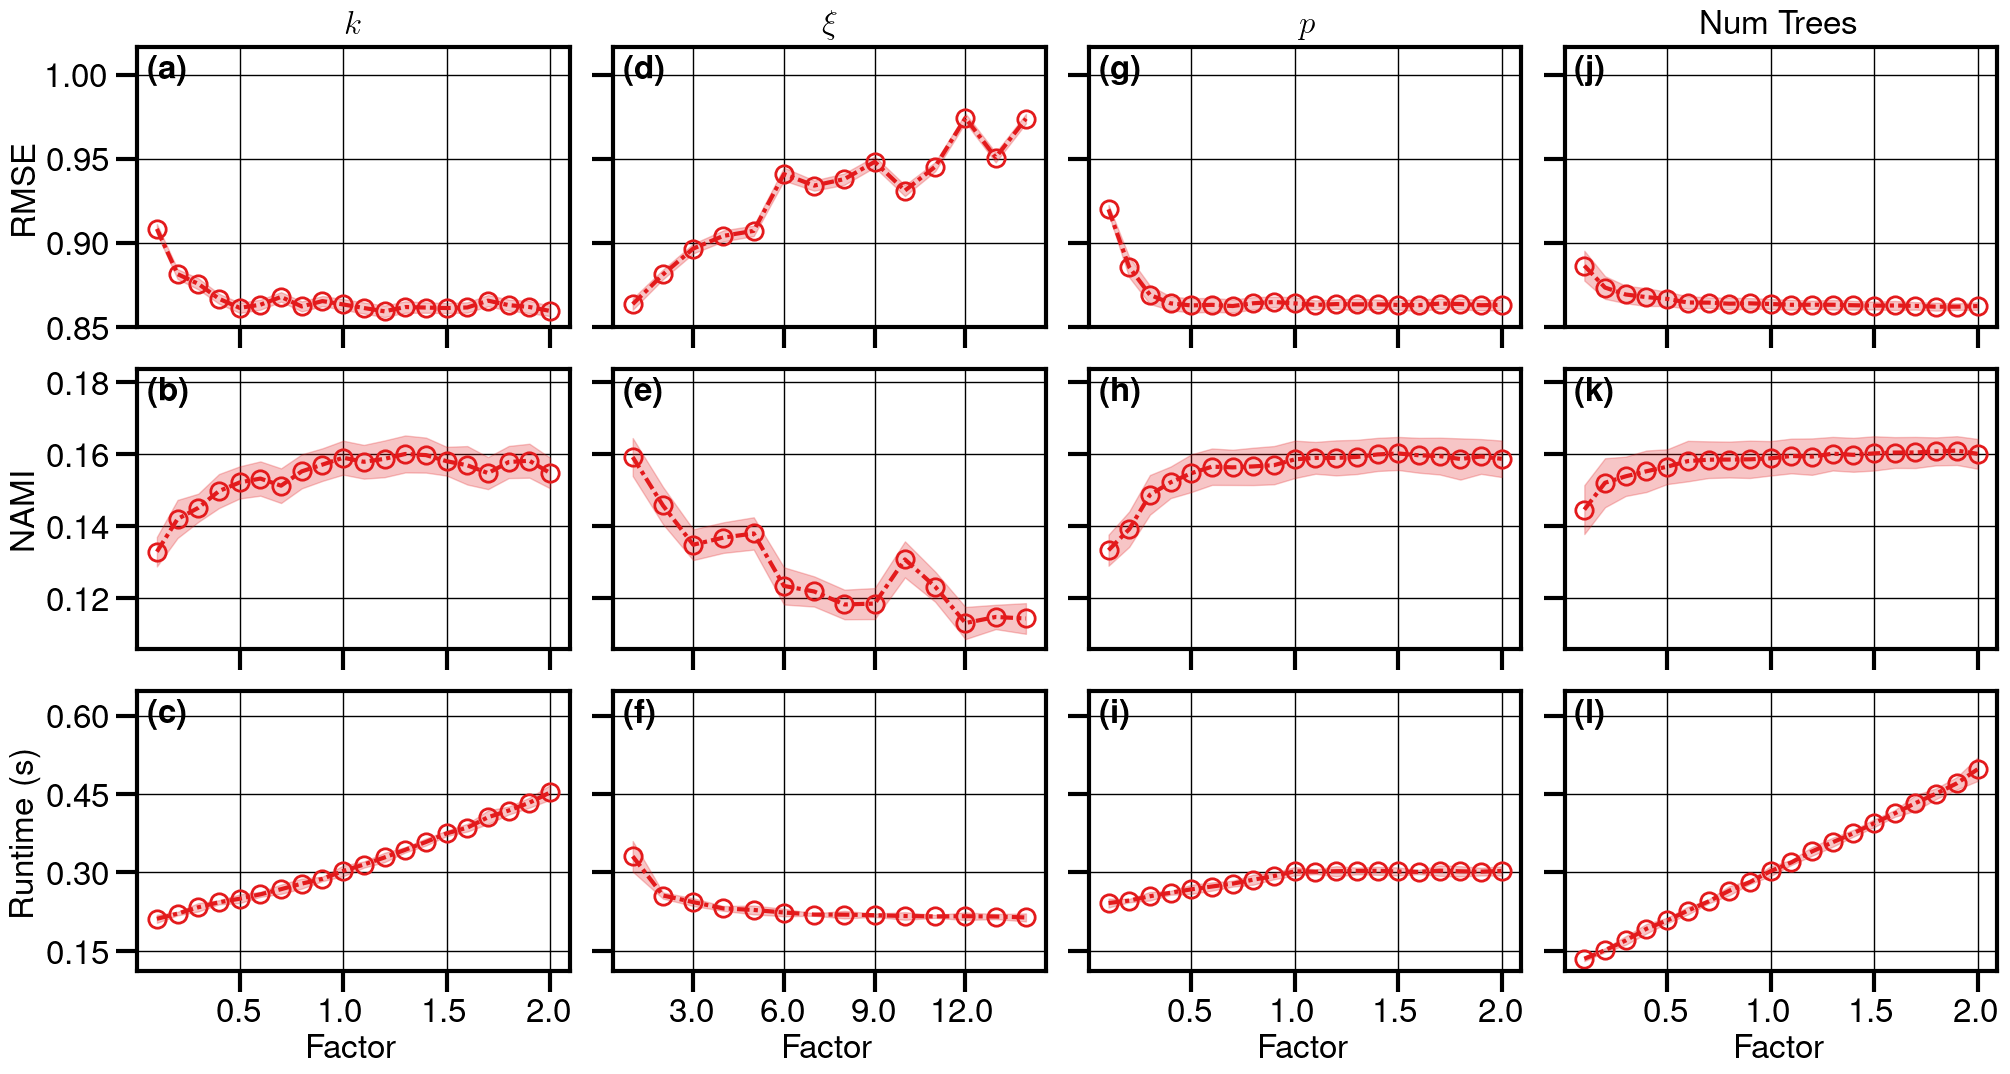

In [21]:
fname = 'SOI_sensitivity_experiment'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(len(var_names),len(experiment_names),
                        figsize=(6*len(experiment_names),4*len(var_names)),
                        sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15)

labels = ['TreeDOX']

cmap = mpl.cm.Paired
qualitative = True
# color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
color_lst = [cmap(5)]

lw_lst = [3]*len(labels)
ls_lst = [(0, (3, 1, 1, 1))]
ms_lst = [25]
# marker_lst = ['v','^','1','2','.']
marker_lst = ['.']

ylim_stretch = 0.25

for i_experiment_name in range(len(experiment_names)):
    for i_var in range(len(var_names)):
        ax = axs[i_var,i_experiment_name]
        
        experiment_name = experiment_names[i_experiment_name]
        
        if i_var == 0:
            ax.set_title(experiment_dict[experiment_name]['label'], fontsize=fontsize, pad=10)

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        i_label = 0
        ax.plot(np.array(experiment_dict[experiment_name]['factors']), mean,
                lw=lw_lst[i_label], ls=ls_lst[i_label], label=labels[i_label], color=color_lst[i_label], zorder=10,
                marker=marker_lst[i_label], ms=ms_lst[i_label], mew=2, mfc='none')
#             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
#                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
#                         color=color_lst[i_label], zorder=20)
        ax.fill_between(experiment_dict[experiment_name]['factors'], lower, upper,
                        color=color_lst[i_label], alpha=0.25, zorder=9)

    #     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

        if i_var == len(var_names)-1:
            ax.set_xlabel('Factor', fontsize=fontsize)
        if i_experiment_name == 0:
            ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
    #     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
    #     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
    #     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


    #     if i_var == 0:
    #     ax.set_xlim(0, None)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    #     if i_var == 0:
        xticks = ax.get_xticks()[1:-1]
#         xticks = experiment_dict[experiment_name]['factors'][1::4]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
        ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

        if i_experiment_name == len(experiment_names)-1:
        #     if i_var == 0:
    #         ax.set_ylim(0, None)
            ax.yaxis.set_major_locator(plt.MaxNLocator(4))
            ylim = ax.get_ylim()
#             ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
            ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
        #     if i_var == 0:
            yticks = ax.get_yticks()[1:-1]
        #     else:
        #         yticks = ax.get_yticks()[1:-1]
            ax.set_yticks(yticks)
            ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

        plt.setp(ax.spines.values(), linewidth=3, zorder=100)
        ax.tick_params(length=15,width=3)

        ax.grid(True, c='k', lw=1, zorder=0)

        ax.annotate(r'\textbf{('+chr(97+i_var+len(var_names)*i_experiment_name)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)

#         if i_var == 0 and i_experiment_name == 0:
# #             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
# #                           columnspacing=1.5,handletextpad=0.5)
#             leg_handles, leg_labels = ax.get_legend_handles_labels()
#             fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                        columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

# plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()

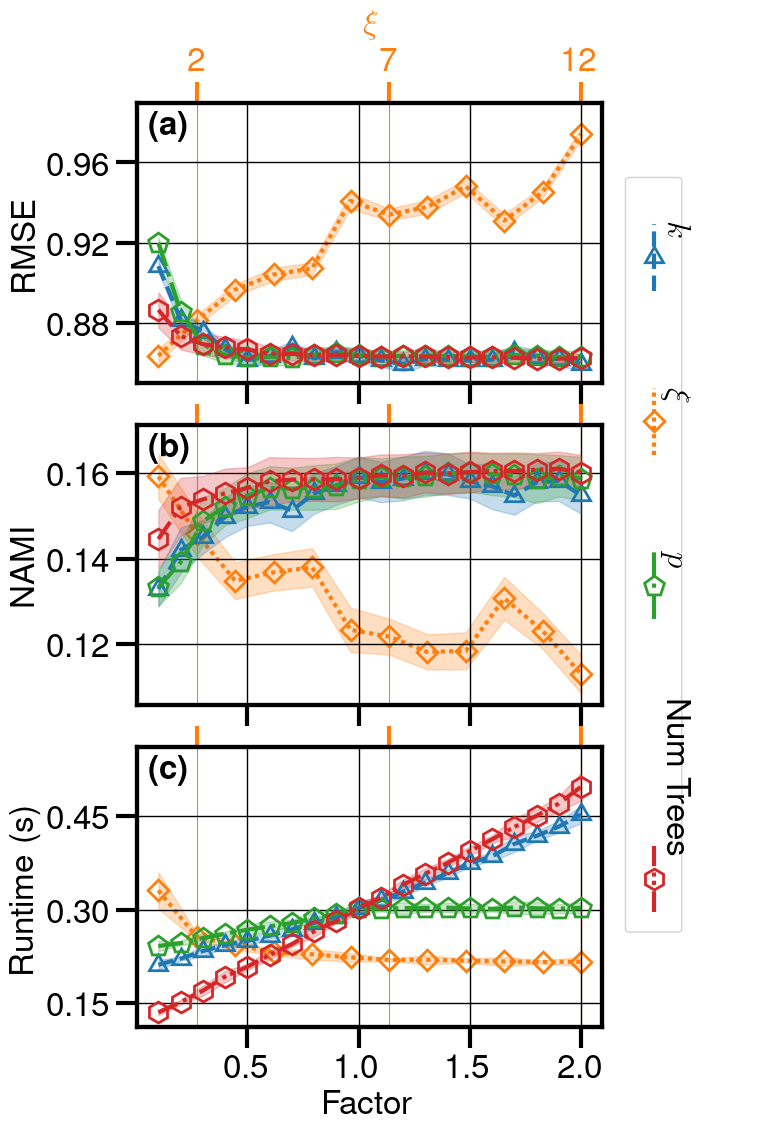

In [39]:
fname = 'SOI_sensitivity_experiment_vertical'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(len(var_names),1,
                        figsize=(6,4*len(var_names)),
                        sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.1, hspace=0.15)

labels = experiment_names

cmap = mpl.cm.tab10
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
# color_lst = [cmap(4)]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15]*len(labels)
# marker_lst = ['v','^','1','2','.']
marker_lst = [(3,0,0),(4,0,0),(5,0,0),(6,0,0)]

ylim_stretch = 0.05

axs_twin = []
for i_var in range(len(var_names)):
    ax = axs[i_var]
    

    for i_experiment_name in range(len(experiment_names)):
        experiment_name = experiment_names[i_experiment_name]

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        if experiment_name == 'xi':
            ax.plot([],[],lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
            ax_twin = ax.twiny()
            axs_twin.append(ax_twin)
            xi_greatest = 12
            ax_twin.plot(np.array(experiment_dict[experiment_name]['factors'])[:xi_greatest], mean[:xi_greatest],
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax_twin.fill_between(experiment_dict[experiment_name]['factors'][:xi_greatest], lower[:xi_greatest], upper[:xi_greatest],
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)
#             ax_twin.xaxis.set_major_locator(plt.MaxNLocator(3))
#             xticks = ax_twin.get_xticks()[1:-1]
#             xticks = np.arange(1,xi_greatest+1,6)
            xticks = [2,7,12]
            ax_twin.set_xticks(xticks)
            
            
            if i_var == 0:
                ax_twin.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], ha='center', color=color_lst[i_experiment_name])
                ax_twin.set_xlabel(experiment_dict[experiment_name]['label'], fontsize=fontsize, color=color_lst[i_experiment_name], labelpad=10)
            else:
                ax_twin.set_xticklabels('' for xtick in xticks)
#                 ax_twin.sharex(axs_twin[i_var-1])
                
            ax_twin.tick_params(length=15,width=3,color=color_lst[i_experiment_name], zorder=-1)
            plt.setp(ax_twin.spines.values(), linewidth=3, zorder=100)
            ax_twin.grid(True, color=color_lst[i_experiment_name], zorder=-2)
            
            ax.set_zorder(2)
            ax_twin.set_zorder(1)
            ax.patch.set_visible(False)
        else:
            ax.plot(np.array(experiment_dict[experiment_name]['factors']), mean,
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax.fill_between(experiment_dict[experiment_name]['factors'], lower, upper,
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)

#     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    if i_var == len(var_names)-1:
        ax.set_xlabel('Factor', fontsize=fontsize)
    ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
#     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
#     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


#     if i_var == 0:
#     ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#     if i_var == 0:
    xticks = ax.get_xticks()[1:-1]
#     xticks = experiment_dict[experiment_name]['factors'][1::4]
#     xticks = [0.4,1.0,1.6]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
    ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

    if i_experiment_name == len(experiment_names)-1:
    #     if i_var == 0:
#         ax.set_ylim(0, None)
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ylim = ax.get_ylim()
#             ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
        ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
    #     if i_var == 0:
        yticks = ax.get_yticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_yticks(yticks)
        ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    ax.grid(True, c='k', lw=1, zorder=0)

    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)

#     if i_var == 0:
# #             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
# #                           columnspacing=1.5,handletextpad=0.5)
#         leg_handles, leg_labels = ax.get_legend_handles_labels()
#         fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                    columnspacing=1.5,handletextpad=0.5)
        
def LegendVertical(Ax, Rotation=90, XPad=0, YPad=0, Handles=None, Labels=None, **LegendArgs):
    if Rotation not in (90,270):
        raise NotImplementedError('Rotation must be 90 or 270.')

    # Extra spacing between labels is needed to fit the rotated labels;
    # and since the frame will not adjust to the rotated labels, it is
    # disabled by default
    DefaultLoc = 'center left' if Rotation==90 else 'center right'
    ArgsDefaults = dict(loc=DefaultLoc, labelspacing=4, frameon=False)
    Args = {**ArgsDefaults, **LegendArgs}

    if Handles is None or Labels is None:
        Handles, Labels = Ax.get_legend_handles_labels()
    if Rotation==90:
        # Reverse entries
        Handles, Labels = (reversed(_) for _ in (Handles, Labels))
    AxLeg = Ax.legend(Handles, Labels, **Args)

    LegTexts = AxLeg.get_texts()
    LegHandles = AxLeg.legend_handles

    for L,Leg in enumerate(LegHandles):
        if type(Leg) == mpl.patches.Rectangle:
            BBounds = np.ravel(Leg.get_bbox())
            BBounds[2:] = BBounds[2:][::-1]
            Leg.set_bounds(BBounds)

            LegPos = (
                # Ideally,
                #    `(BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad`
                # should be at the horizontal center of the legend patch,
                # but for some reason it is not. Therefore the user will
                # need to specify some padding.
                (BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad + XPad,

                # Similarly, `(BBounds[1]+BBounds[3])` should be at the vertical
                # top of the legend patch, but it is not.
                (BBounds[1]+BBounds[3])+YPad
            )

        elif type(Leg) == mpl.lines.Line2D:
            LegXY = Leg.get_xydata()[:,::-1]
            Leg.set_data(*(LegXY[:,_] for _ in (0,1)))

            LegPos = (
                LegXY[0,0] - AxLeg.handletextpad + XPad,
                max(LegXY[:,1]) + YPad
            )

        elif type(Leg) == mpl.collections.PathCollection:
            LegPos = (
                Leg.get_offsets()[0][0] + XPad,
                Leg.get_offsets()[0][1] + YPad,
            )
        else:
            raise NotImplementedError('Legends should contain Rectangle, Line2D or PathCollection.')

        PText = LegTexts[L]
        PText.set_verticalalignment('bottom')
        PText.set_rotation(Rotation)
        PText.set_x(LegPos[0])
        PText.set_y(LegPos[1])

def legendAsLatex(axes, rotation=90) :
    '''Generate a latex code to be used instead of the legend. 
       Uses the label, color, marker and linestyle provided to the pyplot.plot.
       The marker and the linestyle must be defined using the one or two character
           abreviations shown in the help of pyplot.plot.
       Rotation of the markers must be multiple of 90.
    '''
    latexLine = {'-':'\\textbf{\Large ---}',
        '-.':'\\textbf{\Large --\:\!$\\boldsymbol{\cdot}$\:\!--}',
        '--':'\\textbf{\Large --\,--}',':':'\\textbf{\Large -\:\!-}'}
    latexSymbol = {'o':'medbullet', 'd':'diamond', 's':'filledmedsquare',
        'D':'Diamondblack', '*':'bigstar', '+':'boldsymbol{\plus}',
        'x':'boldsymbol{\\times}', 'p':'pentagon', 'h':'hexagon',
        ',':'boldsymbol{\cdot}', '_':'boldsymbol{\minus}','<':'LHD',
        '>':'RHD','v':'blacktriangledown', '^':'blacktriangle'} 
    rot90=['^','<','v','>']
    di = [0,-1,2,1][rotation%360//90]
    latexSymbol.update({rot90[i]:latexSymbol[rot90[(i+di)%4]] for i in range(4)})
#     return ', '.join(['\\textcolor[rgb]{'\
#             + ','.join([str(x) for x in mpl.colors.to_rgb(handle.get_color())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
#                 for handle,label in zip(*axes.get_legend_handles_labels())])
    return ', '.join(['\\textcolor[rgb]{'\
            + ','.join([str(x) for x in mpl.colors.to_rgb(list(handle)[0].get_facecolor())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
            + label + '} '# + label
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
                for handle,label in zip(*axes.get_legend_handles_labels())])
        
#     if i_var == 0:
leg_handles, leg_labels = axs[0].get_legend_handles_labels()
# ax_tmp = axs[1].twinx()
# ax_tmp.set_ylabel(legendAsLatex(axs[1]), fontsize=fontsize, labelpad=10)
# plt.setp(ax_tmp.get_yticklabels(), visible=False)
# ax_tmp.tick_params(bottom=False, top=False, left=False, right=False)
LegendVertical(axs[1], Rotation=270, XPad=-65, YPad=5, Handles=leg_handles,
               Labels=[experiment_dict[name]['label'] for name in experiment_names], prop={'size': legendfontsize},
               loc='center', bbox_to_anchor=(1.2,0.4), columnspacing=-2, handletextpad=0.25, ncol=1,
               labelspacing=4, reverse=False)
axs[1].add_patch(mpl.patches.FancyBboxPatch((1.06, 0.35), .101, 2.675, transform=axs[2].transAxes, linewidth=1,
                                            edgecolor='lightgray', facecolor='none', clip_on=False,
                                            boxstyle=mpl.patches.BoxStyle("Round, pad=0.01, rounding_size=0.01")))

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()

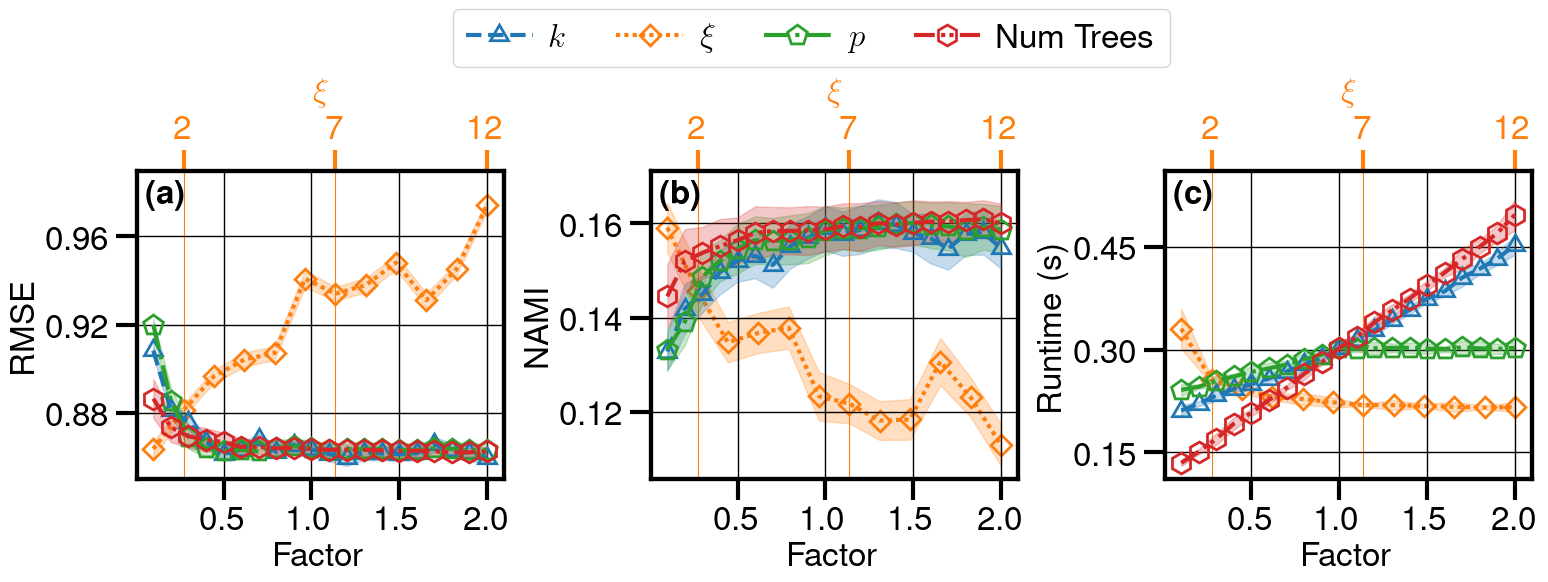

In [58]:
fname = 'SOI_sensitivity_experiment_horizontal2'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(1,len(var_names),
                        figsize=(6*len(var_names),4),
                        sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.4, hspace=0.15)

labels = experiment_names

cmap = mpl.cm.tab10
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
# color_lst = [cmap(4)]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15]*len(labels)
# marker_lst = ['v','^','1','2','.']
marker_lst = [(3,0,0),(4,0,0),(5,0,0),(6,0,0)]

ylim_stretch = 0.05

axs_twin = []
for i_var in range(len(var_names)):
    ax = axs[i_var]
    

    for i_experiment_name in range(len(experiment_names)):
        experiment_name = experiment_names[i_experiment_name]

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        if experiment_name == 'xi':
            ax.plot([],[],lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
            ax_twin = ax.twiny()
            axs_twin.append(ax_twin)
            xi_greatest = 12
            ax_twin.plot(np.array(experiment_dict[experiment_name]['factors'])[:xi_greatest], mean[:xi_greatest],
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax_twin.fill_between(experiment_dict[experiment_name]['factors'][:xi_greatest], lower[:xi_greatest], upper[:xi_greatest],
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)
#             ax_twin.xaxis.set_major_locator(plt.MaxNLocator(3))
#             xticks = ax_twin.get_xticks()[1:-1]
#             xticks = np.arange(1,xi_greatest+1,6)
            xticks = [2,7,12]
            ax_twin.set_xticks(xticks)
            
            
            # if i_var == 0:
            ax_twin.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], ha='center', color=color_lst[i_experiment_name])
            ax_twin.set_xlabel(experiment_dict[experiment_name]['label'], fontsize=fontsize, color=color_lst[i_experiment_name], labelpad=10)
            # else:
            #     ax_twin.set_xticklabels('' for xtick in xticks)
#                 ax_twin.sharex(axs_twin[i_var-1])
                
            ax_twin.tick_params(length=15,width=3,color=color_lst[i_experiment_name], zorder=-1)
            plt.setp(ax_twin.spines.values(), linewidth=3, zorder=100)
            ax_twin.grid(True, color=color_lst[i_experiment_name], zorder=-2)
            
            ax.set_zorder(2)
            ax_twin.set_zorder(1)
            ax.patch.set_visible(False)
        else:
            ax.plot(np.array(experiment_dict[experiment_name]['factors']), mean,
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax.fill_between(experiment_dict[experiment_name]['factors'], lower, upper,
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)

#     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    # if i_var == len(var_names)-1:
    ax.set_xlabel('Factor', fontsize=fontsize)
    ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
#     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
#     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


#     if i_var == 0:
#     ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#     if i_var == 0:
    xticks = ax.get_xticks()[1:-1]
#     xticks = experiment_dict[experiment_name]['factors'][1::4]
#     xticks = [0.4,1.0,1.6]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
    ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

    if i_experiment_name == len(experiment_names)-1:
    #     if i_var == 0:
#         ax.set_ylim(0, None)
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ylim = ax.get_ylim()
#             ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
        ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
    #     if i_var == 0:
        yticks = ax.get_yticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_yticks(yticks)
        ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    ax.grid(True, c='k', lw=1, zorder=0)

    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)#,
                # bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))

    if i_var == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::], [experiment_dict[name]['label'] for name in experiment_names][::],
                   loc='lower center', bbox_to_anchor=(0.5,1.1),prop={'size': legendfontsize},ncol=len(labels),
                   columnspacing=1.5,handletextpad=0.5)
        
def LegendVertical(Ax, Rotation=90, XPad=0, YPad=0, Handles=None, Labels=None, **LegendArgs):
    if Rotation not in (90,270):
        raise NotImplementedError('Rotation must be 90 or 270.')

    # Extra spacing between labels is needed to fit the rotated labels;
    # and since the frame will not adjust to the rotated labels, it is
    # disabled by default
    DefaultLoc = 'center left' if Rotation==90 else 'center right'
    ArgsDefaults = dict(loc=DefaultLoc, labelspacing=4, frameon=False)
    Args = {**ArgsDefaults, **LegendArgs}

    if Handles is None or Labels is None:
        Handles, Labels = Ax.get_legend_handles_labels()
    if Rotation==90:
        # Reverse entries
        Handles, Labels = (reversed(_) for _ in (Handles, Labels))
    AxLeg = Ax.legend(Handles, Labels, **Args)

    LegTexts = AxLeg.get_texts()
    LegHandles = AxLeg.legend_handles

    for L,Leg in enumerate(LegHandles):
        if type(Leg) == mpl.patches.Rectangle:
            BBounds = np.ravel(Leg.get_bbox())
            BBounds[2:] = BBounds[2:][::-1]
            Leg.set_bounds(BBounds)

            LegPos = (
                # Ideally,
                #    `(BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad`
                # should be at the horizontal center of the legend patch,
                # but for some reason it is not. Therefore the user will
                # need to specify some padding.
                (BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad + XPad,

                # Similarly, `(BBounds[1]+BBounds[3])` should be at the vertical
                # top of the legend patch, but it is not.
                (BBounds[1]+BBounds[3])+YPad
            )

        elif type(Leg) == mpl.lines.Line2D:
            LegXY = Leg.get_xydata()[:,::-1]
            Leg.set_data(*(LegXY[:,_] for _ in (0,1)))

            LegPos = (
                LegXY[0,0] - AxLeg.handletextpad + XPad,
                max(LegXY[:,1]) + YPad
            )

        elif type(Leg) == mpl.collections.PathCollection:
            LegPos = (
                Leg.get_offsets()[0][0] + XPad,
                Leg.get_offsets()[0][1] + YPad,
            )
        else:
            raise NotImplementedError('Legends should contain Rectangle, Line2D or PathCollection.')

        PText = LegTexts[L]
        PText.set_verticalalignment('bottom')
        PText.set_rotation(Rotation)
        PText.set_x(LegPos[0])
        PText.set_y(LegPos[1])

def legendAsLatex(axes, rotation=90) :
    '''Generate a latex code to be used instead of the legend. 
       Uses the label, color, marker and linestyle provided to the pyplot.plot.
       The marker and the linestyle must be defined using the one or two character
           abreviations shown in the help of pyplot.plot.
       Rotation of the markers must be multiple of 90.
    '''
    latexLine = {'-':'\\textbf{\Large ---}',
        '-.':'\\textbf{\Large --\:\!$\\boldsymbol{\cdot}$\:\!--}',
        '--':'\\textbf{\Large --\,--}',':':'\\textbf{\Large -\:\!-}'}
    latexSymbol = {'o':'medbullet', 'd':'diamond', 's':'filledmedsquare',
        'D':'Diamondblack', '*':'bigstar', '+':'boldsymbol{\plus}',
        'x':'boldsymbol{\\times}', 'p':'pentagon', 'h':'hexagon',
        ',':'boldsymbol{\cdot}', '_':'boldsymbol{\minus}','<':'LHD',
        '>':'RHD','v':'blacktriangledown', '^':'blacktriangle'} 
    rot90=['^','<','v','>']
    di = [0,-1,2,1][rotation%360//90]
    latexSymbol.update({rot90[i]:latexSymbol[rot90[(i+di)%4]] for i in range(4)})
#     return ', '.join(['\\textcolor[rgb]{'\
#             + ','.join([str(x) for x in mpl.colors.to_rgb(handle.get_color())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
#                 for handle,label in zip(*axes.get_legend_handles_labels())])
    return ', '.join(['\\textcolor[rgb]{'\
            + ','.join([str(x) for x in mpl.colors.to_rgb(list(handle)[0].get_facecolor())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
            + label + '} '# + label
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
                for handle,label in zip(*axes.get_legend_handles_labels())])
        
# #     if i_var == 0:
# leg_handles, leg_labels = axs[0].get_legend_handles_labels()
# # ax_tmp = axs[1].twinx()
# # ax_tmp.set_ylabel(legendAsLatex(axs[1]), fontsize=fontsize, labelpad=10)
# # plt.setp(ax_tmp.get_yticklabels(), visible=False)
# # ax_tmp.tick_params(bottom=False, top=False, left=False, right=False)
# LegendVertical(axs[1], Rotation=270, XPad=-65, YPad=5, Handles=leg_handles,
#                Labels=[experiment_dict[name]['label'] for name in experiment_names], prop={'size': legendfontsize},
#                loc='center', bbox_to_anchor=(1.2,0.4), columnspacing=-2, handletextpad=0.25, ncol=1,
#                labelspacing=4, reverse=False)
# axs[1].add_patch(mpl.patches.FancyBboxPatch((1.06, 0.35), .101, 2.675, transform=axs[2].transAxes, linewidth=1,
#                                             edgecolor='lightgray', facecolor='none', clip_on=False,
#                                             boxstyle=mpl.patches.BoxStyle("Round, pad=0.01, rounding_size=0.01")))

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()

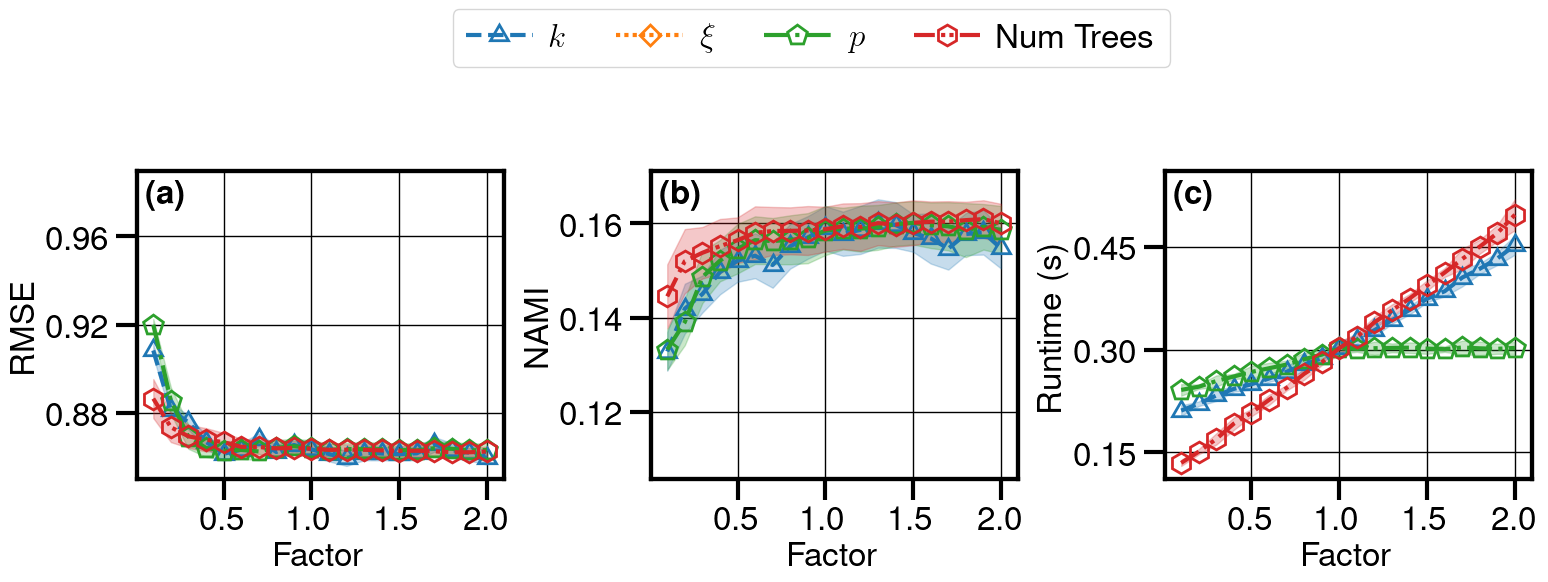

In [65]:
fname = 'SOI_sensitivity_experiment_horizontal2_noxi'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(1,len(var_names),
                        figsize=(6*len(var_names),4),
                        sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.4, hspace=0.15)

labels = experiment_names

cmap = mpl.cm.tab10
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
# color_lst = [cmap(4)]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15]*len(labels)
# marker_lst = ['v','^','1','2','.']
marker_lst = [(3,0,0),(4,0,0),(5,0,0),(6,0,0)]

ylim_stretch = 0.05

axs_twin = []
for i_var in range(len(var_names)):
    ax = axs[i_var]
    

    for i_experiment_name in range(len(experiment_names)):
        experiment_name = experiment_names[i_experiment_name]

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        if experiment_name == 'xi':
            ax.plot([],[],lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
            ax_twin = ax.twiny()
            axs_twin.append(ax_twin)
            xi_greatest = 12
            ax_twin.plot(np.array(experiment_dict[experiment_name]['factors'])[:xi_greatest], mean[:xi_greatest],
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color='none', zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax_twin.fill_between(experiment_dict[experiment_name]['factors'][:xi_greatest], lower[:xi_greatest], upper[:xi_greatest],
                            color='none', alpha=0.25, zorder=9)
#             ax_twin.xaxis.set_major_locator(plt.MaxNLocator(3))
#             xticks = ax_twin.get_xticks()[1:-1]
#             xticks = np.arange(1,xi_greatest+1,6)
            xticks = [2,7,12]
            ax_twin.set_xticks(xticks)
            
            
            # if i_var == 0:
            ax_twin.set_xticklabels([f'{xtick:.0f}' for xtick in xticks], ha='center', color='none')
            ax_twin.set_xlabel(experiment_dict[experiment_name]['label'], fontsize=fontsize, color='none', labelpad=10)
            # else:
            #     ax_twin.set_xticklabels('' for xtick in xticks)
#                 ax_twin.sharex(axs_twin[i_var-1])
                
            ax_twin.tick_params(length=15,width=3,color='none', zorder=-1)
            plt.setp(ax_twin.spines.values(), linewidth=3, zorder=100)
            ax_twin.grid(True, color='none', zorder=-2)
            
            ax.set_zorder(2)
            ax_twin.set_zorder(1)
            ax.patch.set_visible(False)
        else:
            ax.plot(np.array(experiment_dict[experiment_name]['factors']), mean,
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax.fill_between(experiment_dict[experiment_name]['factors'], lower, upper,
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)

#     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    # if i_var == len(var_names)-1:
    ax.set_xlabel('Factor', fontsize=fontsize)
    ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
#     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
#     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


#     if i_var == 0:
#     ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#     if i_var == 0:
    xticks = ax.get_xticks()[1:-1]
#     xticks = experiment_dict[experiment_name]['factors'][1::4]
#     xticks = [0.4,1.0,1.6]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
    ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

    if i_experiment_name == len(experiment_names)-1:
    #     if i_var == 0:
#         ax.set_ylim(0, None)
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ylim = ax.get_ylim()
#             ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
        ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
    #     if i_var == 0:
        yticks = ax.get_yticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_yticks(yticks)
        ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    ax.grid(True, c='k', lw=1, zorder=0)

    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)#,
                # bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))

    if i_var == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::], [experiment_dict[name]['label'] for name in experiment_names][::],
                   loc='lower center', bbox_to_anchor=(0.5,1.1),prop={'size': legendfontsize},ncol=len(labels),
                   columnspacing=1.5,handletextpad=0.5)
        
def LegendVertical(Ax, Rotation=90, XPad=0, YPad=0, Handles=None, Labels=None, **LegendArgs):
    if Rotation not in (90,270):
        raise NotImplementedError('Rotation must be 90 or 270.')

    # Extra spacing between labels is needed to fit the rotated labels;
    # and since the frame will not adjust to the rotated labels, it is
    # disabled by default
    DefaultLoc = 'center left' if Rotation==90 else 'center right'
    ArgsDefaults = dict(loc=DefaultLoc, labelspacing=4, frameon=False)
    Args = {**ArgsDefaults, **LegendArgs}

    if Handles is None or Labels is None:
        Handles, Labels = Ax.get_legend_handles_labels()
    if Rotation==90:
        # Reverse entries
        Handles, Labels = (reversed(_) for _ in (Handles, Labels))
    AxLeg = Ax.legend(Handles, Labels, **Args)

    LegTexts = AxLeg.get_texts()
    LegHandles = AxLeg.legend_handles

    for L,Leg in enumerate(LegHandles):
        if type(Leg) == mpl.patches.Rectangle:
            BBounds = np.ravel(Leg.get_bbox())
            BBounds[2:] = BBounds[2:][::-1]
            Leg.set_bounds(BBounds)

            LegPos = (
                # Ideally,
                #    `(BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad`
                # should be at the horizontal center of the legend patch,
                # but for some reason it is not. Therefore the user will
                # need to specify some padding.
                (BBounds[0]+(BBounds[2]/2)) - AxLeg.handletextpad + XPad,

                # Similarly, `(BBounds[1]+BBounds[3])` should be at the vertical
                # top of the legend patch, but it is not.
                (BBounds[1]+BBounds[3])+YPad
            )

        elif type(Leg) == mpl.lines.Line2D:
            LegXY = Leg.get_xydata()[:,::-1]
            Leg.set_data(*(LegXY[:,_] for _ in (0,1)))

            LegPos = (
                LegXY[0,0] - AxLeg.handletextpad + XPad,
                max(LegXY[:,1]) + YPad
            )

        elif type(Leg) == mpl.collections.PathCollection:
            LegPos = (
                Leg.get_offsets()[0][0] + XPad,
                Leg.get_offsets()[0][1] + YPad,
            )
        else:
            raise NotImplementedError('Legends should contain Rectangle, Line2D or PathCollection.')

        PText = LegTexts[L]
        PText.set_verticalalignment('bottom')
        PText.set_rotation(Rotation)
        PText.set_x(LegPos[0])
        PText.set_y(LegPos[1])

def legendAsLatex(axes, rotation=90) :
    '''Generate a latex code to be used instead of the legend. 
       Uses the label, color, marker and linestyle provided to the pyplot.plot.
       The marker and the linestyle must be defined using the one or two character
           abreviations shown in the help of pyplot.plot.
       Rotation of the markers must be multiple of 90.
    '''
    latexLine = {'-':'\\textbf{\Large ---}',
        '-.':'\\textbf{\Large --\:\!$\\boldsymbol{\cdot}$\:\!--}',
        '--':'\\textbf{\Large --\,--}',':':'\\textbf{\Large -\:\!-}'}
    latexSymbol = {'o':'medbullet', 'd':'diamond', 's':'filledmedsquare',
        'D':'Diamondblack', '*':'bigstar', '+':'boldsymbol{\plus}',
        'x':'boldsymbol{\\times}', 'p':'pentagon', 'h':'hexagon',
        ',':'boldsymbol{\cdot}', '_':'boldsymbol{\minus}','<':'LHD',
        '>':'RHD','v':'blacktriangledown', '^':'blacktriangle'} 
    rot90=['^','<','v','>']
    di = [0,-1,2,1][rotation%360//90]
    latexSymbol.update({rot90[i]:latexSymbol[rot90[(i+di)%4]] for i in range(4)})
#     return ', '.join(['\\textcolor[rgb]{'\
#             + ','.join([str(x) for x in mpl.colors.to_rgb(handle.get_color())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
#                 for handle,label in zip(*axes.get_legend_handles_labels())])
    return ', '.join(['\\textcolor[rgb]{'\
            + ','.join([str(x) for x in mpl.colors.to_rgb(list(handle)[0].get_facecolor())]) +'}{'
#             + '$\\'+latexSymbol.get(handle.get_marker(),';')+'$'
            + label + '} '# + label
#             + latexLine.get(handle.get_linestyle(),'') + '} ' + label 
                for handle,label in zip(*axes.get_legend_handles_labels())])
        
# #     if i_var == 0:
# leg_handles, leg_labels = axs[0].get_legend_handles_labels()
# # ax_tmp = axs[1].twinx()
# # ax_tmp.set_ylabel(legendAsLatex(axs[1]), fontsize=fontsize, labelpad=10)
# # plt.setp(ax_tmp.get_yticklabels(), visible=False)
# # ax_tmp.tick_params(bottom=False, top=False, left=False, right=False)
# LegendVertical(axs[1], Rotation=270, XPad=-65, YPad=5, Handles=leg_handles,
#                Labels=[experiment_dict[name]['label'] for name in experiment_names], prop={'size': legendfontsize},
#                loc='center', bbox_to_anchor=(1.2,0.4), columnspacing=-2, handletextpad=0.25, ncol=1,
#                labelspacing=4, reverse=False)
# axs[1].add_patch(mpl.patches.FancyBboxPatch((1.06, 0.35), .101, 2.675, transform=axs[2].transAxes, linewidth=1,
#                                             edgecolor='lightgray', facecolor='none', clip_on=False,
#                                             boxstyle=mpl.patches.BoxStyle("Round, pad=0.01, rounding_size=0.01")))

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()

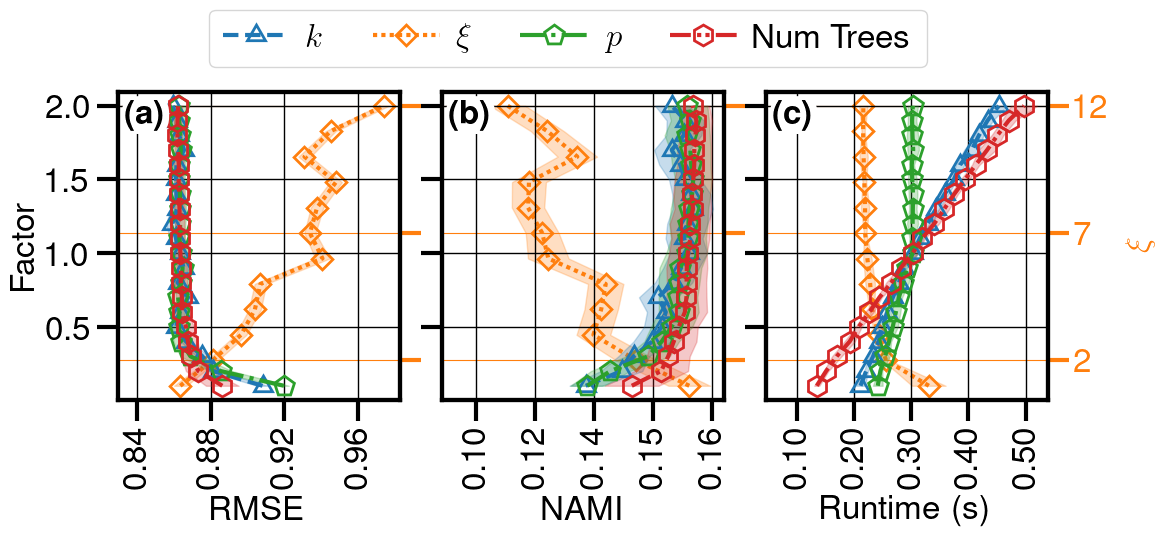

In [40]:
fname = 'SOI_sensitivity_experiment_horizontal'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(1,len(var_names),
                        figsize=(4*len(var_names),4),
                        sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.15, hspace=0.1)

labels = experiment_names

cmap = mpl.cm.tab10
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
# color_lst = [cmap(4)]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15]*len(labels)
# marker_lst = ['v','^','1','2','.']
marker_lst = [(3,0,0),(4,0,0),(5,0,0),(6,0,0)]

xlim_stretch = 0.15

axs_twin = []
for i_var in range(len(var_names)):
    ax = axs[i_var]
    

    for i_experiment_name in range(len(experiment_names)):
        experiment_name = experiment_names[i_experiment_name]

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        if experiment_name == 'xi':
            ax.plot([],[],lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
            ax_twin = ax.twinx()
            axs_twin.append(ax_twin)
            xi_greatest = 12
            ax_twin.plot(mean[:xi_greatest], np.array(experiment_dict[experiment_name]['factors'])[:xi_greatest],
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax_twin.fill_betweenx(experiment_dict[experiment_name]['factors'][:xi_greatest], lower[:xi_greatest], upper[:xi_greatest],
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)
#             ax_twin.xaxis.set_major_locator(plt.MaxNLocator(3))
#             xticks = ax_twin.get_xticks()[1:-1]
#             xticks = np.arange(1,xi_greatest+1,6)
            yticks = [2,7,12]
            ax_twin.set_yticks(yticks)
            
            
            if i_var == len(var_names)-1:
                ax_twin.set_yticklabels([f'{ytick:.0f}' for ytick in yticks], ha='left', color=color_lst[i_experiment_name])
                ax_twin.set_ylabel(experiment_dict[experiment_name]['label'], fontsize=fontsize, color=color_lst[i_experiment_name], labelpad=10)
            else:
                ax_twin.set_yticklabels('' for ytick in yticks)
#                 ax_twin.sharex(axs_twin[i_var-1])
                
            ax_twin.tick_params(length=15,width=3,color=color_lst[i_experiment_name], zorder=-1)
            plt.setp(ax_twin.spines.values(), linewidth=3, zorder=100)
            ax_twin.grid(True, color=color_lst[i_experiment_name], zorder=-2)
            
            ax.set_zorder(2)
            ax_twin.set_zorder(1)
            ax.patch.set_visible(False)
        else:
            ax.plot(mean, np.array(experiment_dict[experiment_name]['factors']), 
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax.fill_betweenx(experiment_dict[experiment_name]['factors'], lower, upper,
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)

#     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    if i_var == 0:
        ax.set_ylabel('Factor', fontsize=fontsize)
    ax.set_xlabel(var_labels[i_var], fontsize=fontsize)
#     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
#     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


#     if i_var == 0:
#     ax.set_xlim(0, None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
#     if i_var == 0:
    yticks = ax.get_yticks()[1:-1]
#     xticks = experiment_dict[experiment_name]['factors'][1::4]
#     xticks = [0.4,1.0,1.6]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_yticks(yticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
    ax.set_yticklabels(f'{ytick:.1f}' for ytick in yticks)

    if i_experiment_name == len(experiment_names)-1:
    #     if i_var == 0:
#         ax.set_ylim(0, None)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        xlim = ax.get_xlim()
#             ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
        ax.set_xlim(xlim[0]-xlim_stretch*np.diff(xlim), xlim[1])
    #     if i_var == 0:
        xticks = ax.get_xticks()[1:-1]
    #     else:
    #         yticks = ax.get_yticks()[1:-1]
        ax.set_xticks(xticks)
        ax.set_xticklabels([f'{xtick:{fmts[i_var]}}' for xtick in xticks], rotation=90)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    ax.grid(True, c='k', lw=1, zorder=0)

    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30,
                bbox=dict(boxstyle='round,pad=0.1,rounding_size=0.5',fc='w',ec=None,lw=0,alpha=1))

    if i_var == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::], [experiment_dict[name]['label'] for name in experiment_names], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                   columnspacing=1.5,handletextpad=0.5)
        

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()

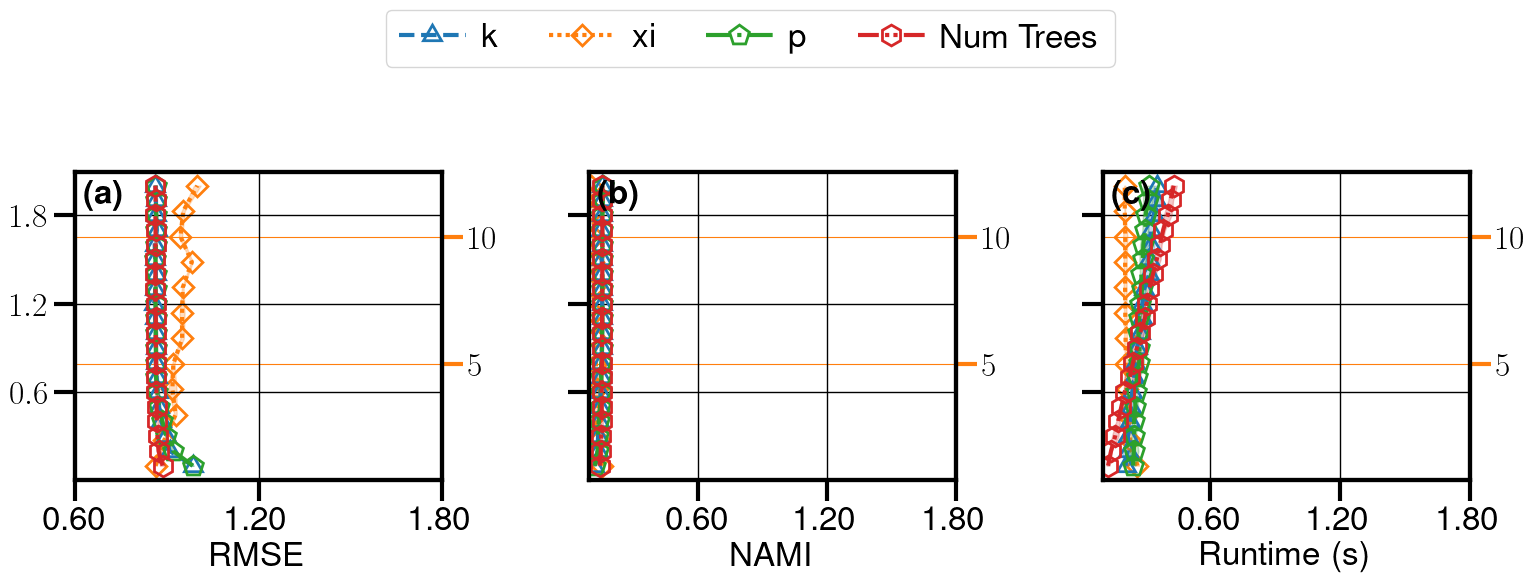

In [32]:
fname = 'SOI_sensitivity_experiment_horizontal'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(1,len(var_names),
                        figsize=(6*len(var_names),4),
                        sharex='col', sharey='row')
plt.subplots_adjust(wspace=0.4, hspace=0.1)

labels = experiment_names

cmap = mpl.cm.tab10
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
# color_lst = [cmap(4)]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15]*len(labels)
# marker_lst = ['v','^','1','2','.']
marker_lst = [(3,0,0),(4,0,0),(5,0,0),(6,0,0)]

ylim_stretch = 0.05

axs_twin = []
for i_var in range(len(var_names)):
    ax = axs[i_var]
    

    for i_experiment_name in range(len(experiment_names)):
        experiment_name = experiment_names[i_experiment_name]

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        if experiment_name == 'xi':
            ax.plot([],[],lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
            ax_twin = ax.twinx()
            axs_twin.append(ax_twin)
            xi_greatest = 12
            ax_twin.plot(mean[:xi_greatest], np.array(experiment_dict[experiment_name]['factors'])[:xi_greatest],
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax_twin.fill_betweenx(experiment_dict[experiment_name]['factors'][:xi_greatest], lower[:xi_greatest], upper[:xi_greatest],
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)
#             ax_twin.xaxis.set_major_locator(plt.MaxNLocator(3))
#             yticks = ax_twin.get_xticks()[1:-1]
#             yticks = np.arange(1,xi_greatest+1,6)
            yticks = [2,7,12]
            ax_twin.set_xticks(yticks)
            
            ax_twin.set_xticklabels([f'{ytick:.0f}' for ytick in yticks], ha='center', color=color_lst[i_experiment_name])
            ax_twin.set_xlabel(experiment_dict[experiment_name]['label'], fontsize=fontsize, color=color_lst[i_experiment_name], labelpad=10)
            
#             if i_var == 0:
#                 ax_twin.set_xticklabels([f'{xtick:.0f}' for xtick in yticks], ha='center', color=color_lst[i_experiment_name])
#                 ax_twin.set_xlabel(experiment_dict[experiment_name]['label'], fontsize=fontsize, color=color_lst[i_experiment_name], labelpad=10)
#             else:
#                 ax_twin.set_xticklabels('' for xtick in yticks)
# #                 ax_twin.sharex(axs_twin[i_var-1])
                
            ax_twin.tick_params(length=15,width=3,color=color_lst[i_experiment_name], zorder=-1)
            plt.setp(ax_twin.spines.values(), linewidth=3, zorder=100)
            ax_twin.grid(True, color=color_lst[i_experiment_name], zorder=-2)
            
            ax.set_zorder(2)
            ax_twin.set_zorder(1)
            ax.patch.set_visible(False)
        else:
            ax.plot(mean, np.array(experiment_dict[experiment_name]['factors']), 
                    lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                    label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                    marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
        #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
        #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
        #                         color=color_lst[i_label], zorder=20)
            ax.fill_betweenx(experiment_dict[experiment_name]['factors'], lower, upper,
                            color=color_lst[i_experiment_name], alpha=0.25, zorder=9)

#     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

#     if i_var == len(var_names)-1:
    ax.set_xlabel('Factor', fontsize=fontsize)
    ax.set_xlabel(var_labels[i_var], fontsize=fontsize)
#     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
#     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


#     if i_var == 0:
#     ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#     if i_var == 0:
    yticks = ax.get_xticks()[1:-1]
#     yticks = experiment_dict[experiment_name]['factors'][1::4]
#     yticks = [0.4,1.0,1.6]
#     else:
#         xticks = ax.get_yticks()[1:-1]
    ax.set_xticks(yticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in yticks)
    ax.set_xticklabels(f'{ytick:.1f}' for ytick in yticks)

    if i_experiment_name == len(experiment_names)-1:
    #     if i_var == 0:
#         ax.set_xlim(0, None)
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ylim = ax.get_xlim()
#             ax.set_xlim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
        ax.set_xlim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
    #     if i_var == 0:
        xticks = ax.get_yticks()[1:-1]
    #     else:
    #         xticks = ax.get_yticks()[1:-1]
        ax.set_xticks(xticks)
        ax.set_xticklabels(f'{ytick:{fmts[i_var]}}' for ytick in xticks)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    ax.grid(True, c='k', lw=1, zorder=0)

    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)

    if i_var == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,1.1),prop={'size': legendfontsize},ncol=len(labels),
                   columnspacing=1.5,handletextpad=0.5)
        
# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

# plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()

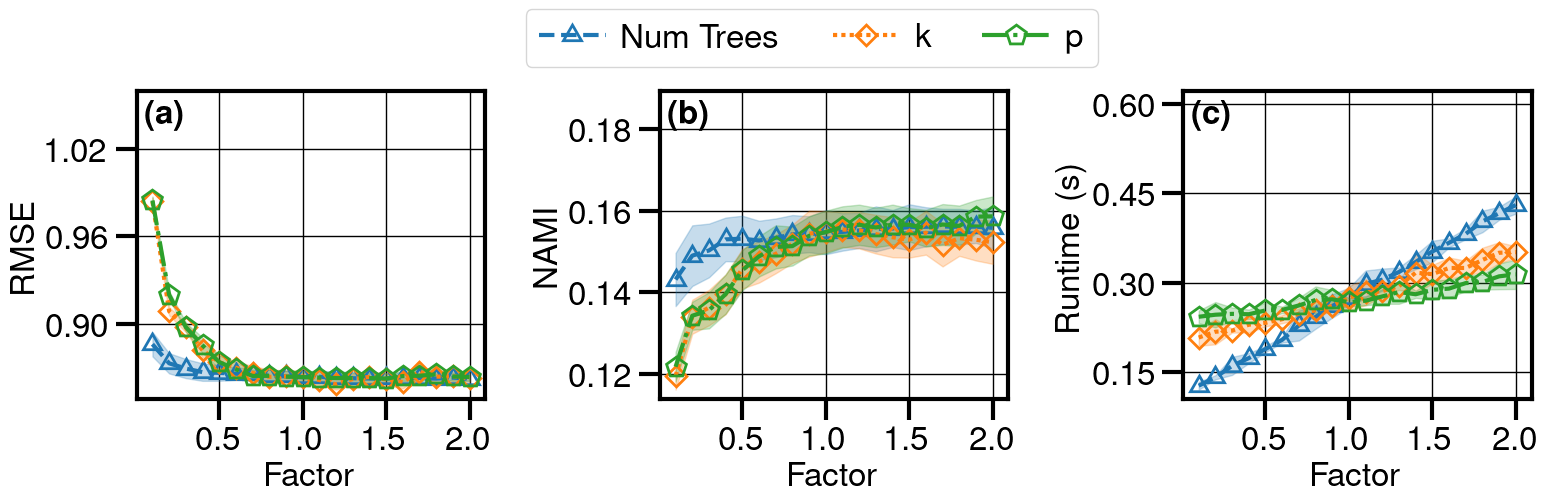

In [344]:
fname = 'SOI_sensitivity_experiment_horizontal'

fontsize = 24
legendfontsize = 24

annotate_xy = (0.025,0.975)

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

var_names = ['rmse', 'nami', 'runtimes']
var_labels = ['RMSE', 'NAMI', 'Runtime (s)']
locs = ['upper left', 'upper right', 'upper right']
fmts = ['.2f', '.2f', '.2f']

fig, axs = plt.subplots(1,len(var_names),
                        figsize=(6*len(var_names),4),
                        sharex='row', sharey='col')
plt.subplots_adjust(wspace=0.5, hspace=0.15)

labels = experiment_names

cmap = mpl.cm.tab10
qualitative = True
color_lst = cmap(np.arange(len(labels))) if qualitative else cmap(np.linspace(0,1,len(labels)))
# color_lst = mpl.colors.hsv_to_rgb(np.hstack((mpl.colors.rgb_to_hsv(color_lst[:,:-1])[:,:-1], (mpl.colors.rgb_to_hsv(color_lst[:,:-1]))[:,-1].reshape(-1,1))))
# color_lst[-1] = cmap(len(labels))[:-1]
# color_lst = [cmap(4)]

lw_lst = [3]*len(labels)
ls_lst = ['--', (0, (1, 1, 1, 1)), (0, (6, 1.5, 1, 1.5)), (0, (5, 1.5, 1, 1, 1, 1.5)), (0, (3, 1, 1, 1))]
ms_lst = [15]*len(labels)
# marker_lst = ['v','^','1','2','.']
marker_lst = [(3,0,0),(4,0,0),(5,0,0),(6,0,0)]

ylim_stretch = 0.45


for i_var in range(len(var_names)):
    ax = axs[i_var]

    for i_experiment_name in range(len(experiment_names)):
        experiment_name = experiment_names[i_experiment_name]

        if var_names[i_var] == 'rmse':
            mean = np.array([np.mean([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                   y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([RMSE_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                 y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'pcc':
            mean = np.array([np.mean([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([PCC_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test) for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'nami':
            mean = np.array([np.mean([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                  y_test)/AMI_summary(y_test,y_test)
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([AMI_summary(experiment_dict[experiment_name]['y_preds'][i_factor][i_run], 
                                                y_test)/AMI_summary(y_test,y_test)
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                            for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        elif var_names[i_var] == 'runtimes':
            mean = np.array([np.mean([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                      for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            std = np.array([np.std([experiment_dict[experiment_name]['runtimes'][i_factor][i_run]
                                    for i_run in range(len(experiment_dict[experiment_name]['y_preds'][0]))])
                             for i_factor in range(len(experiment_dict[experiment_name]['factors']))])
            lower = mean - std
            upper = mean + std
        i_label = 0
        ax.plot(np.array(experiment_dict[experiment_name]['factors']), mean,
                lw=lw_lst[i_experiment_name], ls=ls_lst[i_experiment_name],
                label=labels[i_experiment_name], color=color_lst[i_experiment_name], zorder=10,
                marker=marker_lst[i_experiment_name], ms=ms_lst[i_experiment_name], mew=2, mfc='none')
    #             ax.errorbar(np.array(train_sizes)/len(soi), [np.mean(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes],
    #                         yerr=[np.std(var[train_size][i_label][i_experiment_name]) for train_size in train_sizes], fmt='none',
    #                         color=color_lst[i_label], zorder=20)
        ax.fill_between(experiment_dict[experiment_name]['factors'], lower, upper,
                        color=color_lst[i_experiment_name], alpha=0.25, zorder=9)

#     ax.axhline(0,ls='-',c='k',lw=3,zorder=0)

    ax.set_xlabel('Factor', fontsize=fontsize)
    ax.set_ylabel(var_labels[i_var], fontsize=fontsize)
#     ax.set_xticks(x + width*(len(labels)-1)/2, np.arange(len(var[0])))
#     ax.set_xticklabels([f'{lead}' for lead in leads], fontsize=fontsize, rotation=0, ha='center')
#     ax.legend(loc=locs[i_var], ncols=1, prop={'size':legendfontsize})


#     if i_var == 0:
#     ax.set_xlim(0, None)
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#     if i_var == 0:
    xticks = ax.get_xticks()[1:-1]
#         xticks = experiment_dict[experiment_name]['factors'][1::4]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_xticks(xticks)
#         ax.set_xticklabels(f'{xtick:.0f}' for xtick in xticks)
    ax.set_xticklabels(f'{xtick:.1f}' for xtick in xticks)

#     if i_var == 0:
#         ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    ylim = ax.get_ylim()
#             ax.set_ylim(ylim[0]-ylim_stretch*np.diff(ylim), ylim[1]+ylim_stretch*np.diff(ylim))
    ax.set_ylim(ylim[0], ylim[1]+ylim_stretch*np.diff(ylim))
#     if i_var == 0:
    yticks = ax.get_yticks()[1:-1]
#     else:
#         yticks = ax.get_yticks()[1:-1]
    ax.set_yticks(yticks)
    ax.set_yticklabels(f'{ytick:{fmts[i_var]}}' for ytick in yticks)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    ax.grid(True, c='k', lw=1, zorder=0)

    ax.annotate(r'\textbf{('+chr(97+i_var)+r')}', xy=annotate_xy, ha='left', va='top', xycoords="axes fraction",fontsize=fontsize, zorder=30)

    if i_var == 0:
#             fig.legend(loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
#                           columnspacing=1.5,handletextpad=0.5)
        leg_handles, leg_labels = ax.get_legend_handles_labels()
        fig.legend(leg_handles[::], leg_labels[::], loc='lower center', bbox_to_anchor=(0.5,0.9),prop={'size': legendfontsize},ncol=len(labels),
                   columnspacing=1.5,handletextpad=0.5)

# axs[0].legend(loc='lower center', bbox_to_anchor=(0.5,1.02),prop={'size': fontsize},ncol=len(labels),
#               columnspacing=1,handletextpad=0.25)

# plt.savefig(fig_dir+fname+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+fname+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)

fig.align_labels(axs)

plt.show()